## Analysis v4

In [1]:
import os
import textwrap
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from natsort import index_natsorted

### Calculating the Variance of the AF and FPS values 

It would be quite interesting to see if for each variant site per motif, the variance of the AF and FPS values are correlated.

I.e. if a variant site has a high variance in AF values, does it also have a high variance in FPS values?

First, load the data file as dataframe and then truncate the columns to include on AF and FPS data. Next, convert the dataframe into long format.

In [2]:
# import the data
# filepath = '/home/users/ntu/suffiazi/scratch/outputs/tmp/input_data/E2F5_E2F5_HUMAN.H11MO.0.B_fpscore-af-varsites-combined-matrix-wide.tsv'
filepath = '/home/msazizan/hyperspace/gatk-workflow/plotting/output-data/combined_matrix/E2F5_E2F5_HUMAN.H11MO.0.B_fpscore-af-varsites-combined-matrix-wide.tsv'
matrix_afps = pd.read_csv(filepath, sep='\t')
# extract motif id from filename
motif_id = os.path.basename(filepath).replace('_fpscore-af-varsites-combined-matrix-wide.tsv', '')
motif_id

'E2F5_E2F5_HUMAN.H11MO.0.B'

In [3]:
matrix_afps.head()

Chromosome    Start      End  98JKPD8_lumA_fps  ANAB5F7_basal_fps  \
0       chr1   905473   905483           0.10260            0.12218   
1       chr1   925405   925415           0.09540            0.03670   
2       chr1  1020750  1020760           0.09749            0.09080   
3       chr1  1130413  1130423           0.11471            0.04786   
4       chr1  1225277  1225287           0.01792            0.04624   

   S6R691V_her2_fps  PU24GB8_lumB_fps  2GAMBDQ_norm_fps  \
0           0.13921           0.12024           0.14062   
1           0.09011           0.05082           0.05586   
2           0.07864           0.10880           0.08458   
3           0.11338           0.14384           0.15151   
4           0.02729           0.01957           0.02657   

   2GAMBDQ_norm_varsite_pos 2GAMBDQ_norm_ref_allele  ... ANAB5F7_basal_AF  \
0                       NaN                     NaN  ...         0.000000   
1                  925409.0                       T  ...         0.730769   
2                 1020755.0                       C  ...         0.000000   
3                 1130420.0                       C  ...         0.062500   
4                 1225285.0                       G  ...         0.062500   

   PU24GB8_lumB_varsite_pos  PU24GB8_lumB_ref_allele PU24GB8_lumB_alt_allele  \
0                  905474.0                        G                       A   
1                  925409.0                        T                       C   
2                       NaN                      NaN                     NaN   
3                 1130420.0                        C                       T   
4                 1225285.0                        G                       A   

  PU24GB8_lumB_AF  S6R691V_her2_varsite_pos  S6R691V_her2_ref_allele  \
0        0.027778                       NaN                      NaN   
1        0.769231                  925409.0                        T   
2        0.000000                       NaN                      NaN   
3        0.131579                 1130420.0                        C   
4        0.078947                 1225285.0                        G   

  S6R691V_her2_alt_allele S6R691V_her2_AF             region_id  
0                     NaN        0.000000    chr1:905473-905483  
1                       C        0.730769    chr1:925405-925415  
2                     NaN        0.000000  chr1:1020750-1020760  
3                       T        0.147059  chr1:1130413-1130423  
4                       A        0.088235  chr1:1225277-1225287  

[5 rows x 29 columns]

Let's filter the loaded table to include only the `_AF` and `_fps` columns, as well as the `region_id` column.

In [4]:
afps_df = matrix_afps.filter(regex='_AF$|_fps$|_id$').copy()
afps_df.head(5)

98JKPD8_lumA_fps  ANAB5F7_basal_fps  S6R691V_her2_fps  PU24GB8_lumB_fps  \
0           0.10260            0.12218           0.13921           0.12024   
1           0.09540            0.03670           0.09011           0.05082   
2           0.09749            0.09080           0.07864           0.10880   
3           0.11471            0.04786           0.11338           0.14384   
4           0.01792            0.04624           0.02729           0.01957   

   2GAMBDQ_norm_fps  2GAMBDQ_norm_AF  98JKPD8_lumA_AF  ANAB5F7_basal_AF  \
0           0.14062         0.000000         0.000000          0.000000   
1           0.05586         1.000000         1.000000          0.730769   
2           0.08458         0.062500         0.000000          0.000000   
3           0.15151         0.250000         0.181818          0.062500   
4           0.02657         0.071429         0.090909          0.062500   

   PU24GB8_lumB_AF  S6R691V_her2_AF             region_id  
0         0.027778         0.000000    chr1:905473-905483  
1         0.769231         0.730769    chr1:925405-925415  
2         0.000000         0.000000  chr1:1020750-1020760  
3         0.131579         0.147059  chr1:1130413-1130423  
4         0.078947         0.088235  chr1:1225277-1225287

In [5]:
# convert to long format
afps_df_long = afps_df.melt(id_vars=["region_id"], var_name="variable", value_name="value")

# split the variable column into sample_id and type columns using reverse split string method, which returns a dataframe of columns based on the number of splits (n=x); this can directly be assigned to new columns in the original dataframe
afps_df_long[['sample_id', 'type']] = afps_df_long['variable'].str.rsplit('_', n=1, expand=True)

# drop the redundant 'variable' column
afps_df_long = afps_df_long.drop(columns=["variable"])

# now pivot the dataframe to create new columns based on the type column
afps_df_lpv = afps_df_long.pivot(index=['region_id', 'sample_id'], columns='type', values='value').reset_index()

# remove the index name and rename the columns to match the type values
afps_df_lpv = afps_df_lpv.rename_axis(None, axis=1).rename(columns={'fps': 'FPS'})

# sort the dataframe by region_id naturally
afps_df_lpv = afps_df_lpv.reindex(index=index_natsorted(afps_df_lpv['region_id']))
afps_df_lpv = afps_df_lpv.reset_index(drop=True)
afps_df_lpv

region_id      sample_id        AF      FPS
0            chr1:905473-905483   2GAMBDQ_norm  0.000000  0.14062
1            chr1:905473-905483   98JKPD8_lumA  0.000000  0.10260
2            chr1:905473-905483  ANAB5F7_basal  0.000000  0.12218
3            chr1:905473-905483   PU24GB8_lumB  0.027778  0.12024
4            chr1:905473-905483   S6R691V_her2  0.000000  0.13921
...                         ...            ...       ...      ...
10920  chrX:150849074-150849084   2GAMBDQ_norm  0.750000  0.20522
10921  chrX:150849074-150849084   98JKPD8_lumA  0.500000  0.34392
10922  chrX:150849074-150849084  ANAB5F7_basal  0.600000  0.07363
10923  chrX:150849074-150849084   PU24GB8_lumB  0.605263  0.24735
10924  chrX:150849074-150849084   S6R691V_her2  0.588235  0.35995

[10925 rows x 4 columns]

In [6]:
# afps_df_lpv[afps_df_lpv['sample_id'] == '2GAMBDQ_norm'].describe()

### AF–FPS Matrix
At this point, we now have both a matrix of AF and FPS values in wide form (`afps_df`) and the same dataset in long form (`afps_df_lpv`). We can scale the FPS values to be between 0 and 1 now.

In [7]:
# use MinMaxScaler to scale the raw fps values to range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
# scale the FPS values to a range of 0-1
# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# copy df
fps_df_scaled = matrix_afps.filter(regex='_fps$|_id$').copy()

# set the index to 'region_id'
fps_df_scaled = fps_df_scaled.set_index('region_id')

# Fit the MinMaxScaler to the 'FPS' column and transform it
fps_df_scaled = pd.DataFrame(scaler.fit_transform(fps_df_scaled), columns=fps_df_scaled.columns, index=fps_df_scaled.index)

# rename columns by adding '_scaled' to the column names
fps_df_scaled = fps_df_scaled.add_suffix('_scaled')
fps_df_scaled

98JKPD8_lumA_fps_scaled  ANAB5F7_basal_fps_scaled  \
region_id                                                                     
chr1:905473-905483                       0.045183                  0.062660   
chr1:925405-925415                       0.042012                  0.018821   
chr1:1020750-1020760                     0.042933                  0.046566   
chr1:1130413-1130423                     0.050516                  0.024545   
chr1:1225277-1225287                     0.007892                  0.023714   
...                                           ...                       ...   
chrX:118300271-118300281                 0.003096                  0.005052   
chrX:119211181-119211191                 0.005351                  0.006087   
chrX:139342109-139342119                 0.008878                  0.004262   
chrX:147508113-147508123                 0.003567                  0.003246   
chrX:150849074-150849084                 0.151456                  0.037761   

                          S6R691V_her2_fps_scaled  PU24GB8_lumB_fps_scaled  \
region_id                                                                    
chr1:905473-905483                       0.069304                 0.056307   
chr1:925405-925415                       0.044860                 0.023798   
chr1:1020750-1020760                     0.039150                 0.050950   
chr1:1130413-1130423                     0.056445                 0.067359   
chr1:1225277-1225287                     0.013586                 0.009164   
...                                           ...                      ...   
chrX:118300271-118300281                 0.002768                 0.002861   
chrX:119211181-119211191                 0.005103                 0.006397   
chrX:139342109-139342119                 0.010728                 0.007750   
chrX:147508113-147508123                 0.003470                 0.002946   
chrX:150849074-150849084                 0.179197                 0.115831   

                          2GAMBDQ_norm_fps_scaled  
region_id                                          
chr1:905473-905483                       0.065892  
chr1:925405-925415                       0.026175  
chr1:1020750-1020760                     0.039632  
chr1:1130413-1130423                     0.070994  
chr1:1225277-1225287                     0.012450  
...                                           ...  
chrX:118300271-118300281                 0.004264  
chrX:119211181-119211191                 0.006813  
chrX:139342109-139342119                 0.010121  
chrX:147508113-147508123                 0.006865  
chrX:150849074-150849084                 0.096162  

[2185 rows x 5 columns]

Now we should convert the FPS scaled dataframe into long form.

In [8]:
# reset index
fps_df_scaled_long = fps_df_scaled.reset_index()
# convert to long format
fps_df_scaled_long = fps_df_scaled_long.melt(id_vars=["region_id"], var_name="variable", value_name="value")

# split the variable column into sample_id and type columns using reverse split string method, which returns a dataframe of columns based on the number of splits (n=x); this can directly be assigned to new columns in the original dataframe
# Split the 'variable' column into three parts
fps_df_scaled_long[['part1', 'part2', 'part3']] = fps_df_scaled_long['variable'].str.rsplit('_', n=2, expand=True)

# Assign part1 to 'sample_id' and concatenate the other parts to form 'type'
fps_df_scaled_long['sample_id'] = fps_df_scaled_long['part1']
fps_df_scaled_long['type'] = fps_df_scaled_long['part2'].str.upper() + '_' + fps_df_scaled_long['part3']

# Drop the unnecessary columns
fps_df_scaled_long = fps_df_scaled_long.drop(['variable', 'part1', 'part2', 'part3'], axis=1)

# now pivot the dataframe to create new columns based on the type column
fps_df_scaled_lpv = fps_df_scaled_long.pivot(index=['region_id', 'sample_id'], columns='type', values='value').reset_index()

# remove the index name and rename the columns to match the type values
fps_df_scaled_lpv = fps_df_scaled_lpv.rename_axis(None, axis=1)

# sort the dataframe by region_id naturally
fps_df_scaled_lpv = fps_df_scaled_lpv.reindex(index=index_natsorted(fps_df_scaled_lpv['region_id']))
fps_df_scaled_lpv = fps_df_scaled_lpv.reset_index(drop=True)
fps_df_scaled_lpv

region_id      sample_id  FPS_scaled
0            chr1:905473-905483   2GAMBDQ_norm    0.065892
1            chr1:905473-905483   98JKPD8_lumA    0.045183
2            chr1:905473-905483  ANAB5F7_basal    0.062660
3            chr1:905473-905483   PU24GB8_lumB    0.056307
4            chr1:905473-905483   S6R691V_her2    0.069304
...                         ...            ...         ...
10920  chrX:150849074-150849084   2GAMBDQ_norm    0.096162
10921  chrX:150849074-150849084   98JKPD8_lumA    0.151456
10922  chrX:150849074-150849084  ANAB5F7_basal    0.037761
10923  chrX:150849074-150849084   PU24GB8_lumB    0.115831
10924  chrX:150849074-150849084   S6R691V_her2    0.179197

[10925 rows x 3 columns]

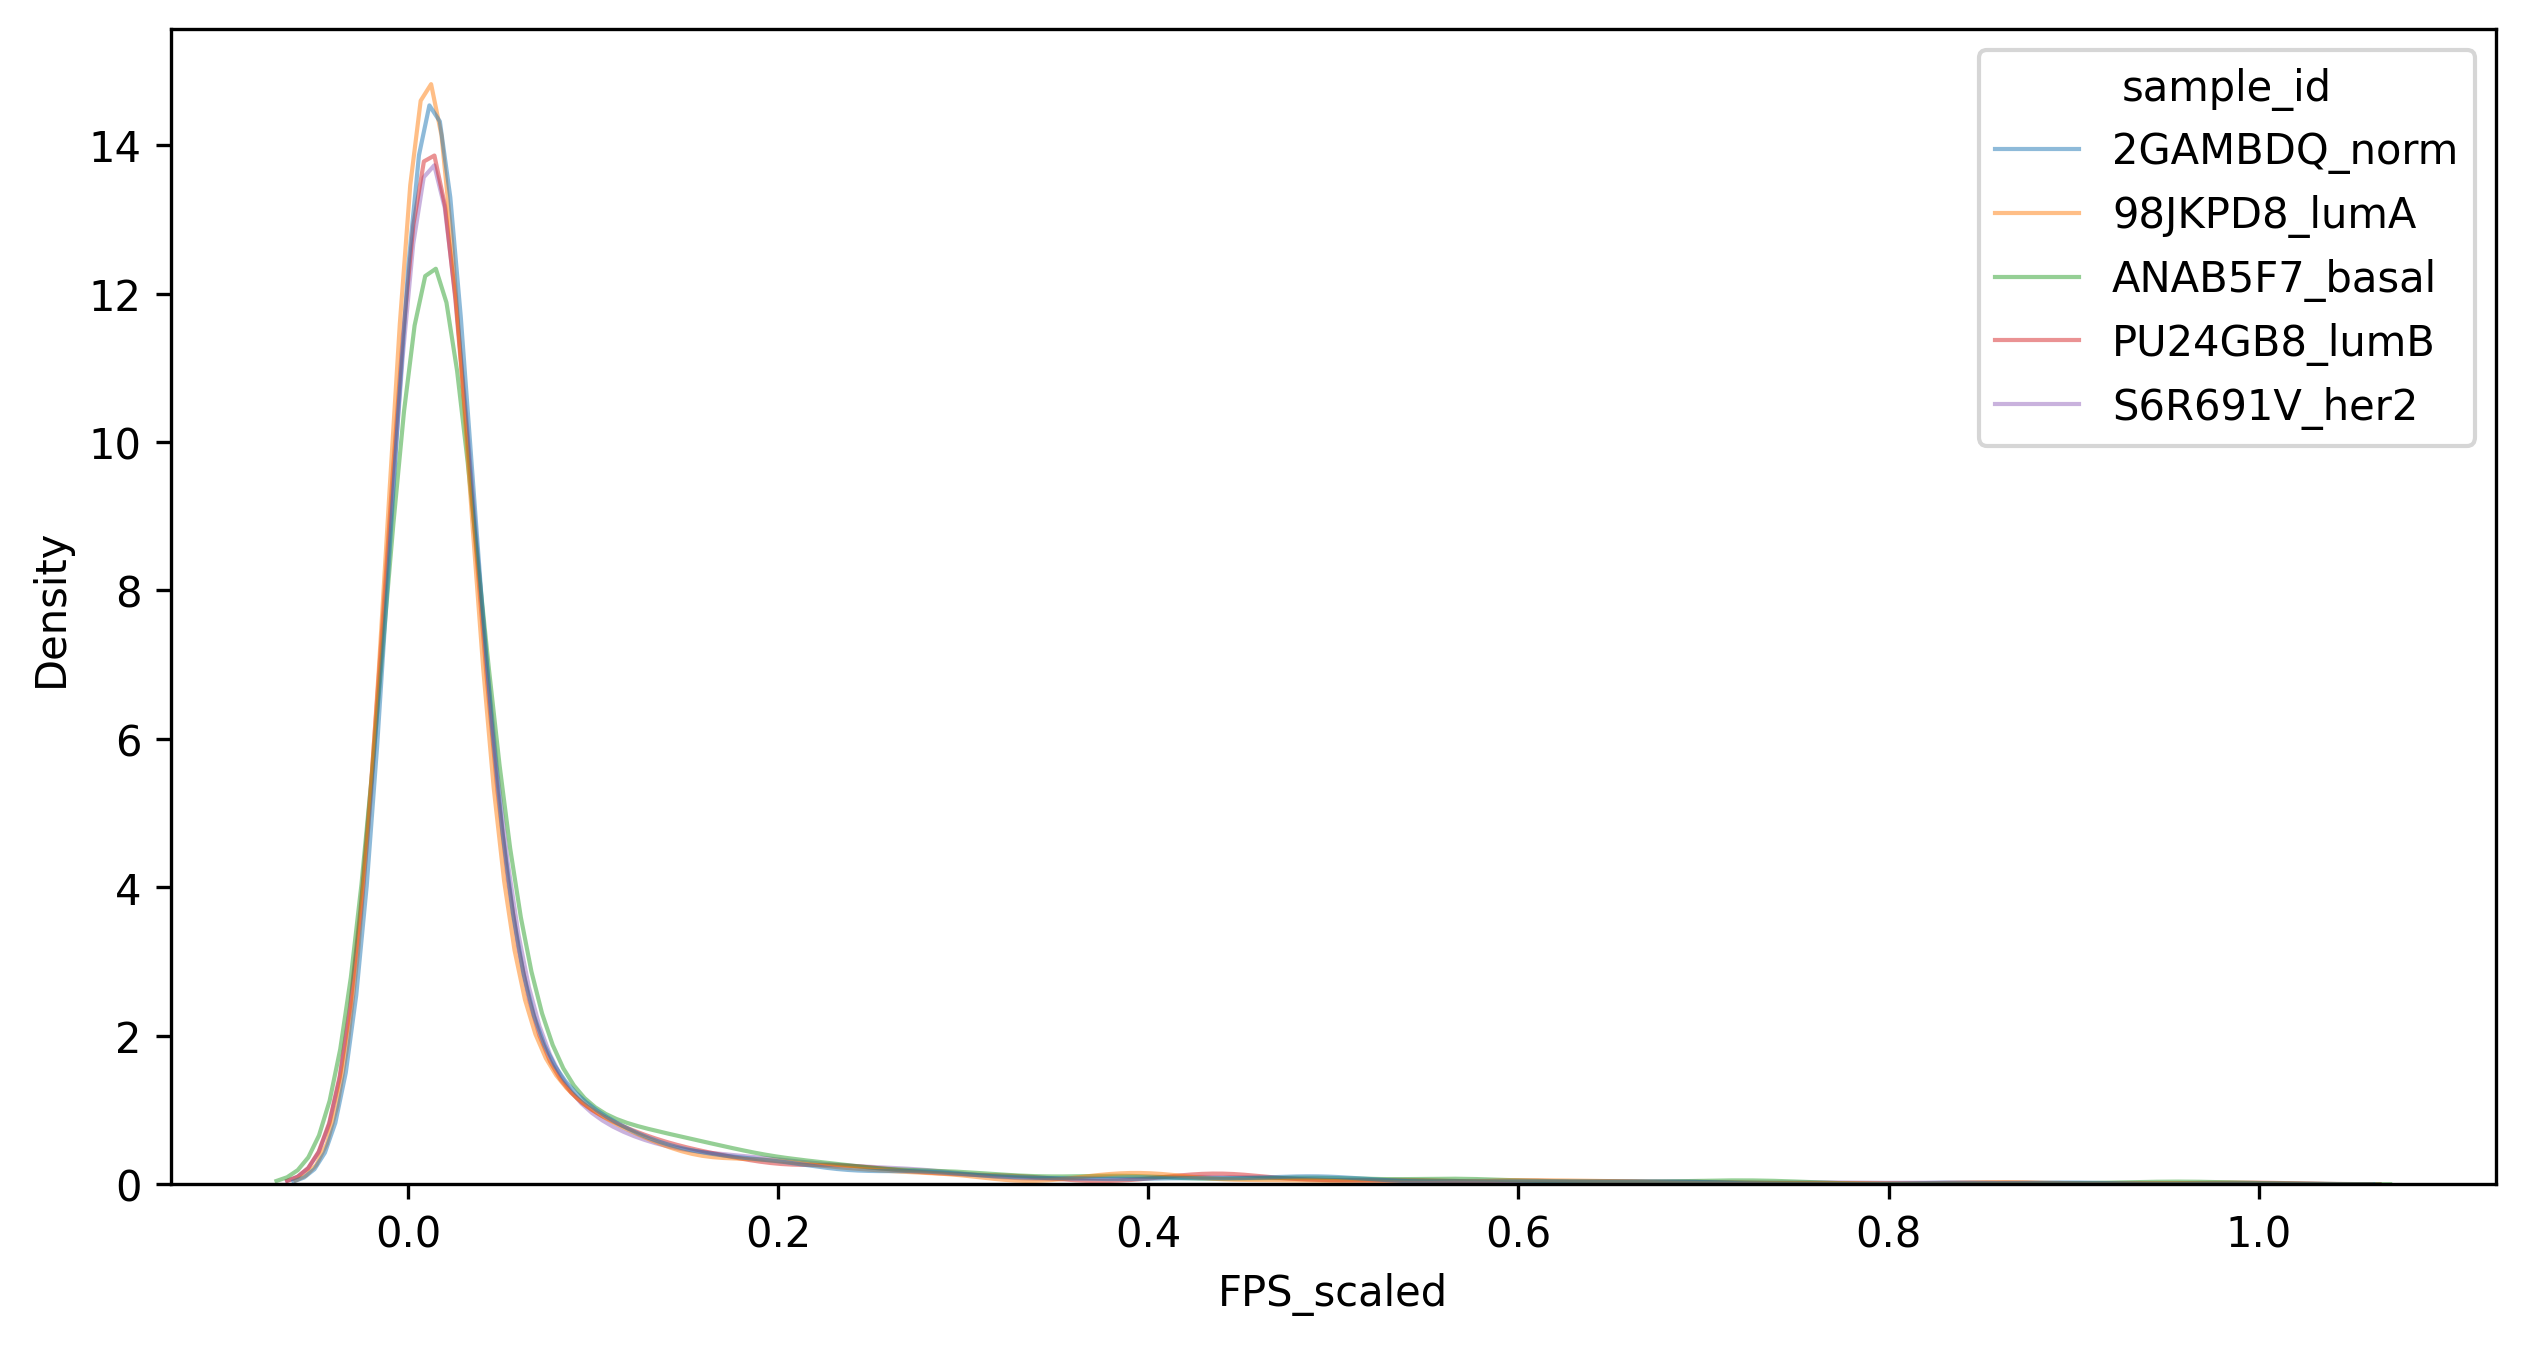

In [9]:
# plot fps distribution
plt.figure(figsize=(10, 5), dpi=300)
sns.kdeplot(data=fps_df_scaled_lpv, x="FPS_scaled", hue="sample_id", fill=False, common_norm=False, alpha=.5, linewidth=1)
plt.show()

### Merging `afps_df_lpv` and `fps_df_scaled_lpv`

Now we can merge the two long dataframes together to get both raw FPS and scaled FPS values in one dataframe.

In [10]:
afps_df_lpv

region_id      sample_id        AF      FPS
0            chr1:905473-905483   2GAMBDQ_norm  0.000000  0.14062
1            chr1:905473-905483   98JKPD8_lumA  0.000000  0.10260
2            chr1:905473-905483  ANAB5F7_basal  0.000000  0.12218
3            chr1:905473-905483   PU24GB8_lumB  0.027778  0.12024
4            chr1:905473-905483   S6R691V_her2  0.000000  0.13921
...                         ...            ...       ...      ...
10920  chrX:150849074-150849084   2GAMBDQ_norm  0.750000  0.20522
10921  chrX:150849074-150849084   98JKPD8_lumA  0.500000  0.34392
10922  chrX:150849074-150849084  ANAB5F7_basal  0.600000  0.07363
10923  chrX:150849074-150849084   PU24GB8_lumB  0.605263  0.24735
10924  chrX:150849074-150849084   S6R691V_her2  0.588235  0.35995

[10925 rows x 4 columns]

In [11]:
fps_df_scaled_lpv

region_id      sample_id  FPS_scaled
0            chr1:905473-905483   2GAMBDQ_norm    0.065892
1            chr1:905473-905483   98JKPD8_lumA    0.045183
2            chr1:905473-905483  ANAB5F7_basal    0.062660
3            chr1:905473-905483   PU24GB8_lumB    0.056307
4            chr1:905473-905483   S6R691V_her2    0.069304
...                         ...            ...         ...
10920  chrX:150849074-150849084   2GAMBDQ_norm    0.096162
10921  chrX:150849074-150849084   98JKPD8_lumA    0.151456
10922  chrX:150849074-150849084  ANAB5F7_basal    0.037761
10923  chrX:150849074-150849084   PU24GB8_lumB    0.115831
10924  chrX:150849074-150849084   S6R691V_her2    0.179197

[10925 rows x 3 columns]

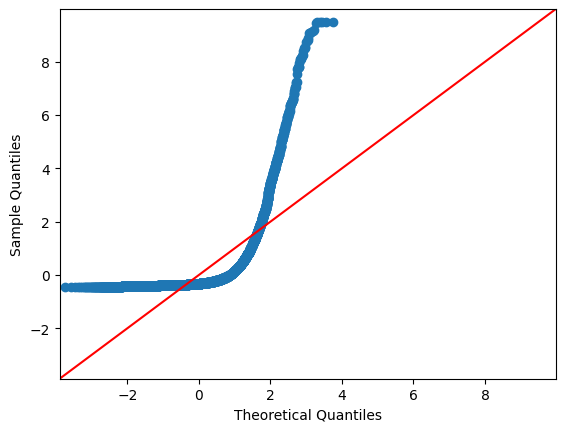

In [12]:
fig = sm.qqplot(fps_df_scaled_lpv['FPS_scaled'], line='45', fit=True)
plt.show()

In [13]:
# merge two dataframes on region_id and sample_id
afps_full_dfl = afps_df_lpv.merge(fps_df_scaled_lpv, on=['region_id', 'sample_id'])
afps_full_dfl

region_id      sample_id        AF      FPS  FPS_scaled
0            chr1:905473-905483   2GAMBDQ_norm  0.000000  0.14062    0.065892
1            chr1:905473-905483   98JKPD8_lumA  0.000000  0.10260    0.045183
2            chr1:905473-905483  ANAB5F7_basal  0.000000  0.12218    0.062660
3            chr1:905473-905483   PU24GB8_lumB  0.027778  0.12024    0.056307
4            chr1:905473-905483   S6R691V_her2  0.000000  0.13921    0.069304
...                         ...            ...       ...      ...         ...
10920  chrX:150849074-150849084   2GAMBDQ_norm  0.750000  0.20522    0.096162
10921  chrX:150849074-150849084   98JKPD8_lumA  0.500000  0.34392    0.151456
10922  chrX:150849074-150849084  ANAB5F7_basal  0.600000  0.07363    0.037761
10923  chrX:150849074-150849084   PU24GB8_lumB  0.605263  0.24735    0.115831
10924  chrX:150849074-150849084   S6R691V_her2  0.588235  0.35995    0.179197

[10925 rows x 5 columns]

In [14]:
# save to file
# afps_full_dfl.to_csv(f'/home/msazizan/hyperspace/gatk-workflow/plotting/output-data/AF-FPS_regionsorted_full_longtable/{motif_id}_afps_full_scaled_longtable.tsv', sep='\t', index=False)

### Calculating Variation Statistics
With the full data table cleaned up into a long format, we can now calculate the variation statistics for each region. We will calculate the following statistics:
* variance (Var)
* ~~coefficient of variation (CV)~~
* ~~quartile coefficient of dispersion (QCD)~~

First calculate statistics on the raw FPS data.

In [15]:
# extract fps columns
fps_df = matrix_afps.filter(regex='_fps$|_id$').copy()
# calculate variance of fps values across samples per region_id and add to a new column called 'fps_var'
fps_df = fps_df.set_index('region_id')
fps_df['FPS_var'] = fps_df.var(axis=1)
# calculate the coefficient of variation (CV) of fps values across samples per region_id and add to a new column called 'fps_cv'
# fps_df['FPS_cv'] = fps_df.drop(columns=['FPS_var']).std(axis=1) / fps_df.drop(columns=['FPS_var']).mean(axis=1) * 100
# calculate the quartile coefficient of dispersion (QCD) of fps values across samples per region_id and add to a new column called 'fps_qcd'
# fps_df['FPS_qcd'] = (fps_df.drop(columns=['FPS_var', 'FPS_cv']).quantile(q=0.75, axis=1) - fps_df.drop(columns=['FPS_var', 'FPS_cv']).quantile(q=0.25, axis=1)) / (fps_df.drop(columns=['FPS_var', 'FPS_cv']).quantile(q=0.75, axis=1) + fps_df.drop(columns=['FPS_var', 'FPS_cv']).quantile(q=0.25, axis=1))
fps_df.head()

98JKPD8_lumA_fps  ANAB5F7_basal_fps  S6R691V_her2_fps  \
region_id                                                                     
chr1:905473-905483             0.10260            0.12218           0.13921   
chr1:925405-925415             0.09540            0.03670           0.09011   
chr1:1020750-1020760           0.09749            0.09080           0.07864   
chr1:1130413-1130423           0.11471            0.04786           0.11338   
chr1:1225277-1225287           0.01792            0.04624           0.02729   

                      PU24GB8_lumB_fps  2GAMBDQ_norm_fps   FPS_var  
region_id                                                           
chr1:905473-905483             0.12024           0.14062  0.000245  
chr1:925405-925415             0.05082           0.05586  0.000659  
chr1:1020750-1020760           0.10880           0.08458  0.000137  
chr1:1130413-1130423           0.14384           0.15151  0.001668  
chr1:1225277-1225287           0.01957           0.02657  0.000127

Then do the same on the fps scaled data.

In [16]:
# copy fps_df_scaled
fps_df_scaled_cp = fps_df_scaled.copy()
# calculate variance of fps_scaled values across samples per region_id and add to a new column called 'fps_scaled_var'
fps_df_scaled_cp['FPS_scaled_var'] = fps_df_scaled_cp.var(axis=1)
# calculate the coefficient of variation (CV) of fps values across samples per region_id and add to a new column called 'fps_scaled_cv'
# fps_df_scaled['FPS_scaled_cv'] = fps_df_scaled.drop(columns=['FPS_scaled_var']).std(axis=1) / fps_df_scaled.drop(columns=['FPS_scaled_var']).mean(axis=1) * 100
# calculate the quartile coefficient of dispersion (QCD) of fps values across samples per region_id and add to a new column called 'fps_scaled_qcd'
# fps_df_scaled['FPS_scaled_qcd'] = (fps_df_scaled.drop(columns=['FPS_scaled_var', 'FPS_scaled_cv']).quantile(q=0.75, axis=1) - fps_df_scaled.drop(columns=['FPS_scaled_var', 'FPS_scaled_cv']).quantile(q=0.25, axis=1)) / (fps_df_scaled.drop(columns=['FPS_scaled_var', 'FPS_scaled_cv']).quantile(q=0.75, axis=1) + fps_df_scaled.drop(columns=['FPS_scaled_var', 'FPS_scaled_cv']).quantile(q=0.25, axis=1))
fps_df_scaled_cp.head()

98JKPD8_lumA_fps_scaled  ANAB5F7_basal_fps_scaled  \
region_id                                                                 
chr1:905473-905483                   0.045183                  0.062660   
chr1:925405-925415                   0.042012                  0.018821   
chr1:1020750-1020760                 0.042933                  0.046566   
chr1:1130413-1130423                 0.050516                  0.024545   
chr1:1225277-1225287                 0.007892                  0.023714   

                      S6R691V_her2_fps_scaled  PU24GB8_lumB_fps_scaled  \
region_id                                                                
chr1:905473-905483                   0.069304                 0.056307   
chr1:925405-925415                   0.044860                 0.023798   
chr1:1020750-1020760                 0.039150                 0.050950   
chr1:1130413-1130423                 0.056445                 0.067359   
chr1:1225277-1225287                 0.013586                 0.009164   

                      2GAMBDQ_norm_fps_scaled  FPS_scaled_var  
region_id                                                      
chr1:905473-905483                   0.065892        0.000090  
chr1:925405-925415                   0.026175        0.000134  
chr1:1020750-1020760                 0.039632        0.000025  
chr1:1130413-1130423                 0.070994        0.000338  
chr1:1225277-1225287                 0.012450        0.000039

In [17]:
# Do the same for AF values
# extract af columns
af_df = matrix_afps.filter(regex='_AF$|_id$')
af_df = af_df.set_index('region_id')
# then calculate variance of af values across samples per region_id and add to a new column called 'af_var'
af_df['AF_var'] = af_df.var(axis=1)
af_df.head()

2GAMBDQ_norm_AF  98JKPD8_lumA_AF  ANAB5F7_basal_AF  \
region_id                                                                  
chr1:905473-905483           0.000000         0.000000          0.000000   
chr1:925405-925415           1.000000         1.000000          0.730769   
chr1:1020750-1020760         0.062500         0.000000          0.000000   
chr1:1130413-1130423         0.250000         0.181818          0.062500   
chr1:1225277-1225287         0.071429         0.090909          0.062500   

                      PU24GB8_lumB_AF  S6R691V_her2_AF    AF_var  
region_id                                                         
chr1:905473-905483           0.027778         0.000000  0.000154  
chr1:925405-925415           0.769231         0.730769  0.019970  
chr1:1020750-1020760         0.000000         0.000000  0.000781  
chr1:1130413-1130423         0.131579         0.147059  0.004728  
chr1:1225277-1225287         0.078947         0.088235  0.000139

Now merge the statistics tables together on `region_id` index.

In [18]:
# subset only the fps stats columns
# fps_stats_df = fps_df.filter(regex='_var$|_cv$|_qcd$|_id$').copy()
# fps_scaled_stats_df = fps_df_scaled.filter(regex='_var$|_cv$|_qcd$|_id$').copy()
fps_stats_df = fps_df.filter(regex='_var$|_id$').copy()
fps_scaled_stats_df = fps_df_scaled_cp.filter(regex='_var$|_id$').copy()
af_stats_df = af_df.filter(regex='_var$|_id$').copy()
# merge on region_id index from both tables
fps_stats_df_temp = fps_stats_df.merge(fps_scaled_stats_df, left_index=True, right_index=True)
# now merge with af_df
afps_stats_df = fps_stats_df_temp.merge(af_stats_df, left_index=True, right_index=True)
afps_stats_df


FPS_var  FPS_scaled_var    AF_var
region_id                                                   
chr1:905473-905483        0.000245    9.036129e-05  0.000154
chr1:925405-925415        0.000659    1.341879e-04  0.019970
chr1:1020750-1020760      0.000137    2.462661e-05  0.000781
chr1:1130413-1130423      0.001668    3.382467e-04  0.004728
chr1:1225277-1225287      0.000127    3.889771e-05  0.000139
...                            ...             ...       ...
chrX:118300271-118300281  0.000003    1.009942e-06  0.001020
chrX:119211181-119211191  0.000003    5.101216e-07  0.001672
chrX:139342109-139342119  0.000031    6.536719e-06  0.000889
chrX:147508113-147508123  0.000012    2.588244e-06  0.000413
chrX:150849074-150849084  0.013487    2.941480e-03  0.008072

[2185 rows x 3 columns]

Now we have a table of stats data to merge with the longform AF_FPS table (`afps_full_dfl`).

In [19]:
# set the index to 'region_id'
afps_full_dfli = afps_full_dfl.set_index('region_id')
afps_full_dfli

sample_id        AF      FPS  FPS_scaled
region_id                                                             
chr1:905473-905483         2GAMBDQ_norm  0.000000  0.14062    0.065892
chr1:905473-905483         98JKPD8_lumA  0.000000  0.10260    0.045183
chr1:905473-905483        ANAB5F7_basal  0.000000  0.12218    0.062660
chr1:905473-905483         PU24GB8_lumB  0.027778  0.12024    0.056307
chr1:905473-905483         S6R691V_her2  0.000000  0.13921    0.069304
...                                 ...       ...      ...         ...
chrX:150849074-150849084   2GAMBDQ_norm  0.750000  0.20522    0.096162
chrX:150849074-150849084   98JKPD8_lumA  0.500000  0.34392    0.151456
chrX:150849074-150849084  ANAB5F7_basal  0.600000  0.07363    0.037761
chrX:150849074-150849084   PU24GB8_lumB  0.605263  0.24735    0.115831
chrX:150849074-150849084   S6R691V_her2  0.588235  0.35995    0.179197

[10925 rows x 4 columns]

In [20]:
# merge afps_full_dfli with stats df on region_id
afps_merged_stats = afps_full_dfli.merge(afps_stats_df, left_index=True, right_index=True, how='left')
# sort naturally by region_id
afps_stats_mergesorted =afps_merged_stats.reset_index().reindex(index=index_natsorted(afps_merged_stats.index))
afps_stats_mergesorted

region_id      sample_id        AF      FPS  FPS_scaled  \
5145         chr1:905473-905483   2GAMBDQ_norm  0.000000  0.14062    0.065892   
5146         chr1:905473-905483   98JKPD8_lumA  0.000000  0.10260    0.045183   
5147         chr1:905473-905483  ANAB5F7_basal  0.000000  0.12218    0.062660   
5148         chr1:905473-905483   PU24GB8_lumB  0.027778  0.12024    0.056307   
5149         chr1:905473-905483   S6R691V_her2  0.000000  0.13921    0.069304   
...                         ...            ...       ...      ...         ...   
10780  chrX:150849074-150849084   2GAMBDQ_norm  0.750000  0.20522    0.096162   
10781  chrX:150849074-150849084   98JKPD8_lumA  0.500000  0.34392    0.151456   
10782  chrX:150849074-150849084  ANAB5F7_basal  0.600000  0.07363    0.037761   
10783  chrX:150849074-150849084   PU24GB8_lumB  0.605263  0.24735    0.115831   
10784  chrX:150849074-150849084   S6R691V_her2  0.588235  0.35995    0.179197   

        FPS_var  FPS_scaled_var    AF_var  
5145   0.000245        0.000090  0.000154  
5146   0.000245        0.000090  0.000154  
5147   0.000245        0.000090  0.000154  
5148   0.000245        0.000090  0.000154  
5149   0.000245        0.000090  0.000154  
...         ...             ...       ...  
10780  0.013487        0.002941  0.008072  
10781  0.013487        0.002941  0.008072  
10782  0.013487        0.002941  0.008072  
10783  0.013487        0.002941  0.008072  
10784  0.013487        0.002941  0.008072  

[10925 rows x 8 columns]

In [21]:
# save file 
# afps_stats_mergesorted.to_csv(f'/home/msazizan/hyperspace/gatk-workflow/plotting/output-data/AF-FPS_regionsorted_full_longtable/{motif_id}_afps_full_scaled_longtable_with_stats.tsv', sep='\t', index=False)

#### ASIDE: Visualizing `FPS_scaled_var` and `AF_var`
We can now see if there is a correlation between the variance of the AF and FPS values, per `region_id`. As the statistics are calculated per `region_id`, we can plot the `FPS_scaled_var` and `AF_var` values against each other.

In [22]:
# subset a copy of the dataframe with only the AF_var and FPS_scaled_var columns and region_id
afps_stats_ms_var = afps_stats_mergesorted[['region_id', 'FPS_scaled_var', 'AF_var']].copy().drop_duplicates().reset_index(drop=True)
# set region_id as index and then plot lmplot
afps_stats_ms_var = afps_stats_ms_var.set_index('region_id')
afps_stats_ms_var

FPS_scaled_var    AF_var
region_id                                         
chr1:905473-905483          9.036129e-05  0.000154
chr1:925405-925415          1.341879e-04  0.019970
chr1:1020750-1020760        2.462661e-05  0.000781
chr1:1130413-1130423        3.382467e-04  0.004728
chr1:1225277-1225287        3.889771e-05  0.000139
...                                  ...       ...
chrX:118300271-118300281    1.009942e-06  0.001020
chrX:119211181-119211191    5.101216e-07  0.001672
chrX:139342109-139342119    6.536719e-06  0.000889
chrX:147508113-147508123    2.588244e-06  0.000413
chrX:150849074-150849084    2.941480e-03  0.008072

[2185 rows x 2 columns]

In [23]:
# show rows with FPS_scaled_var > 0.001 and AF_var > 0.001
test_df = afps_stats_ms_var[(afps_stats_ms_var['FPS_scaled_var'] > 0.001) & (afps_stats_ms_var['AF_var'] > 0.001)]

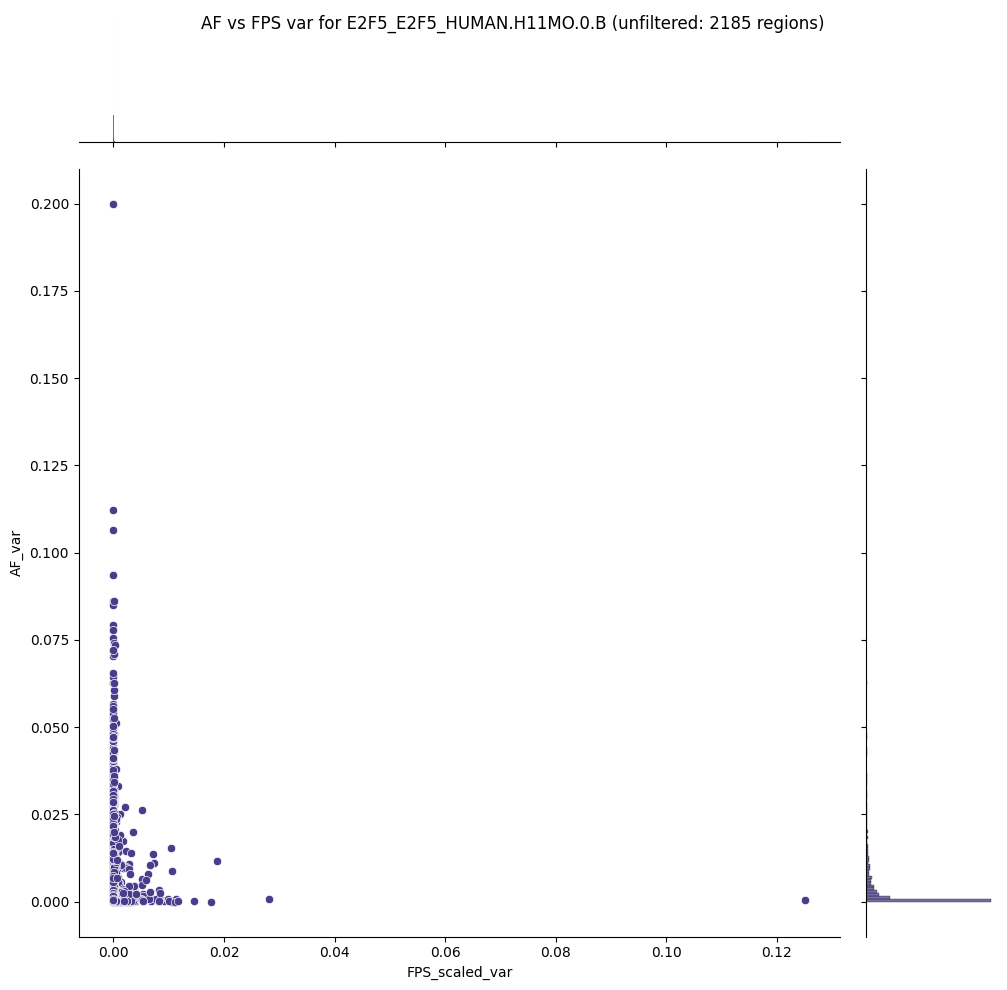

In [24]:
# plot the jointplot
g = sns.jointplot(data=afps_stats_ms_var, x="FPS_scaled_var", y="AF_var", height=10, ratio=5, color='darkslateblue' )
g.fig.suptitle(f'AF vs FPS var for {motif_id} (unfiltered: {len(afps_stats_ms_var)} regions)')
plt.show()

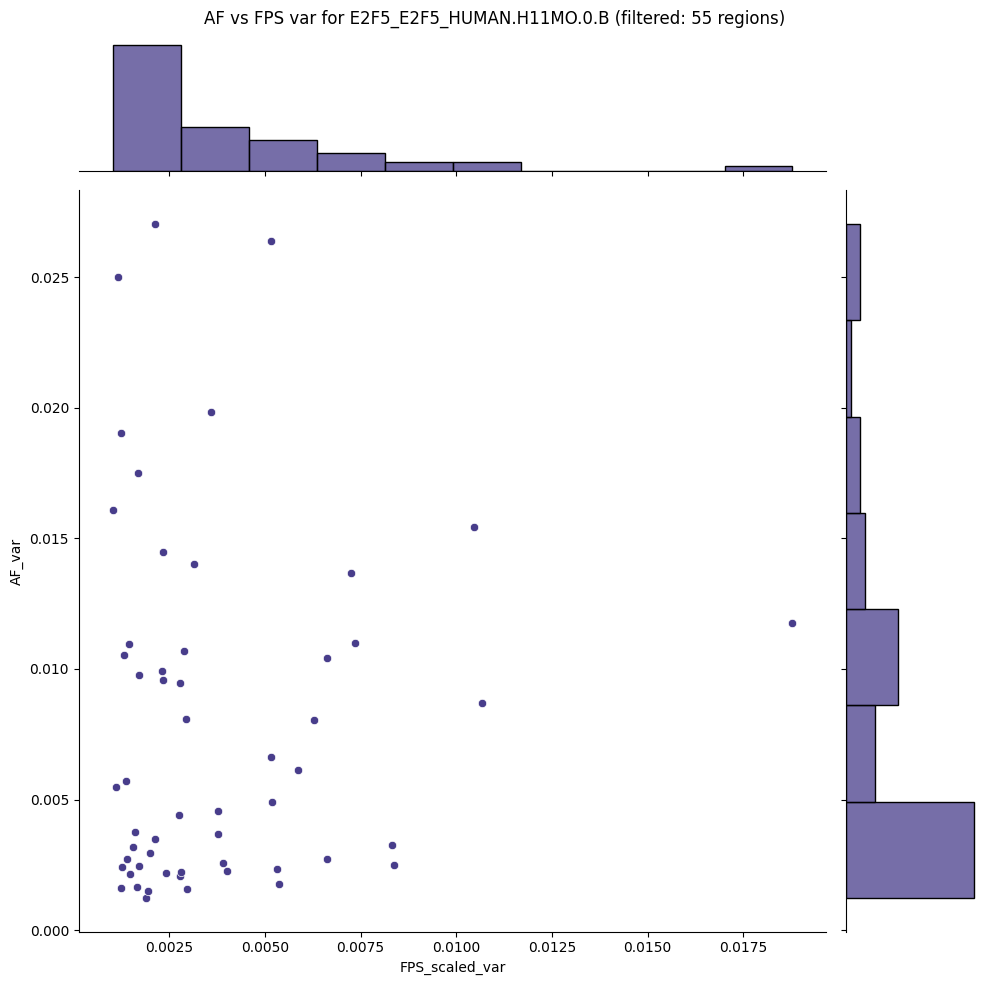

In [25]:
# plot the jointplot
g = sns.jointplot(data=test_df, x="FPS_scaled_var", y="AF_var", height=10, ratio=5, color='darkslateblue' )
g.fig.suptitle(f'AF vs FPS var for {motif_id} (filtered: {len(test_df)} regions)')
plt.tight_layout()
plt.show()

In [26]:
test_df.shape

(55, 2)

### Filtering Variant Sites (FPS)
From here on, it makes sense to filter out variant sites that has `FPS` value `== 0`. This means that the raw FPS values across subtypes are zero, i.e. there is no evidence of footprinting at all at these sites despite a TFBS matching a motif being present (assigned by TOBIAS).

In [27]:
afps_stats_mergesorted

region_id      sample_id        AF      FPS  FPS_scaled  \
5145         chr1:905473-905483   2GAMBDQ_norm  0.000000  0.14062    0.065892   
5146         chr1:905473-905483   98JKPD8_lumA  0.000000  0.10260    0.045183   
5147         chr1:905473-905483  ANAB5F7_basal  0.000000  0.12218    0.062660   
5148         chr1:905473-905483   PU24GB8_lumB  0.027778  0.12024    0.056307   
5149         chr1:905473-905483   S6R691V_her2  0.000000  0.13921    0.069304   
...                         ...            ...       ...      ...         ...   
10780  chrX:150849074-150849084   2GAMBDQ_norm  0.750000  0.20522    0.096162   
10781  chrX:150849074-150849084   98JKPD8_lumA  0.500000  0.34392    0.151456   
10782  chrX:150849074-150849084  ANAB5F7_basal  0.600000  0.07363    0.037761   
10783  chrX:150849074-150849084   PU24GB8_lumB  0.605263  0.24735    0.115831   
10784  chrX:150849074-150849084   S6R691V_her2  0.588235  0.35995    0.179197   

        FPS_var  FPS_scaled_var    AF_var  
5145   0.000245        0.000090  0.000154  
5146   0.000245        0.000090  0.000154  
5147   0.000245        0.000090  0.000154  
5148   0.000245        0.000090  0.000154  
5149   0.000245        0.000090  0.000154  
...         ...             ...       ...  
10780  0.013487        0.002941  0.008072  
10781  0.013487        0.002941  0.008072  
10782  0.013487        0.002941  0.008072  
10783  0.013487        0.002941  0.008072  
10784  0.013487        0.002941  0.008072  

[10925 rows x 8 columns]

In [28]:
# filter out unique region_id rows that have fps == 0 across the sample_ids
# group by 'region_id' first 
merged_filt = afps_stats_mergesorted.groupby('region_id').filter(lambda x: x['FPS'].sum() > 0)
merged_filt

region_id      sample_id        AF      FPS  FPS_scaled  \
5145         chr1:905473-905483   2GAMBDQ_norm  0.000000  0.14062    0.065892   
5146         chr1:905473-905483   98JKPD8_lumA  0.000000  0.10260    0.045183   
5147         chr1:905473-905483  ANAB5F7_basal  0.000000  0.12218    0.062660   
5148         chr1:905473-905483   PU24GB8_lumB  0.027778  0.12024    0.056307   
5149         chr1:905473-905483   S6R691V_her2  0.000000  0.13921    0.069304   
...                         ...            ...       ...      ...         ...   
10780  chrX:150849074-150849084   2GAMBDQ_norm  0.750000  0.20522    0.096162   
10781  chrX:150849074-150849084   98JKPD8_lumA  0.500000  0.34392    0.151456   
10782  chrX:150849074-150849084  ANAB5F7_basal  0.600000  0.07363    0.037761   
10783  chrX:150849074-150849084   PU24GB8_lumB  0.605263  0.24735    0.115831   
10784  chrX:150849074-150849084   S6R691V_her2  0.588235  0.35995    0.179197   

        FPS_var  FPS_scaled_var    AF_var  
5145   0.000245        0.000090  0.000154  
5146   0.000245        0.000090  0.000154  
5147   0.000245        0.000090  0.000154  
5148   0.000245        0.000090  0.000154  
5149   0.000245        0.000090  0.000154  
...         ...             ...       ...  
10780  0.013487        0.002941  0.008072  
10781  0.013487        0.002941  0.008072  
10782  0.013487        0.002941  0.008072  
10783  0.013487        0.002941  0.008072  
10784  0.013487        0.002941  0.008072  

[10755 rows x 8 columns]

In [29]:
# merged_filt[(merged_filt['FPS_cv'].isna() | merged_filt['FPS_qcd'].isna())]

We are not interested in footprints that carry no called variants so we can also filter out all rows with `AF == 0`, as these represent sites that are not variant at all. The only reason they are in the matrix is because during the raw data merging, these sites are retained when there is at least one subtype that has a non-zero AF value at that site, or non-zero FPS values at that site.

However, we would still be interested in sites with AF values not equal zero at least in one of the subtypes, so we do not want to filter out sites that have at least one non-zero AF value.

In [30]:
# filter out unique region_id rows that have AF == 0 in all subtypes (sample_id grouping)
# this has to be per group, so we need to groupby first
merged_filt_nozero = merged_filt.groupby('region_id').filter(lambda x: (x['AF'] != 0).any())
merged_filt_nozero

region_id      sample_id        AF      FPS  FPS_scaled  \
5145         chr1:905473-905483   2GAMBDQ_norm  0.000000  0.14062    0.065892   
5146         chr1:905473-905483   98JKPD8_lumA  0.000000  0.10260    0.045183   
5147         chr1:905473-905483  ANAB5F7_basal  0.000000  0.12218    0.062660   
5148         chr1:905473-905483   PU24GB8_lumB  0.027778  0.12024    0.056307   
5149         chr1:905473-905483   S6R691V_her2  0.000000  0.13921    0.069304   
...                         ...            ...       ...      ...         ...   
10780  chrX:150849074-150849084   2GAMBDQ_norm  0.750000  0.20522    0.096162   
10781  chrX:150849074-150849084   98JKPD8_lumA  0.500000  0.34392    0.151456   
10782  chrX:150849074-150849084  ANAB5F7_basal  0.600000  0.07363    0.037761   
10783  chrX:150849074-150849084   PU24GB8_lumB  0.605263  0.24735    0.115831   
10784  chrX:150849074-150849084   S6R691V_her2  0.588235  0.35995    0.179197   

        FPS_var  FPS_scaled_var    AF_var  
5145   0.000245        0.000090  0.000154  
5146   0.000245        0.000090  0.000154  
5147   0.000245        0.000090  0.000154  
5148   0.000245        0.000090  0.000154  
5149   0.000245        0.000090  0.000154  
...         ...             ...       ...  
10780  0.013487        0.002941  0.008072  
10781  0.013487        0.002941  0.008072  
10782  0.013487        0.002941  0.008072  
10783  0.013487        0.002941  0.008072  
10784  0.013487        0.002941  0.008072  

[10185 rows x 8 columns]

Now we can select unique `region_id`s that have at least one AF value in the subtype group that is equal to 0 AND the max AF value in the subtype group is more than 0.5. This is because for sites that have a called variant in at least one subtype, we are only interested in them if the called variant has AF of more than 0.5.

We first group the df by the unique values of column `region_id`, then we retain only regions whose max value of column `AF` per unique site is more than 0.5.

In [31]:
# for each unique region_id, find those that has AF == 0 in at least one subtype
# this has to be per group, so we need to groupby first
region_af_zero = merged_filt_nozero.groupby('region_id').filter(lambda x: (x['AF'] == 0).any())
region_af_zero

region_id      sample_id        AF      FPS  FPS_scaled  \
5145         chr1:905473-905483   2GAMBDQ_norm  0.000000  0.14062    0.065892   
5146         chr1:905473-905483   98JKPD8_lumA  0.000000  0.10260    0.045183   
5147         chr1:905473-905483  ANAB5F7_basal  0.000000  0.12218    0.062660   
5148         chr1:905473-905483   PU24GB8_lumB  0.027778  0.12024    0.056307   
5149         chr1:905473-905483   S6R691V_her2  0.000000  0.13921    0.069304   
...                         ...            ...       ...      ...         ...   
10775  chrX:147508113-147508123   2GAMBDQ_norm  0.000000  0.01465    0.006865   
10776  chrX:147508113-147508123   98JKPD8_lumA  0.000000  0.00810    0.003567   
10777  chrX:147508113-147508123  ANAB5F7_basal  0.045455  0.00633    0.003246   
10778  chrX:147508113-147508123   PU24GB8_lumB  0.000000  0.00629    0.002946   
10779  chrX:147508113-147508123   S6R691V_her2  0.000000  0.00697    0.003470   

        FPS_var  FPS_scaled_var    AF_var  
5145   0.000245        0.000090  0.000154  
5146   0.000245        0.000090  0.000154  
5147   0.000245        0.000090  0.000154  
5148   0.000245        0.000090  0.000154  
5149   0.000245        0.000090  0.000154  
...         ...             ...       ...  
10775  0.000012        0.000003  0.000413  
10776  0.000012        0.000003  0.000413  
10777  0.000012        0.000003  0.000413  
10778  0.000012        0.000003  0.000413  
10779  0.000012        0.000003  0.000413  

[6950 rows x 8 columns]

In [32]:
# then find the max AF value for each region_id and add to a new column called 'max_AF'
df = region_af_zero.groupby('region_id').agg({'AF': 'max'}).rename(columns={'AF': 'max_AF'}).reset_index()
max_af = df.reindex(index=index_natsorted(df['region_id']))
max_af

region_id    max_AF
640         chr1:905473-905483  0.027778
526       chr1:1020750-1020760  0.062500
617       chr1:3432506-3432516  0.166667
625       chr1:3948502-3948512  0.181818
629       chr1:5274704-5274714  0.250000
...                        ...       ...
1365  chrX:115338019-115338029  0.029412
1366  chrX:118300271-118300281  0.071429
1367  chrX:119211181-119211191  0.093750
1368  chrX:139342109-139342119  0.066667
1369  chrX:147508113-147508123  0.045455

[1390 rows x 2 columns]

In [33]:
# now return a boolean mask for regions that have max_AF <= 0.5
mask = max_af['max_AF'] <= 0.5
# sum here counts the number of True values in the mask
mask.sum()

1379

Now we can filter the merged dataframes such that rows that have `region_id` in the Boolean-masked `max_af` <= 0.5 dataframe will be discarded (so we retain only `region_id` rows that have `max_af` > 0.5).

In [34]:
# this is done by subsetting the long dataframe with an expression that makes use of isin() method on the max_af dataframe masked by the boolean series, and then taking the inverse of the expression using ~
merged_filt_nolowaf = merged_filt_nozero[~(merged_filt_nozero['region_id'].isin(max_af[mask]['region_id']))]
merged_filt_nolowaf

region_id      sample_id        AF      FPS  FPS_scaled  \
5160         chr1:925405-925415   2GAMBDQ_norm  1.000000  0.05586    0.026175   
5161         chr1:925405-925415   98JKPD8_lumA  1.000000  0.09540    0.042012   
5162         chr1:925405-925415  ANAB5F7_basal  0.730769  0.03670    0.018821   
5163         chr1:925405-925415   PU24GB8_lumB  0.769231  0.05082    0.023798   
5164         chr1:925405-925415   S6R691V_her2  0.730769  0.09011    0.044860   
...                         ...            ...       ...      ...         ...   
10780  chrX:150849074-150849084   2GAMBDQ_norm  0.750000  0.20522    0.096162   
10781  chrX:150849074-150849084   98JKPD8_lumA  0.500000  0.34392    0.151456   
10782  chrX:150849074-150849084  ANAB5F7_basal  0.600000  0.07363    0.037761   
10783  chrX:150849074-150849084   PU24GB8_lumB  0.605263  0.24735    0.115831   
10784  chrX:150849074-150849084   S6R691V_her2  0.588235  0.35995    0.179197   

        FPS_var  FPS_scaled_var    AF_var  
5160   0.000659        0.000134  0.019970  
5161   0.000659        0.000134  0.019970  
5162   0.000659        0.000134  0.019970  
5163   0.000659        0.000134  0.019970  
5164   0.000659        0.000134  0.019970  
...         ...             ...       ...  
10780  0.013487        0.002941  0.008072  
10781  0.013487        0.002941  0.008072  
10782  0.013487        0.002941  0.008072  
10783  0.013487        0.002941  0.008072  
10784  0.013487        0.002941  0.008072  

[3290 rows x 8 columns]

In [35]:
# now filter out the rows with AF == 0 on the merge_filt dataframe
merged_filt_nozeroaf = merged_filt_nozero[~(merged_filt_nozero['region_id'].isin(max_af['region_id']))]
merged_filt_nozeroaf

region_id      sample_id        AF      FPS  FPS_scaled  \
5160         chr1:925405-925415   2GAMBDQ_norm  1.000000  0.05586    0.026175   
5161         chr1:925405-925415   98JKPD8_lumA  1.000000  0.09540    0.042012   
5162         chr1:925405-925415  ANAB5F7_basal  0.730769  0.03670    0.018821   
5163         chr1:925405-925415   PU24GB8_lumB  0.769231  0.05082    0.023798   
5164         chr1:925405-925415   S6R691V_her2  0.730769  0.09011    0.044860   
...                         ...            ...       ...      ...         ...   
10780  chrX:150849074-150849084   2GAMBDQ_norm  0.750000  0.20522    0.096162   
10781  chrX:150849074-150849084   98JKPD8_lumA  0.500000  0.34392    0.151456   
10782  chrX:150849074-150849084  ANAB5F7_basal  0.600000  0.07363    0.037761   
10783  chrX:150849074-150849084   PU24GB8_lumB  0.605263  0.24735    0.115831   
10784  chrX:150849074-150849084   S6R691V_her2  0.588235  0.35995    0.179197   

        FPS_var  FPS_scaled_var    AF_var  
5160   0.000659        0.000134  0.019970  
5161   0.000659        0.000134  0.019970  
5162   0.000659        0.000134  0.019970  
5163   0.000659        0.000134  0.019970  
5164   0.000659        0.000134  0.019970  
...         ...             ...       ...  
10780  0.013487        0.002941  0.008072  
10781  0.013487        0.002941  0.008072  
10782  0.013487        0.002941  0.008072  
10783  0.013487        0.002941  0.008072  
10784  0.013487        0.002941  0.008072  

[3235 rows x 8 columns]

In [36]:
# save the unique region_id rows where AF == 0 in at least one subtype to file just in case
atleast_one_zero_af = merged_filt_nozero[merged_filt_nozero['region_id'].isin(max_af['region_id'])]
atleast_one_zero_af

region_id      sample_id        AF      FPS  FPS_scaled  \
5145         chr1:905473-905483   2GAMBDQ_norm  0.000000  0.14062    0.065892   
5146         chr1:905473-905483   98JKPD8_lumA  0.000000  0.10260    0.045183   
5147         chr1:905473-905483  ANAB5F7_basal  0.000000  0.12218    0.062660   
5148         chr1:905473-905483   PU24GB8_lumB  0.027778  0.12024    0.056307   
5149         chr1:905473-905483   S6R691V_her2  0.000000  0.13921    0.069304   
...                         ...            ...       ...      ...         ...   
10775  chrX:147508113-147508123   2GAMBDQ_norm  0.000000  0.01465    0.006865   
10776  chrX:147508113-147508123   98JKPD8_lumA  0.000000  0.00810    0.003567   
10777  chrX:147508113-147508123  ANAB5F7_basal  0.045455  0.00633    0.003246   
10778  chrX:147508113-147508123   PU24GB8_lumB  0.000000  0.00629    0.002946   
10779  chrX:147508113-147508123   S6R691V_her2  0.000000  0.00697    0.003470   

        FPS_var  FPS_scaled_var    AF_var  
5145   0.000245        0.000090  0.000154  
5146   0.000245        0.000090  0.000154  
5147   0.000245        0.000090  0.000154  
5148   0.000245        0.000090  0.000154  
5149   0.000245        0.000090  0.000154  
...         ...             ...       ...  
10775  0.000012        0.000003  0.000413  
10776  0.000012        0.000003  0.000413  
10777  0.000012        0.000003  0.000413  
10778  0.000012        0.000003  0.000413  
10779  0.000012        0.000003  0.000413  

[6950 rows x 8 columns]

### Filtering Variant Sites (AF)
Now we can calculate the median for AF values to append to the merged, filtered longform dataframe.

In [37]:
# copy the filtered dataframe
mf_df = merged_filt_nozeroaf.copy()
mf_df = mf_df.reset_index(drop=True)
# # calculate AF mean per region_id
# mf_df['AF_mean'] = mf_df.groupby('region_id')['AF'].transform('mean')
mf_df

region_id      sample_id        AF      FPS  FPS_scaled  \
0           chr1:925405-925415   2GAMBDQ_norm  1.000000  0.05586    0.026175   
1           chr1:925405-925415   98JKPD8_lumA  1.000000  0.09540    0.042012   
2           chr1:925405-925415  ANAB5F7_basal  0.730769  0.03670    0.018821   
3           chr1:925405-925415   PU24GB8_lumB  0.769231  0.05082    0.023798   
4           chr1:925405-925415   S6R691V_her2  0.730769  0.09011    0.044860   
...                        ...            ...       ...      ...         ...   
3230  chrX:150849074-150849084   2GAMBDQ_norm  0.750000  0.20522    0.096162   
3231  chrX:150849074-150849084   98JKPD8_lumA  0.500000  0.34392    0.151456   
3232  chrX:150849074-150849084  ANAB5F7_basal  0.600000  0.07363    0.037761   
3233  chrX:150849074-150849084   PU24GB8_lumB  0.605263  0.24735    0.115831   
3234  chrX:150849074-150849084   S6R691V_her2  0.588235  0.35995    0.179197   

       FPS_var  FPS_scaled_var    AF_var  
0     0.000659        0.000134  0.019970  
1     0.000659        0.000134  0.019970  
2     0.000659        0.000134  0.019970  
3     0.000659        0.000134  0.019970  
4     0.000659        0.000134  0.019970  
...        ...             ...       ...  
3230  0.013487        0.002941  0.008072  
3231  0.013487        0.002941  0.008072  
3232  0.013487        0.002941  0.008072  
3233  0.013487        0.002941  0.008072  
3234  0.013487        0.002941  0.008072  

[3235 rows x 8 columns]

Let's visualize the AF distribution for each variant site.

In [38]:
dutchfield = ["#e60049", "#0bb4ff", "#87bc45", "#ef9b20", "#b33dc6"]

springpastel = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a"] 

In [39]:
# plot violin plot for AF on the filtered dataframe
# plt.figure(figsize=(10, 10), dpi=300)
# sns.violinplot(x='region_id', y='AF', data=mf_df, color='lightgray', inner='quartile', linecolor='black', linewidth=0.5)
# plt.xticks(rotation=90, fontsize=2)
# sns.stripplot(x='region_id', y='AF', data=mf_df, hue='sample_id', size=2.5, jitter=True, palette='deep')


# # plot legend outside of the plot
# plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, markerscale=2, fontsize=10)
# plt.xlabel(f'{motif_id} TF binding sites with allelic variants', fontsize=8)
# plt.ylabel('Allele frequency (AF)', fontsize=8)
# plt.show()

~~Plotting the whole data makes the plot look very busy. We can split the data into 2 groups: 'high AF' and 'low AF'. We will define 'high AF' as `AF_median` > 0.5, and 'low AF' as `AF_median` <= 0.5.~~ 

Let's not just filter by `AF_median`, but instead filter for `region_id` in which none of the AF values are < 0.5.

In [40]:
# to ensure that each unique region_id is retained as a group of subtype rows, we need to filter after grouping per region_id
# high_af = mf_df.groupby('region_id').filter(lambda x: (x['AF_median'] > 0.5).any())
high_af = mf_df.groupby('region_id').filter(lambda x: (x['AF'] > 0.5).all())
high_af

region_id      sample_id        AF      FPS  FPS_scaled  \
0         chr1:925405-925415   2GAMBDQ_norm  1.000000  0.05586    0.026175   
1         chr1:925405-925415   98JKPD8_lumA  1.000000  0.09540    0.042012   
2         chr1:925405-925415  ANAB5F7_basal  0.730769  0.03670    0.018821   
3         chr1:925405-925415   PU24GB8_lumB  0.769231  0.05082    0.023798   
4         chr1:925405-925415   S6R691V_her2  0.730769  0.09011    0.044860   
...                      ...            ...       ...      ...         ...   
3200  chrX:34275969-34275979   2GAMBDQ_norm  0.857143  0.02658    0.012455   
3201  chrX:34275969-34275979   98JKPD8_lumA  0.611111  0.03378    0.014876   
3202  chrX:34275969-34275979  ANAB5F7_basal  0.888889  0.01175    0.006026   
3203  chrX:34275969-34275979   PU24GB8_lumB  1.000000  0.02894    0.013552   
3204  chrX:34275969-34275979   S6R691V_her2  0.750000  0.03548    0.017663   

       FPS_var  FPS_scaled_var    AF_var  
0     0.000659        0.000134  0.019970  
1     0.000659        0.000134  0.019970  
2     0.000659        0.000134  0.019970  
3     0.000659        0.000134  0.019970  
4     0.000659        0.000134  0.019970  
...        ...             ...       ...  
3200  0.000088        0.000019  0.021762  
3201  0.000088        0.000019  0.021762  
3202  0.000088        0.000019  0.021762  
3203  0.000088        0.000019  0.021762  
3204  0.000088        0.000019  0.021762  

[635 rows x 8 columns]

In [41]:
# low_af = mf_df.groupby('region_id').filter(lambda x: (x['AF_median'] <= 0.5).any())
low_af = mf_df.groupby('region_id').filter(lambda x: (x['AF'] <= 0.5).any())
low_af

region_id      sample_id        AF      FPS  FPS_scaled  \
5         chr1:1130413-1130423   2GAMBDQ_norm  0.250000  0.15151    0.070994   
6         chr1:1130413-1130423   98JKPD8_lumA  0.181818  0.11471    0.050516   
7         chr1:1130413-1130423  ANAB5F7_basal  0.062500  0.04786    0.024545   
8         chr1:1130413-1130423   PU24GB8_lumB  0.131579  0.14384    0.067359   
9         chr1:1130413-1130423   S6R691V_her2  0.147059  0.11338    0.056445   
...                        ...            ...       ...      ...         ...   
3230  chrX:150849074-150849084   2GAMBDQ_norm  0.750000  0.20522    0.096162   
3231  chrX:150849074-150849084   98JKPD8_lumA  0.500000  0.34392    0.151456   
3232  chrX:150849074-150849084  ANAB5F7_basal  0.600000  0.07363    0.037761   
3233  chrX:150849074-150849084   PU24GB8_lumB  0.605263  0.24735    0.115831   
3234  chrX:150849074-150849084   S6R691V_her2  0.588235  0.35995    0.179197   

       FPS_var  FPS_scaled_var    AF_var  
5     0.001668        0.000338  0.004728  
6     0.001668        0.000338  0.004728  
7     0.001668        0.000338  0.004728  
8     0.001668        0.000338  0.004728  
9     0.001668        0.000338  0.004728  
...        ...             ...       ...  
3230  0.013487        0.002941  0.008072  
3231  0.013487        0.002941  0.008072  
3232  0.013487        0.002941  0.008072  
3233  0.013487        0.002941  0.008072  
3234  0.013487        0.002941  0.008072  

[2600 rows x 8 columns]

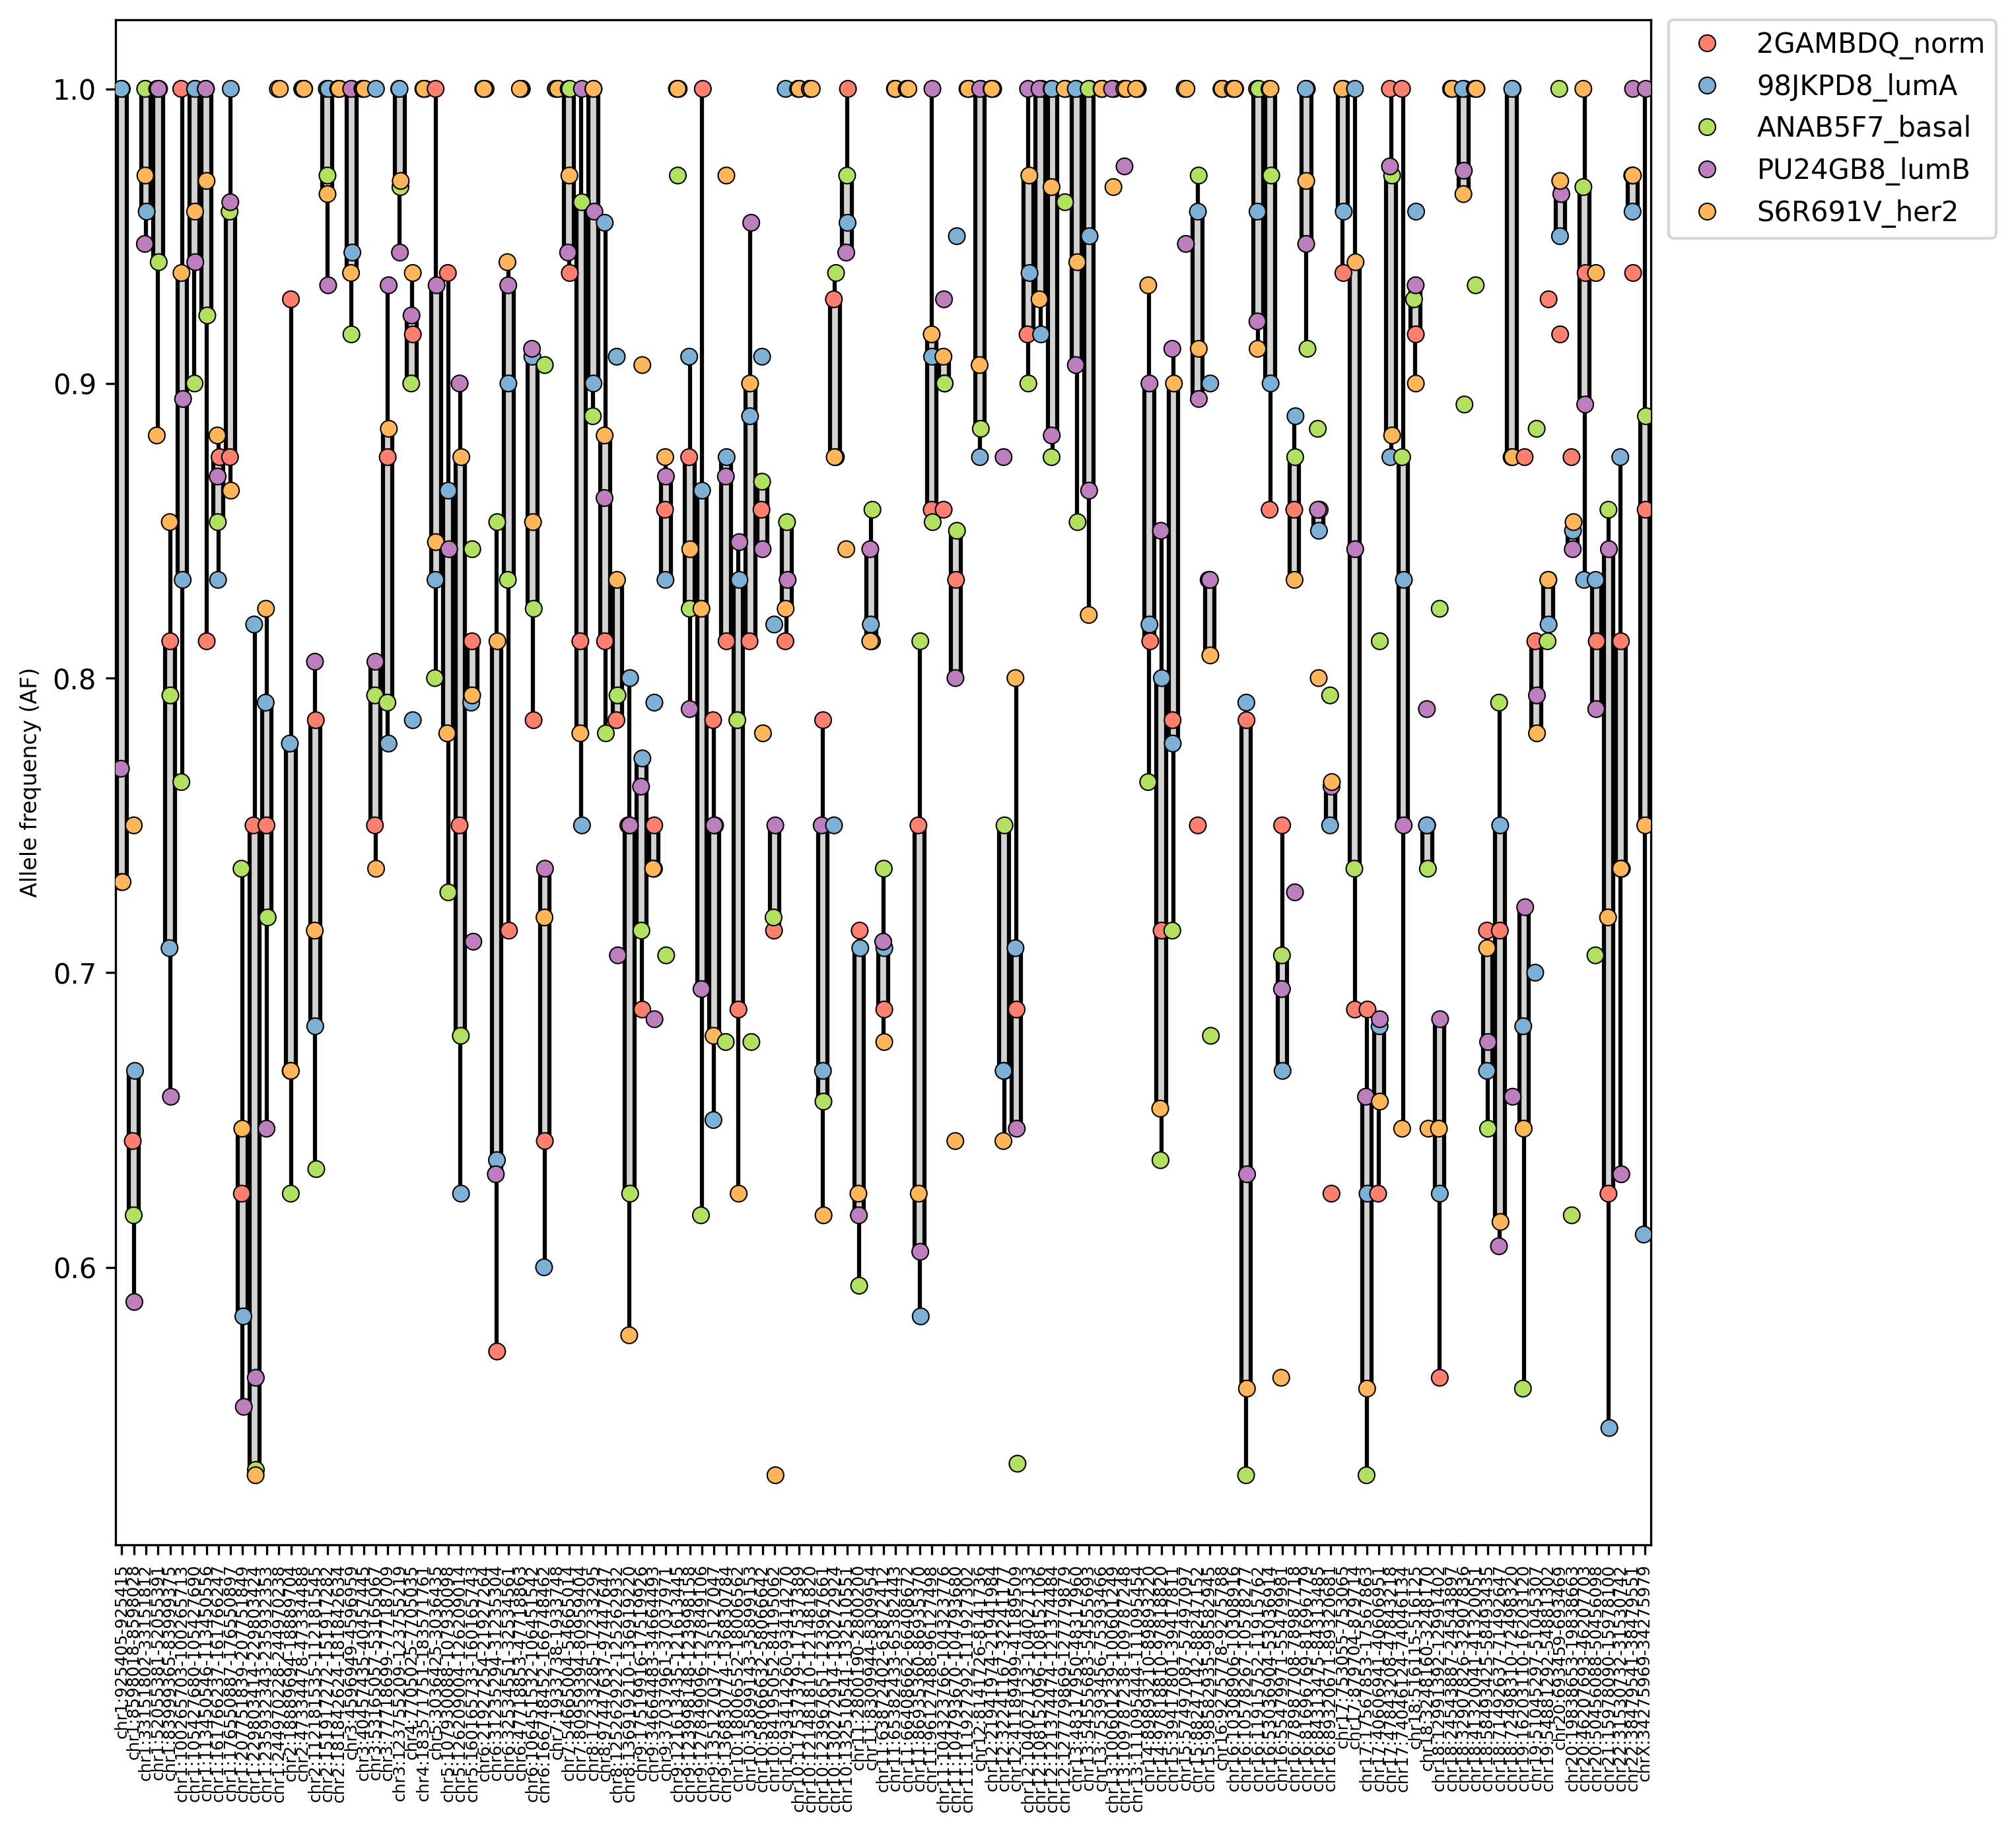

In [42]:
fig_tuple = plt.subplots(figsize=(10, 10), dpi=300, num=1, clear=True)
fig, ax = fig_tuple
# plot violin plot for high AF set
sns.boxplot(x='region_id', y='AF', data=high_af, color='lightgray', linecolor='black', linewidth=1.5, showfliers=False, ax=ax)
plt.xticks(rotation=90, fontsize=6)
sns.stripplot(x='region_id', y='AF', data=high_af, hue='sample_id', size=6, jitter=True, palette=springpastel, linewidth=0.5, edgecolor='black', ax=ax)
# plot legend outside of the plot
plt.legend(bbox_to_anchor=(1.225, 1),borderaxespad=0, markerscale=1, fontsize=10)
plt.xlabel('')
plt.ylabel('Allele frequency (AF)', fontsize=8)
plt.show()


In [43]:
# plot violin plot for low AF set
# plt.figure(figsize=(10, 10), dpi=300)
# sns.violinplot(x='region_id', y='AF', data=low_af, color='lightgray', inner='quartile', linecolor='black', linewidth=0.5)
# plt.xticks(rotation=90, fontsize=2)
# sns.stripplot(x='region_id', y='AF', data=low_af, hue='sample_id', size=2.5, jitter=True, palette='deep')


# # plot legend outside of the plot
# plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, markerscale=2, fontsize=10)
# plt.xlabel(f'{motif_id} TF binding sites with allelic variants (median AF <= 0.5)', fontsize=8)
# plt.ylabel('Allele frequency (AF)', fontsize=8)
# plt.show()

While we are at it, let's plot the regions where there was at least one subtype with AF value == 0, which is filtered and saved into a file above.

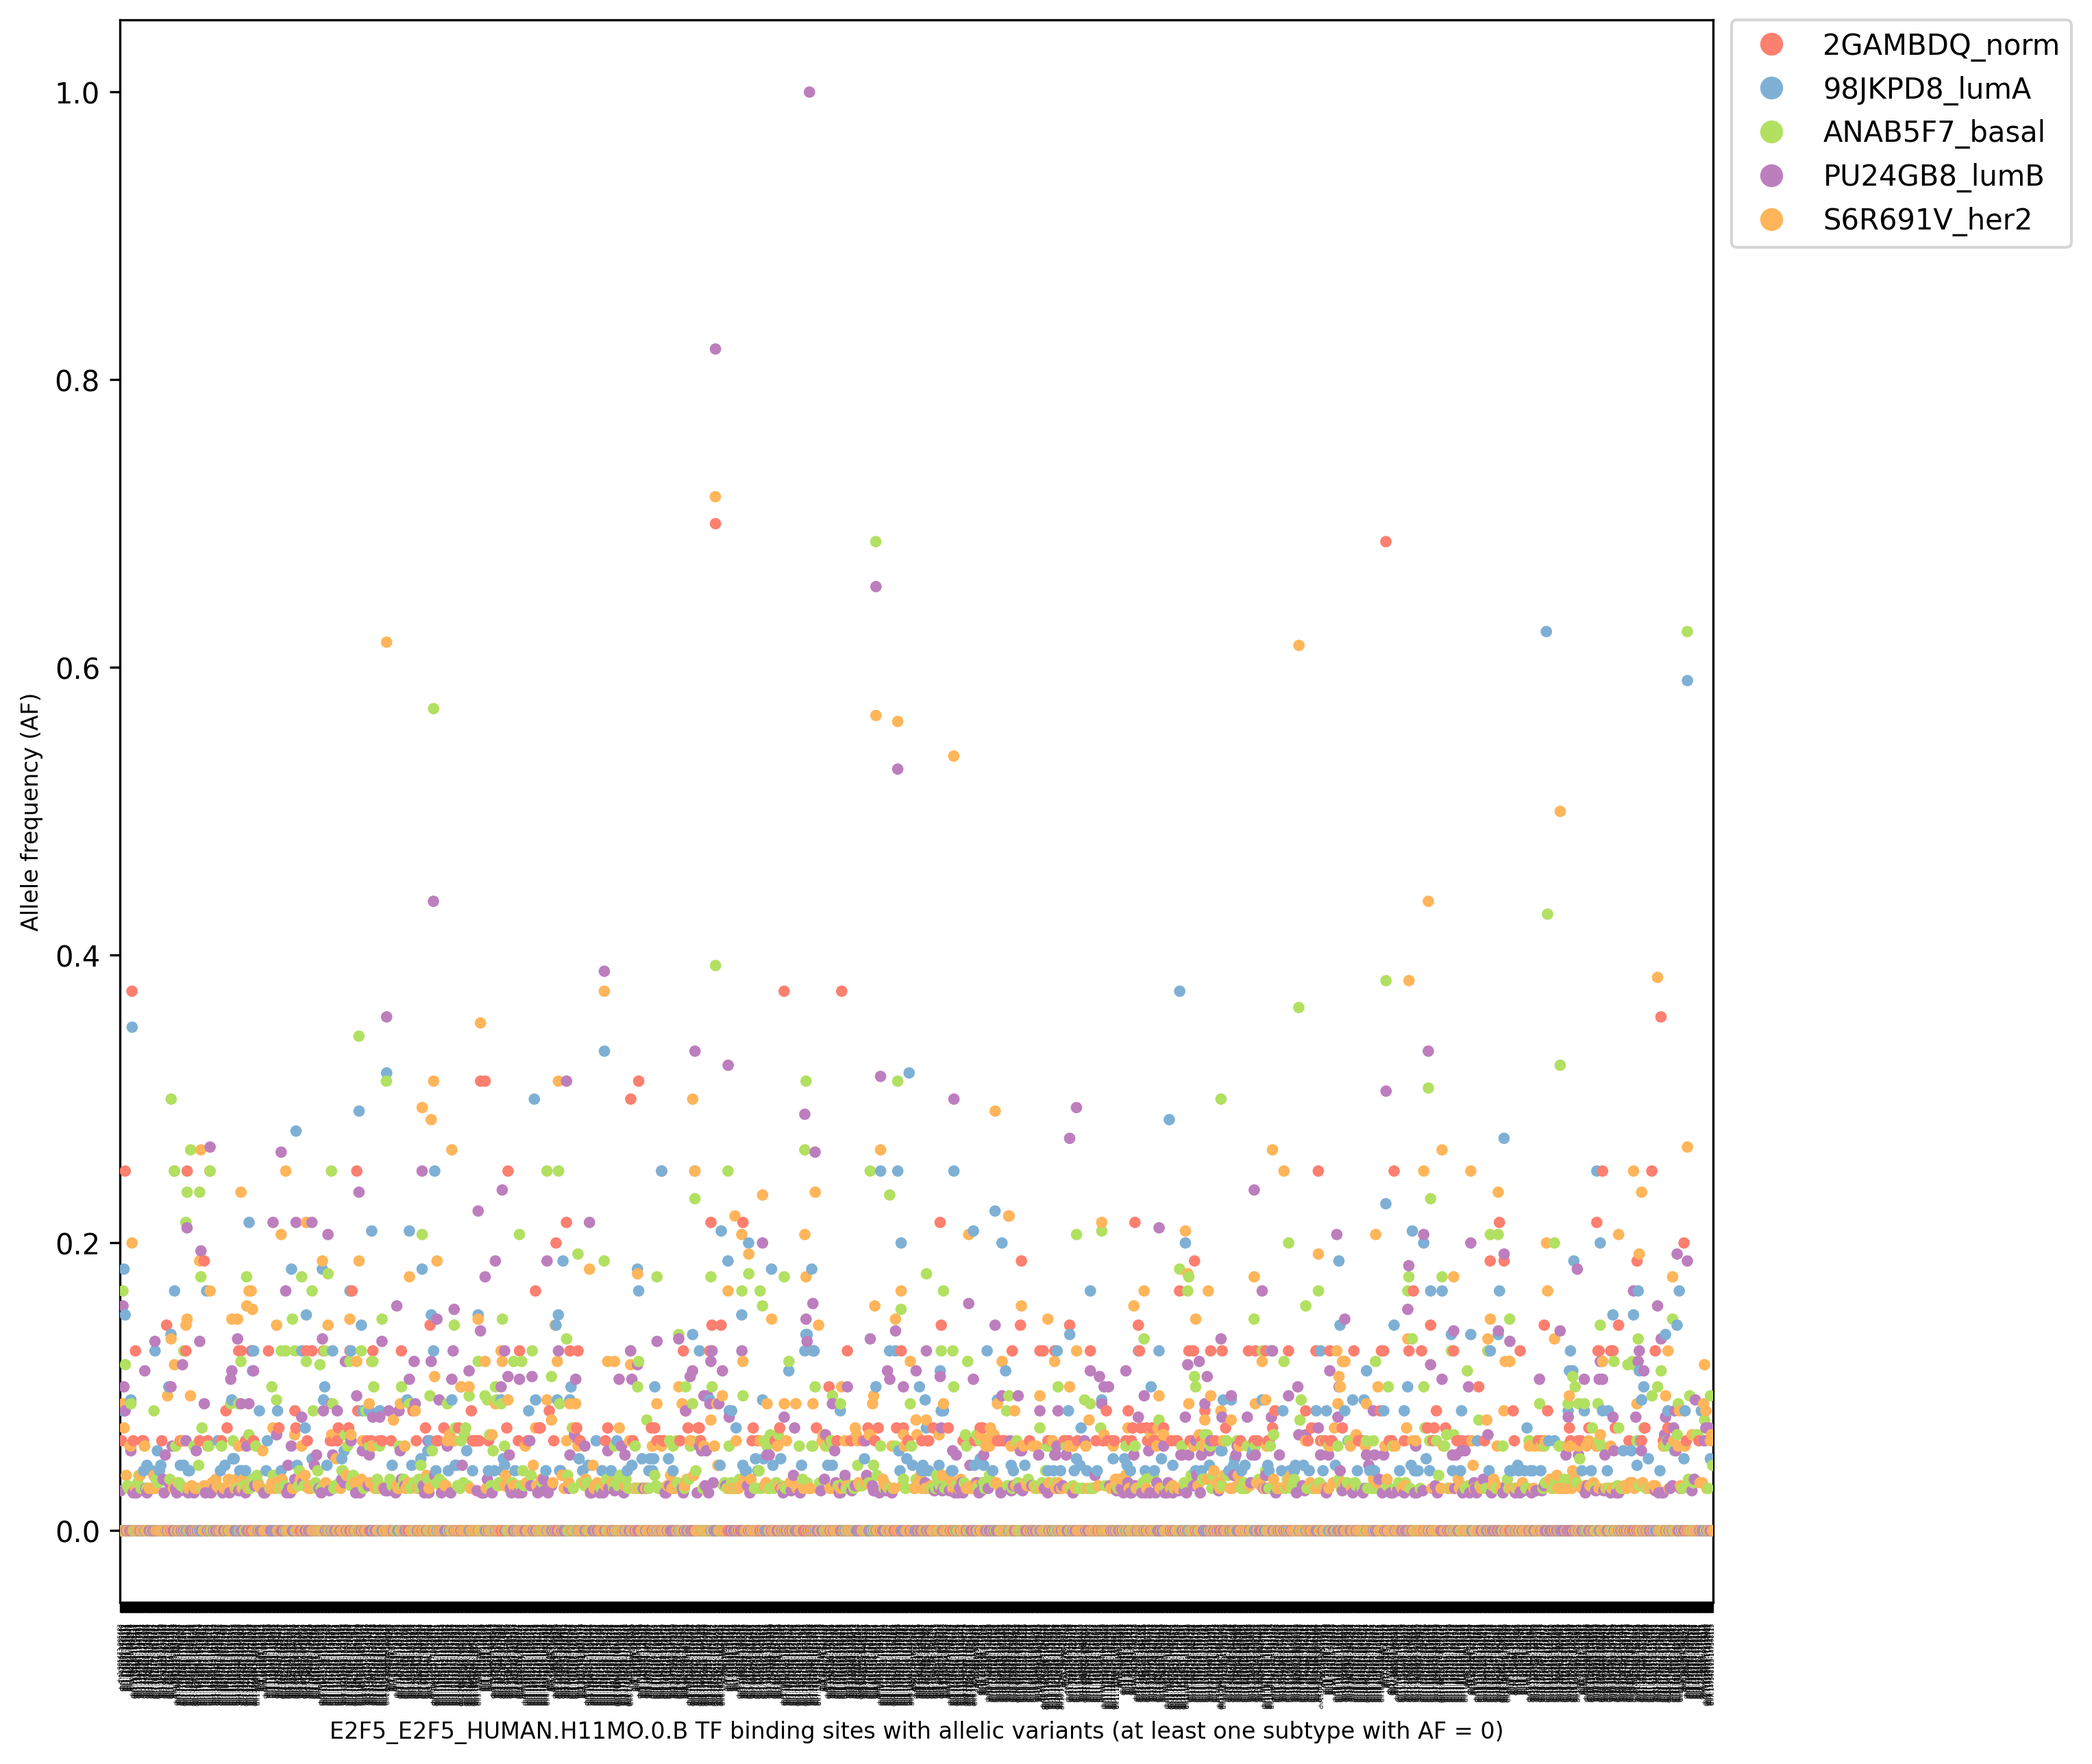

In [44]:
# plot violin plot for sites with at least one subtype with AF == 0
plt.figure(figsize=(10, 10), dpi=300)
# sns.boxplot(x='region_id', y='AF', data=atleast_one_zero_af, color='gainsboro', linecolor='black', linewidth=1.5, showfliers=False)
plt.xticks(rotation=90, fontsize=2)
sns.stripplot(x='region_id', y='AF', data=atleast_one_zero_af, hue='sample_id', size=4, jitter=True, palette=springpastel)


# plot legend outside of the plot
plt.legend(bbox_to_anchor=(1.225, 1),borderaxespad=0, markerscale=2, fontsize=10)
plt.xlabel(f'{motif_id} TF binding sites with allelic variants (at least one subtype with AF = 0)', fontsize=8)
plt.ylabel('Allele frequency (AF)', fontsize=8)

plt.show()

No clear pattern of enrichment of a specific subtype with high AF compared to the rest can be seen. We can use the subset of these to plot the distribution of the associated FPS values (unscaled). 

In [45]:
# fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=300, num=1, clear=True)
# sns.boxplot(x='region_id', y='AF', data=high_af, color='lightgray', linecolor='black', linewidth=1.5, showfliers=False)
# plt.xticks(rotation=90, fontsize=6)
# sns.stripplot(x='region_id', y='AF', data=high_af, hue='sample_id', size=6, jitter=True, palette=springpastel, linewidth=0.5, edgecolor='black')
# # plot legend outside of the plot
# plt.legend(bbox_to_anchor=(1.225, 1),borderaxespad=0, markerscale=1, fontsize=10)
# plt.xlabel('')
# plt.ylabel('Allele frequency (AF)', fontsize=8)

# sns.boxplot(x='region_id', y='AF', data=high_af, color='lightgray', linecolor='black', linewidth=1.5, showfliers=False, ax=ax[0])
# ax[0].tick_params(axis='x', rotation=90, labelsize=6)
# sns.stripplot(x='region_id', y='AF', data=high_af, hue='sample_id', size=6, jitter=True, palette=springpastel, linewidth=0.5, edgecolor='black', ax=ax[0])
# # plot legend outside of the plot
# ax[0].legend(bbox_to_anchor=(1.225, 1),borderaxespad=0, markerscale=1, fontsize=10)
# ax[0].set_xlabel('')
# ax[0].set_ylabel('Allele frequency (AF)', fontsize=8)

# # then plot the scaled FPS values for these sites
# # plt.subplot(2, 1, 2)
# # sns.boxplot(x='region_id', y='FPS_scaled', data=high_af, color='white', linecolor='black', linewidth=1.5, showfliers=False)
# # plt.xticks(rotation=90, fontsize=6)
# # sns.stripplot(x='region_id', y='FPS_scaled', data=high_af, hue='sample_id', size=6, jitter=True, palette=springpastel, legend=False, linewidth=0.5, edgecolor='black')
# # plt.xlabel(f'{motif_id} TF binding sites with allelic variants (at least one subtype with AF = 0)', fontsize=10)
# # plt.ylabel(f'Footprint scores (FPS) (min-max scaled)', fontsize=8)
# # plt.subplots_adjust(hspace=0.6)
# # plt.show()

# sns.boxplot(x='region_id', y='FPS_scaled', data=high_af, color='white', linecolor='black', linewidth=1.5, showfliers=False, ax=ax[1])
# ax[1].tick_params(axis='x', rotation=90, labelsize=6)
# sns.stripplot(x='region_id', y='FPS_scaled', data=high_af, hue='sample_id', size=6, jitter=True, palette=springpastel, legend=False, linewidth=0.5, edgecolor='black', ax=ax[1])
# ax[1].set_xlabel(f'{motif_id} TF binding sites with allelic variants (at least one subtype with AF = 0)', fontsize=10)
# ax[1].set_ylabel(f'Footprint scores (FPS) (min-max scaled)', fontsize=8)

# plt.subplots_adjust(hspace=0.6)
# plt.show()

Some cancer subtypes appear to not have alternative alleles in certain sites but there is barely any pattern of enrichment in FPS values for any specific subtype.

What is the range of FPS variance in the subset dataframe?

In [46]:
high_af[['FPS_scaled_var', 'AF_var']].describe()

FPS_scaled_var      AF_var
count    6.350000e+02  635.000000
mean     3.486108e-04    0.005244
std      9.050190e-04    0.005475
min      2.684938e-07    0.000000
25%      4.768179e-06    0.000683
50%      1.861737e-05    0.003836
75%      1.769064e-04    0.007752
max      5.369647e-03    0.022249

Let's now apply thresholding onto the FPS scaled data to denoise the dataset even more. There are two strategies:

1. Thresholding by computing the outlier threshold using the IQR method on `FPS_scaled_var` values.This means we are only keeping regions that show extreme variance in FPS values across subtypes.
2. Thresholding by computing the median of `FPS_scaled` values across subtypes and keeping only regions that have such value above the median at least in one subtype. 

#### STRATEGY 1: IQR Method

In [47]:
# STRATEGY 1: subset high_af for sites with FPS_scaled_var > 75th percentile + 1.5 * IQR
iqr = high_af['FPS_scaled_var'].quantile(q=0.75) - high_af['FPS_scaled_var'].quantile(q=0.25)
high_af_fps_outliers = high_af[high_af['FPS_scaled_var'] > high_af['FPS_scaled_var'].quantile(q=0.75) + (1.5 * iqr)]
high_af_fps_outliers

region_id      sample_id        AF      FPS  FPS_scaled  \
210   chr1:161766237-161766247   2GAMBDQ_norm  0.875000  0.76865    0.360174   
211   chr1:161766237-161766247   98JKPD8_lumA  0.833333  0.86762    0.382084   
212   chr1:161766237-161766247  ANAB5F7_basal  0.852941  0.58857    0.301846   
213   chr1:161766237-161766247   PU24GB8_lumB  0.868421  0.65888    0.308547   
214   chr1:161766237-161766247   S6R691V_her2  0.882353  0.48283    0.240372   
...                        ...            ...       ...      ...         ...   
3000   chr20:19838653-19838663   2GAMBDQ_norm  0.875000  0.01821    0.008533   
3001   chr20:19838653-19838663   98JKPD8_lumA  0.850000  0.01684    0.007416   
3002   chr20:19838653-19838663  ANAB5F7_basal  0.617647  0.11351    0.058213   
3003   chr20:19838653-19838663   PU24GB8_lumB  0.843750  0.01412    0.006612   
3004   chr20:19838653-19838663   S6R691V_her2  0.852941  0.01385    0.006895   

       FPS_var  FPS_scaled_var    AF_var  
210   0.022629        0.003065  0.000382  
211   0.022629        0.003065  0.000382  
212   0.022629        0.003065  0.000382  
213   0.022629        0.003065  0.000382  
214   0.022629        0.003065  0.000382  
...        ...             ...       ...  
3000  0.001915        0.000518  0.011446  
3001  0.001915        0.000518  0.011446  
3002  0.001915        0.000518  0.011446  
3003  0.001915        0.000518  0.011446  
3004  0.001915        0.000518  0.011446  

[100 rows x 8 columns]

In [48]:
# before discarding, grab all the regions where AF_var == 0; as we already filter out AF == 0, this would return regions where all subtypes have AF == 1, hence zero variance
# af_var_one = high_af_fps_outliers[high_af_fps_outliers['AF_var'] == 0]
# save to file
# af_var_one.to_csv(f'/home/msazizan/hyperspace/gatk-workflow/plotting/output-data/AF-FPS_regionsorted_full_longtable/{motif_id}_afps_longtable_raw_af_one_across_subtypes.tsv', sep='\t', index=False)

In [49]:
# and then discard sites if it has AF_var == 0 (i.e. all subtypes have AF == 1, as we already filter out raw AF == 0)
high_nzaf_outliers = high_af_fps_outliers[high_af_fps_outliers['AF_var'] != 0]
high_nzaf_outliers

region_id      sample_id        AF      FPS  FPS_scaled  \
210   chr1:161766237-161766247   2GAMBDQ_norm  0.875000  0.76865    0.360174   
211   chr1:161766237-161766247   98JKPD8_lumA  0.833333  0.86762    0.382084   
212   chr1:161766237-161766247  ANAB5F7_basal  0.852941  0.58857    0.301846   
213   chr1:161766237-161766247   PU24GB8_lumB  0.868421  0.65888    0.308547   
214   chr1:161766237-161766247   S6R691V_her2  0.882353  0.48283    0.240372   
...                        ...            ...       ...      ...         ...   
3000   chr20:19838653-19838663   2GAMBDQ_norm  0.875000  0.01821    0.008533   
3001   chr20:19838653-19838663   98JKPD8_lumA  0.850000  0.01684    0.007416   
3002   chr20:19838653-19838663  ANAB5F7_basal  0.617647  0.11351    0.058213   
3003   chr20:19838653-19838663   PU24GB8_lumB  0.843750  0.01412    0.006612   
3004   chr20:19838653-19838663   S6R691V_her2  0.852941  0.01385    0.006895   

       FPS_var  FPS_scaled_var    AF_var  
210   0.022629        0.003065  0.000382  
211   0.022629        0.003065  0.000382  
212   0.022629        0.003065  0.000382  
213   0.022629        0.003065  0.000382  
214   0.022629        0.003065  0.000382  
...        ...             ...       ...  
3000  0.001915        0.000518  0.011446  
3001  0.001915        0.000518  0.011446  
3002  0.001915        0.000518  0.011446  
3003  0.001915        0.000518  0.011446  
3004  0.001915        0.000518  0.011446  

[80 rows x 8 columns]

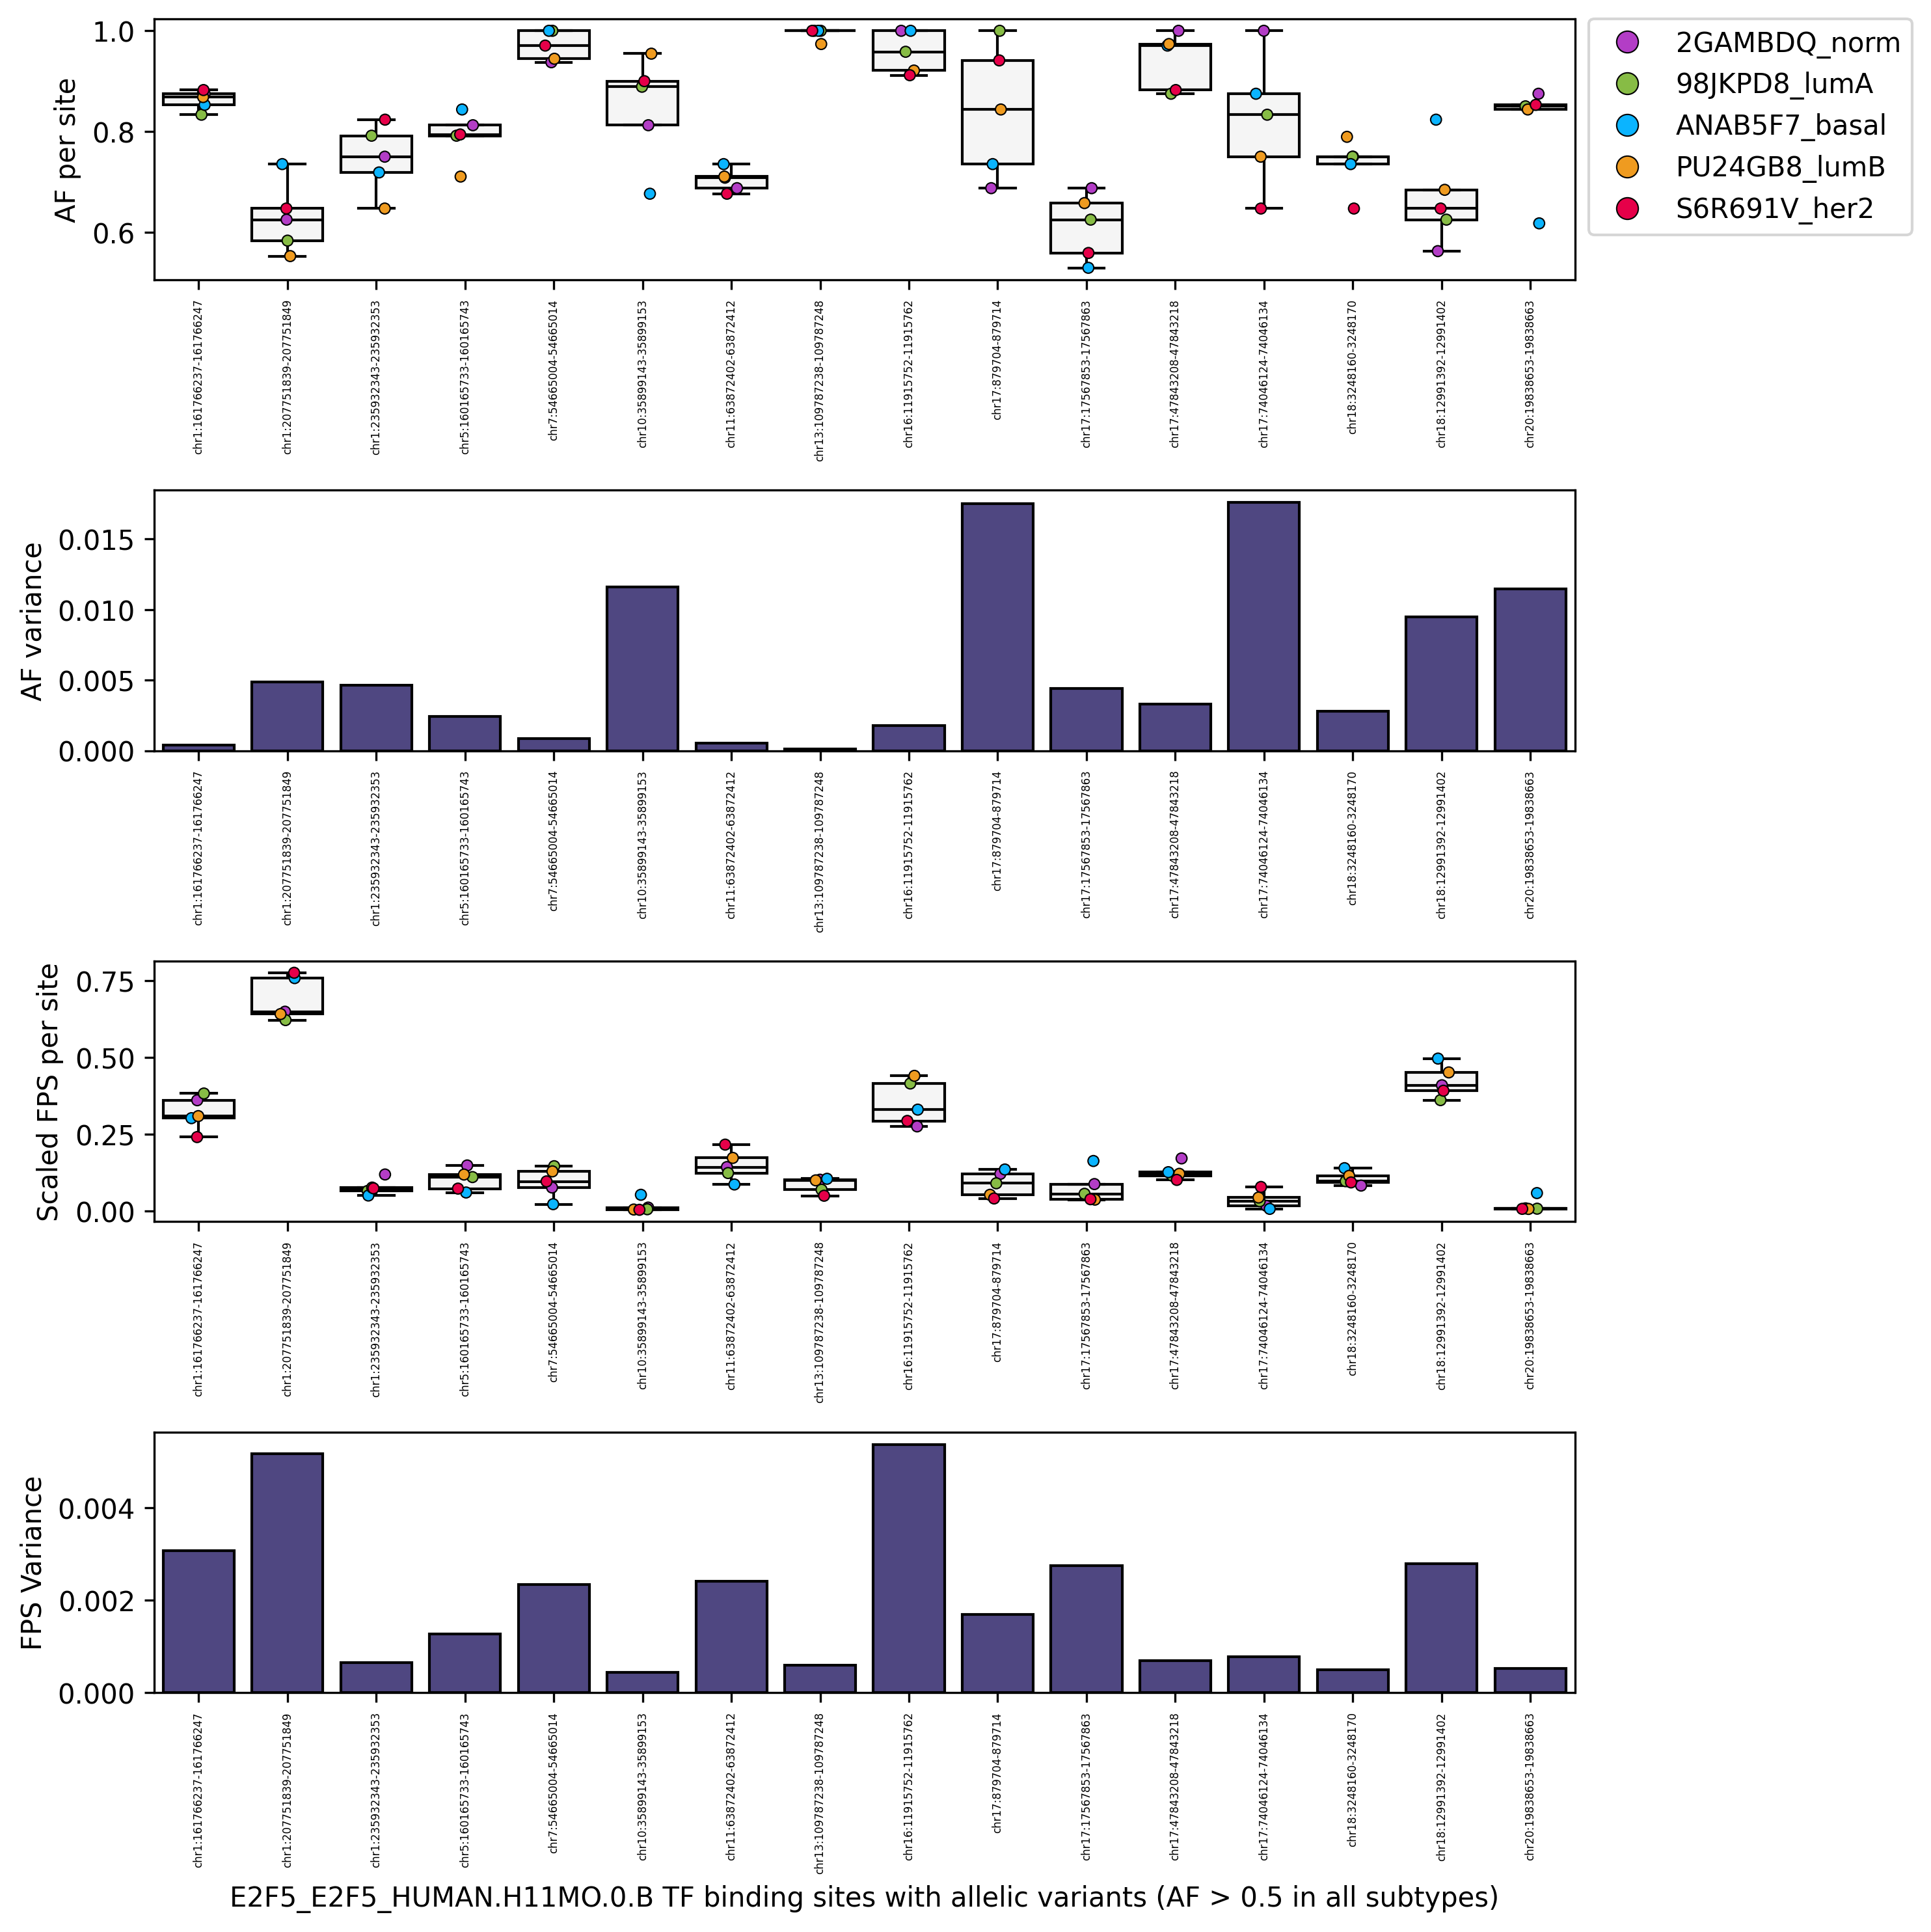

In [50]:
# create color dictionary
dutchfield_colordict = {'S6R691V_her2': "#e60049", 'ANAB5F7_basal': "#0bb4ff", '98JKPD8_lumA': "#87bc45", 'PU24GB8_lumB': "#ef9b20", '2GAMBDQ_norm': "#b33dc6"}
plt.figure(figsize=(10, 10), dpi=300)
# specify subplot
plt.subplot(4, 1, 1)
sns.boxplot(x='region_id', y='AF', data=high_nzaf_outliers, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='AF', data=high_nzaf_outliers, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, linewidth=0.5, edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('')
plt.ylabel('AF per site', fontsize=10)
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, markerscale=2, fontsize=10)

plt.subplot(4, 1, 2)
sns.barplot(x='region_id', y='AF_var', data=high_nzaf_outliers, color='darkslateblue', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('')
plt.ylabel('AF variance', fontsize=10)
  
plt.subplot(4, 1, 3)
sns.boxplot(x='region_id', y='FPS_scaled', data=high_nzaf_outliers, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='FPS_scaled', data=high_nzaf_outliers, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, legend=False, linewidth=0.5, edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('')
plt.ylabel('Scaled FPS per site', fontsize=10)

plt.subplot(4, 1, 4)
sns.barplot(x='region_id', y='FPS_scaled_var', data=high_nzaf_outliers, color='darkslateblue', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel(f'{motif_id} TF binding sites with allelic variants (AF > 0.5 in all subtypes)', fontsize=10)
plt.ylabel('FPS Variance', fontsize=10)
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()
plt.show()

#### STRATEGY 2: Thresholding by central FPS value

First, let's assess whether median or mean is a better measure of central tendency for the FPS values.

In [51]:
# strategy 2: subset high_af for FPS_scaled > median (of the unsplit dataframe)
# calculate global median of the FPS scaled for the unsplit dataframe
mf_df_s2 = mf_df.copy()
mf_df_s2

region_id      sample_id        AF      FPS  FPS_scaled  \
0           chr1:925405-925415   2GAMBDQ_norm  1.000000  0.05586    0.026175   
1           chr1:925405-925415   98JKPD8_lumA  1.000000  0.09540    0.042012   
2           chr1:925405-925415  ANAB5F7_basal  0.730769  0.03670    0.018821   
3           chr1:925405-925415   PU24GB8_lumB  0.769231  0.05082    0.023798   
4           chr1:925405-925415   S6R691V_her2  0.730769  0.09011    0.044860   
...                        ...            ...       ...      ...         ...   
3230  chrX:150849074-150849084   2GAMBDQ_norm  0.750000  0.20522    0.096162   
3231  chrX:150849074-150849084   98JKPD8_lumA  0.500000  0.34392    0.151456   
3232  chrX:150849074-150849084  ANAB5F7_basal  0.600000  0.07363    0.037761   
3233  chrX:150849074-150849084   PU24GB8_lumB  0.605263  0.24735    0.115831   
3234  chrX:150849074-150849084   S6R691V_her2  0.588235  0.35995    0.179197   

       FPS_var  FPS_scaled_var    AF_var  
0     0.000659        0.000134  0.019970  
1     0.000659        0.000134  0.019970  
2     0.000659        0.000134  0.019970  
3     0.000659        0.000134  0.019970  
4     0.000659        0.000134  0.019970  
...        ...             ...       ...  
3230  0.013487        0.002941  0.008072  
3231  0.013487        0.002941  0.008072  
3232  0.013487        0.002941  0.008072  
3233  0.013487        0.002941  0.008072  
3234  0.013487        0.002941  0.008072  

[3235 rows x 8 columns]

In [52]:
fps_scaled_global_median = mf_df_s2['FPS_scaled'].median()
print(fps_scaled_global_median)
fps_scaled_global_mean = mf_df_s2['FPS_scaled'].mean()
print(fps_scaled_global_mean)

0.013078051271958801
0.04597799805605853


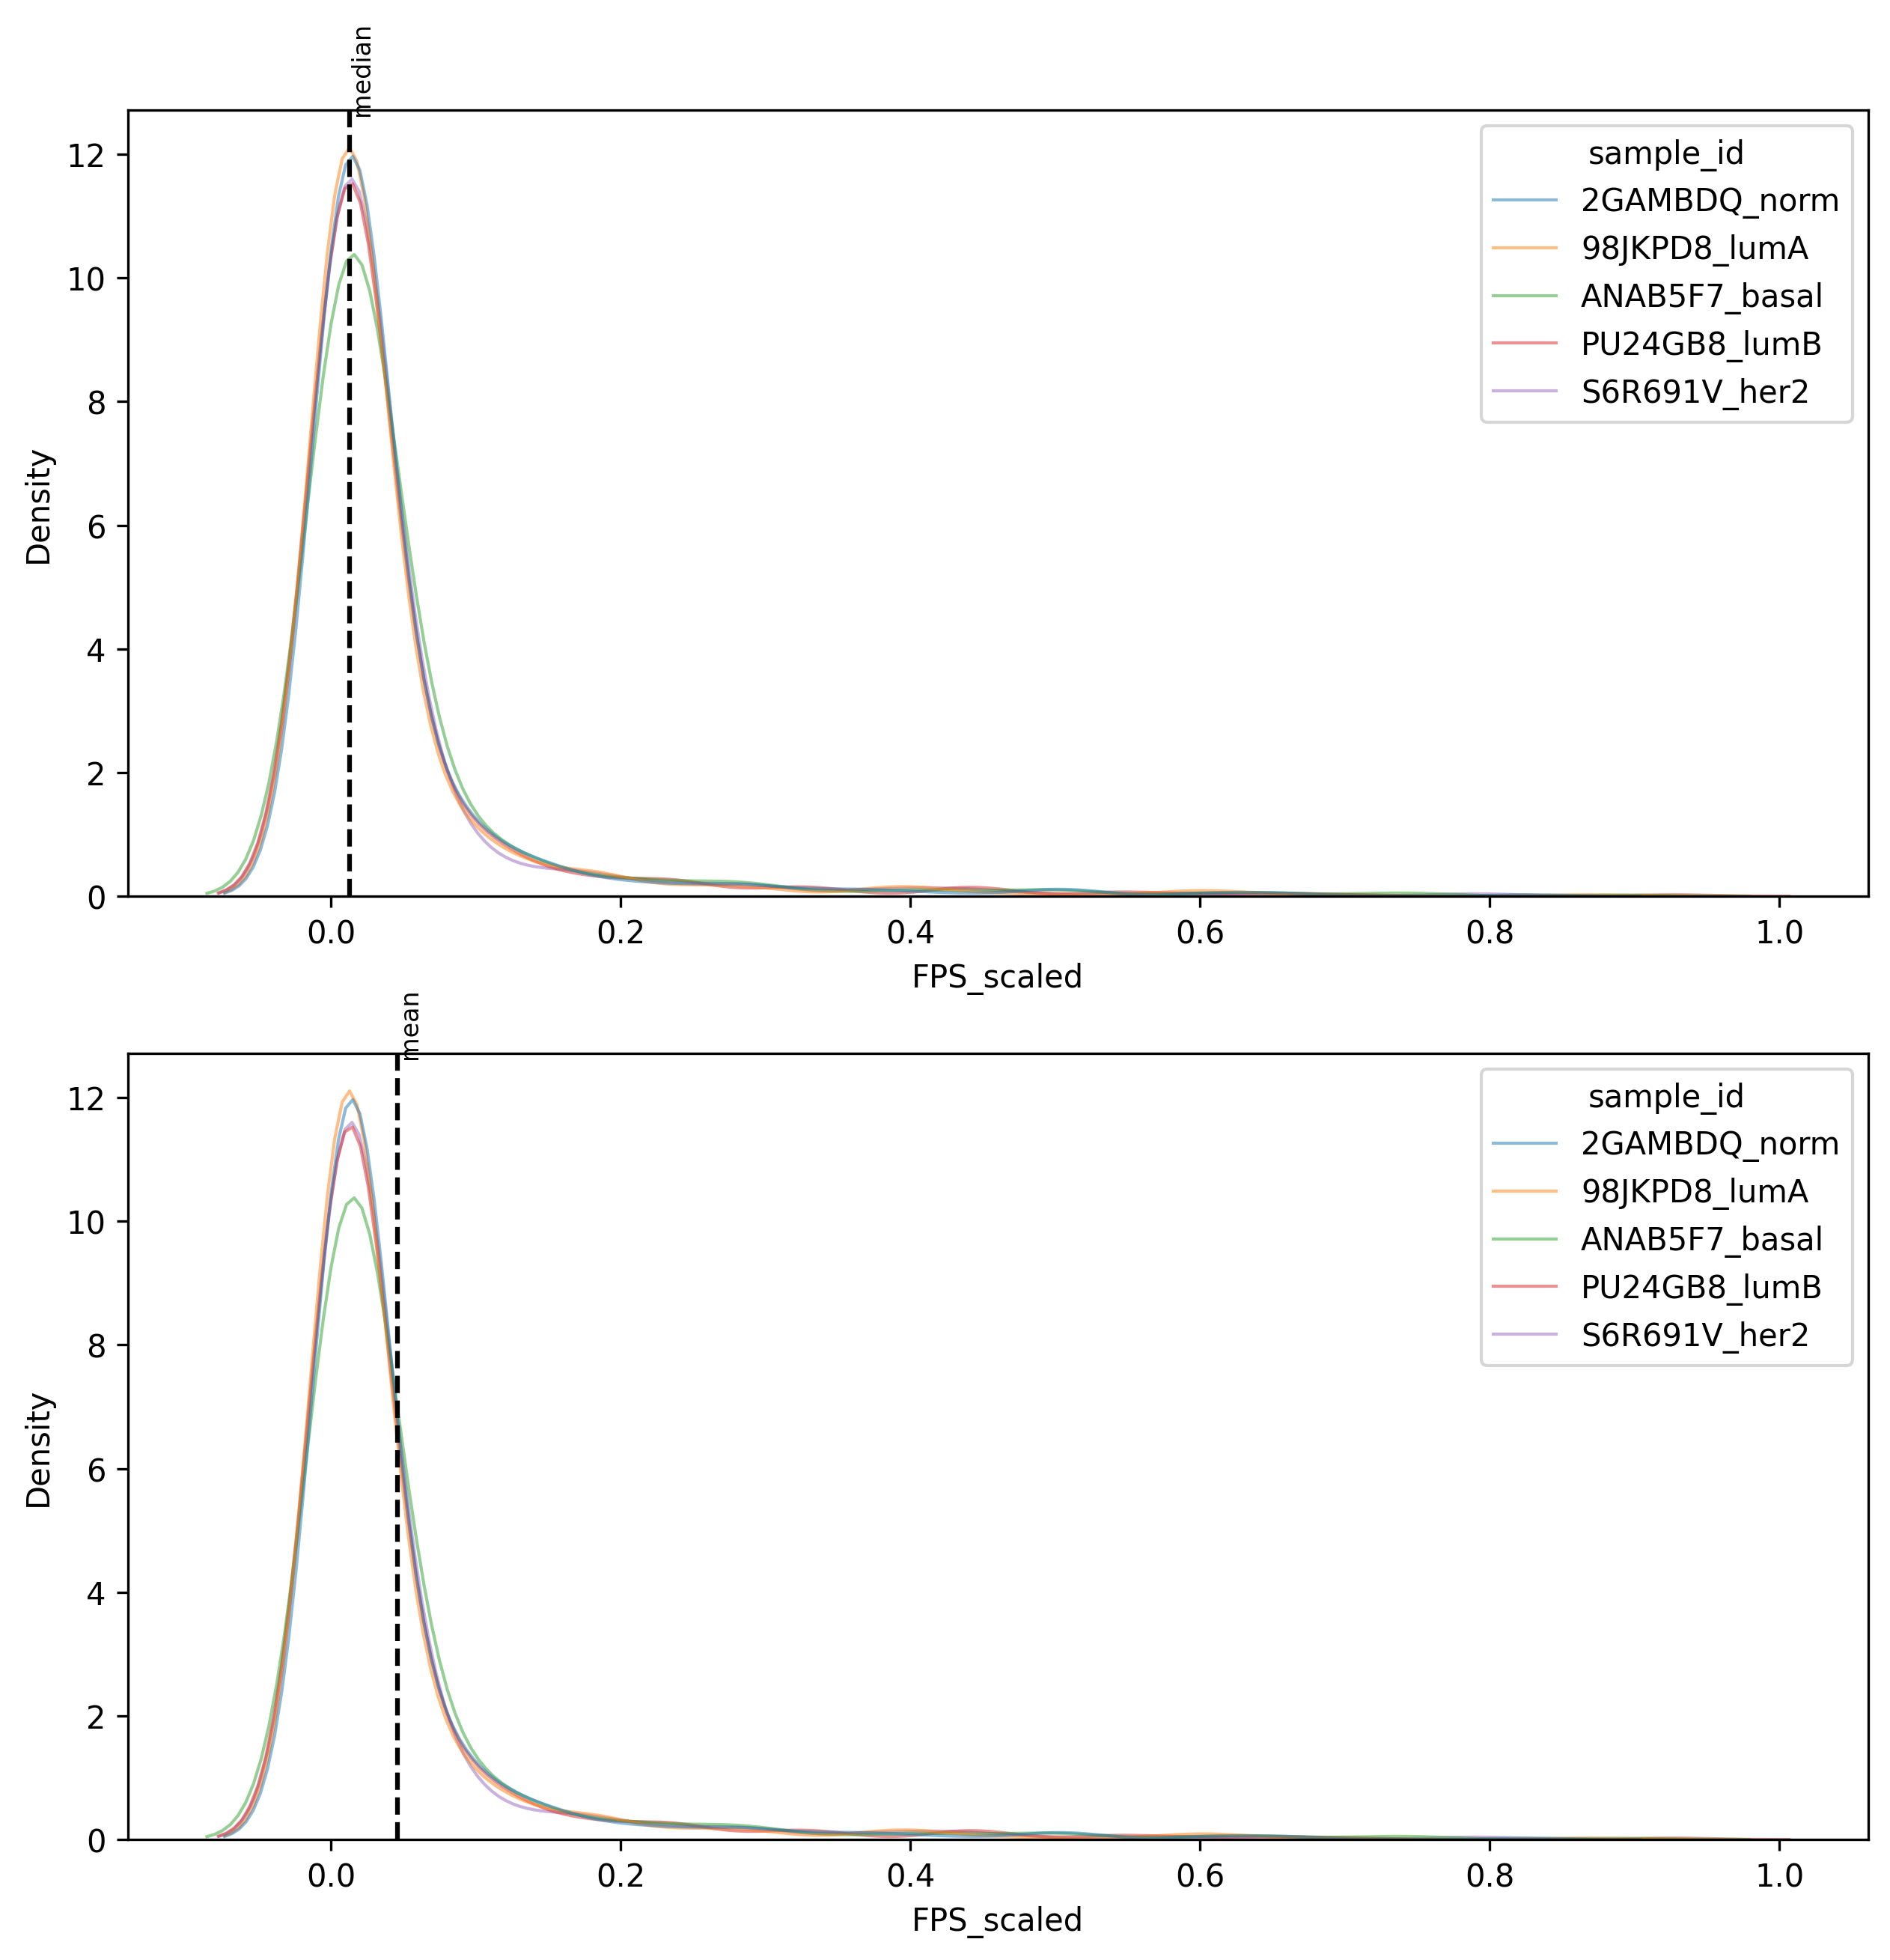

In [53]:
# plot fps_scaled distribution
plt.figure(figsize=(10, 10), dpi=300)
plt.subplot(2, 1, 1)
sns.kdeplot(data=mf_df_s2, x="FPS_scaled", hue="sample_id", fill=False, common_norm=False, alpha=.5, linewidth=1)
plt.axvline(x=fps_scaled_global_median, color='black', linestyle='--')
# label the median and mean
plt.text(fps_scaled_global_median, plt.gca().get_ylim()[1], 'median', rotation=90, fontsize=8)
plt.subplot(2, 1, 2)
sns.kdeplot(data=mf_df_s2, x="FPS_scaled", hue="sample_id", fill=False, common_norm=False, alpha=.5, linewidth=1)
plt.axvline(x=fps_scaled_global_mean, color='black', linestyle='--')
# label the median and mean
plt.text(fps_scaled_global_mean, plt.gca().get_ylim()[1], 'mean', rotation=90, fontsize=8)
plt.show()

It seems like using mean is more stringent than using median to filter out noise. Let's use the mean.

Now we can filter the dataframes to retain only rows that have `FPS_scaled` values above the mean.

In [54]:
# subset region_id with FPS_scaled > mean
# first subset per region_id and then filter for those with FPS_scaled > mean for any subtype
high_af_fpsgtmean_any = high_af.groupby('region_id').filter(lambda x: (x['FPS_scaled'] > fps_scaled_global_mean).any())
high_af_fpsgtmean_any

region_id      sample_id        AF      FPS  FPS_scaled  \
110    chr1:52055381-52055391   2GAMBDQ_norm  1.000000  0.17739    0.083121   
111    chr1:52055381-52055391   98JKPD8_lumA  1.000000  0.25634    0.112887   
112    chr1:52055381-52055391  ANAB5F7_basal  0.941176  0.24529    0.125796   
113    chr1:52055381-52055391   PU24GB8_lumB  1.000000  0.21208    0.099315   
114    chr1:52055381-52055391   S6R691V_her2  0.882353  0.24599    0.122464   
...                       ...            ...       ...      ...         ...   
3145  chr22:31530732-31530742   2GAMBDQ_norm  0.812500  0.21078    0.098767   
3146  chr22:31530732-31530742   98JKPD8_lumA  0.875000  0.21306    0.093828   
3147  chr22:31530732-31530742  ANAB5F7_basal  0.735294  0.24335    0.124801   
3148  chr22:31530732-31530742   PU24GB8_lumB  0.631579  0.21487    0.100621   
3149  chr22:31530732-31530742   S6R691V_her2  0.735294  0.20292    0.101022   

       FPS_var  FPS_scaled_var    AF_var  
110   0.001060        0.000310  0.002768  
111   0.001060        0.000310  0.002768  
112   0.001060        0.000310  0.002768  
113   0.001060        0.000310  0.002768  
114   0.001060        0.000310  0.002768  
...        ...             ...       ...  
3145  0.000238        0.000146  0.008418  
3146  0.000238        0.000146  0.008418  
3147  0.000238        0.000146  0.008418  
3148  0.000238        0.000146  0.008418  
3149  0.000238        0.000146  0.008418  

[165 rows x 8 columns]

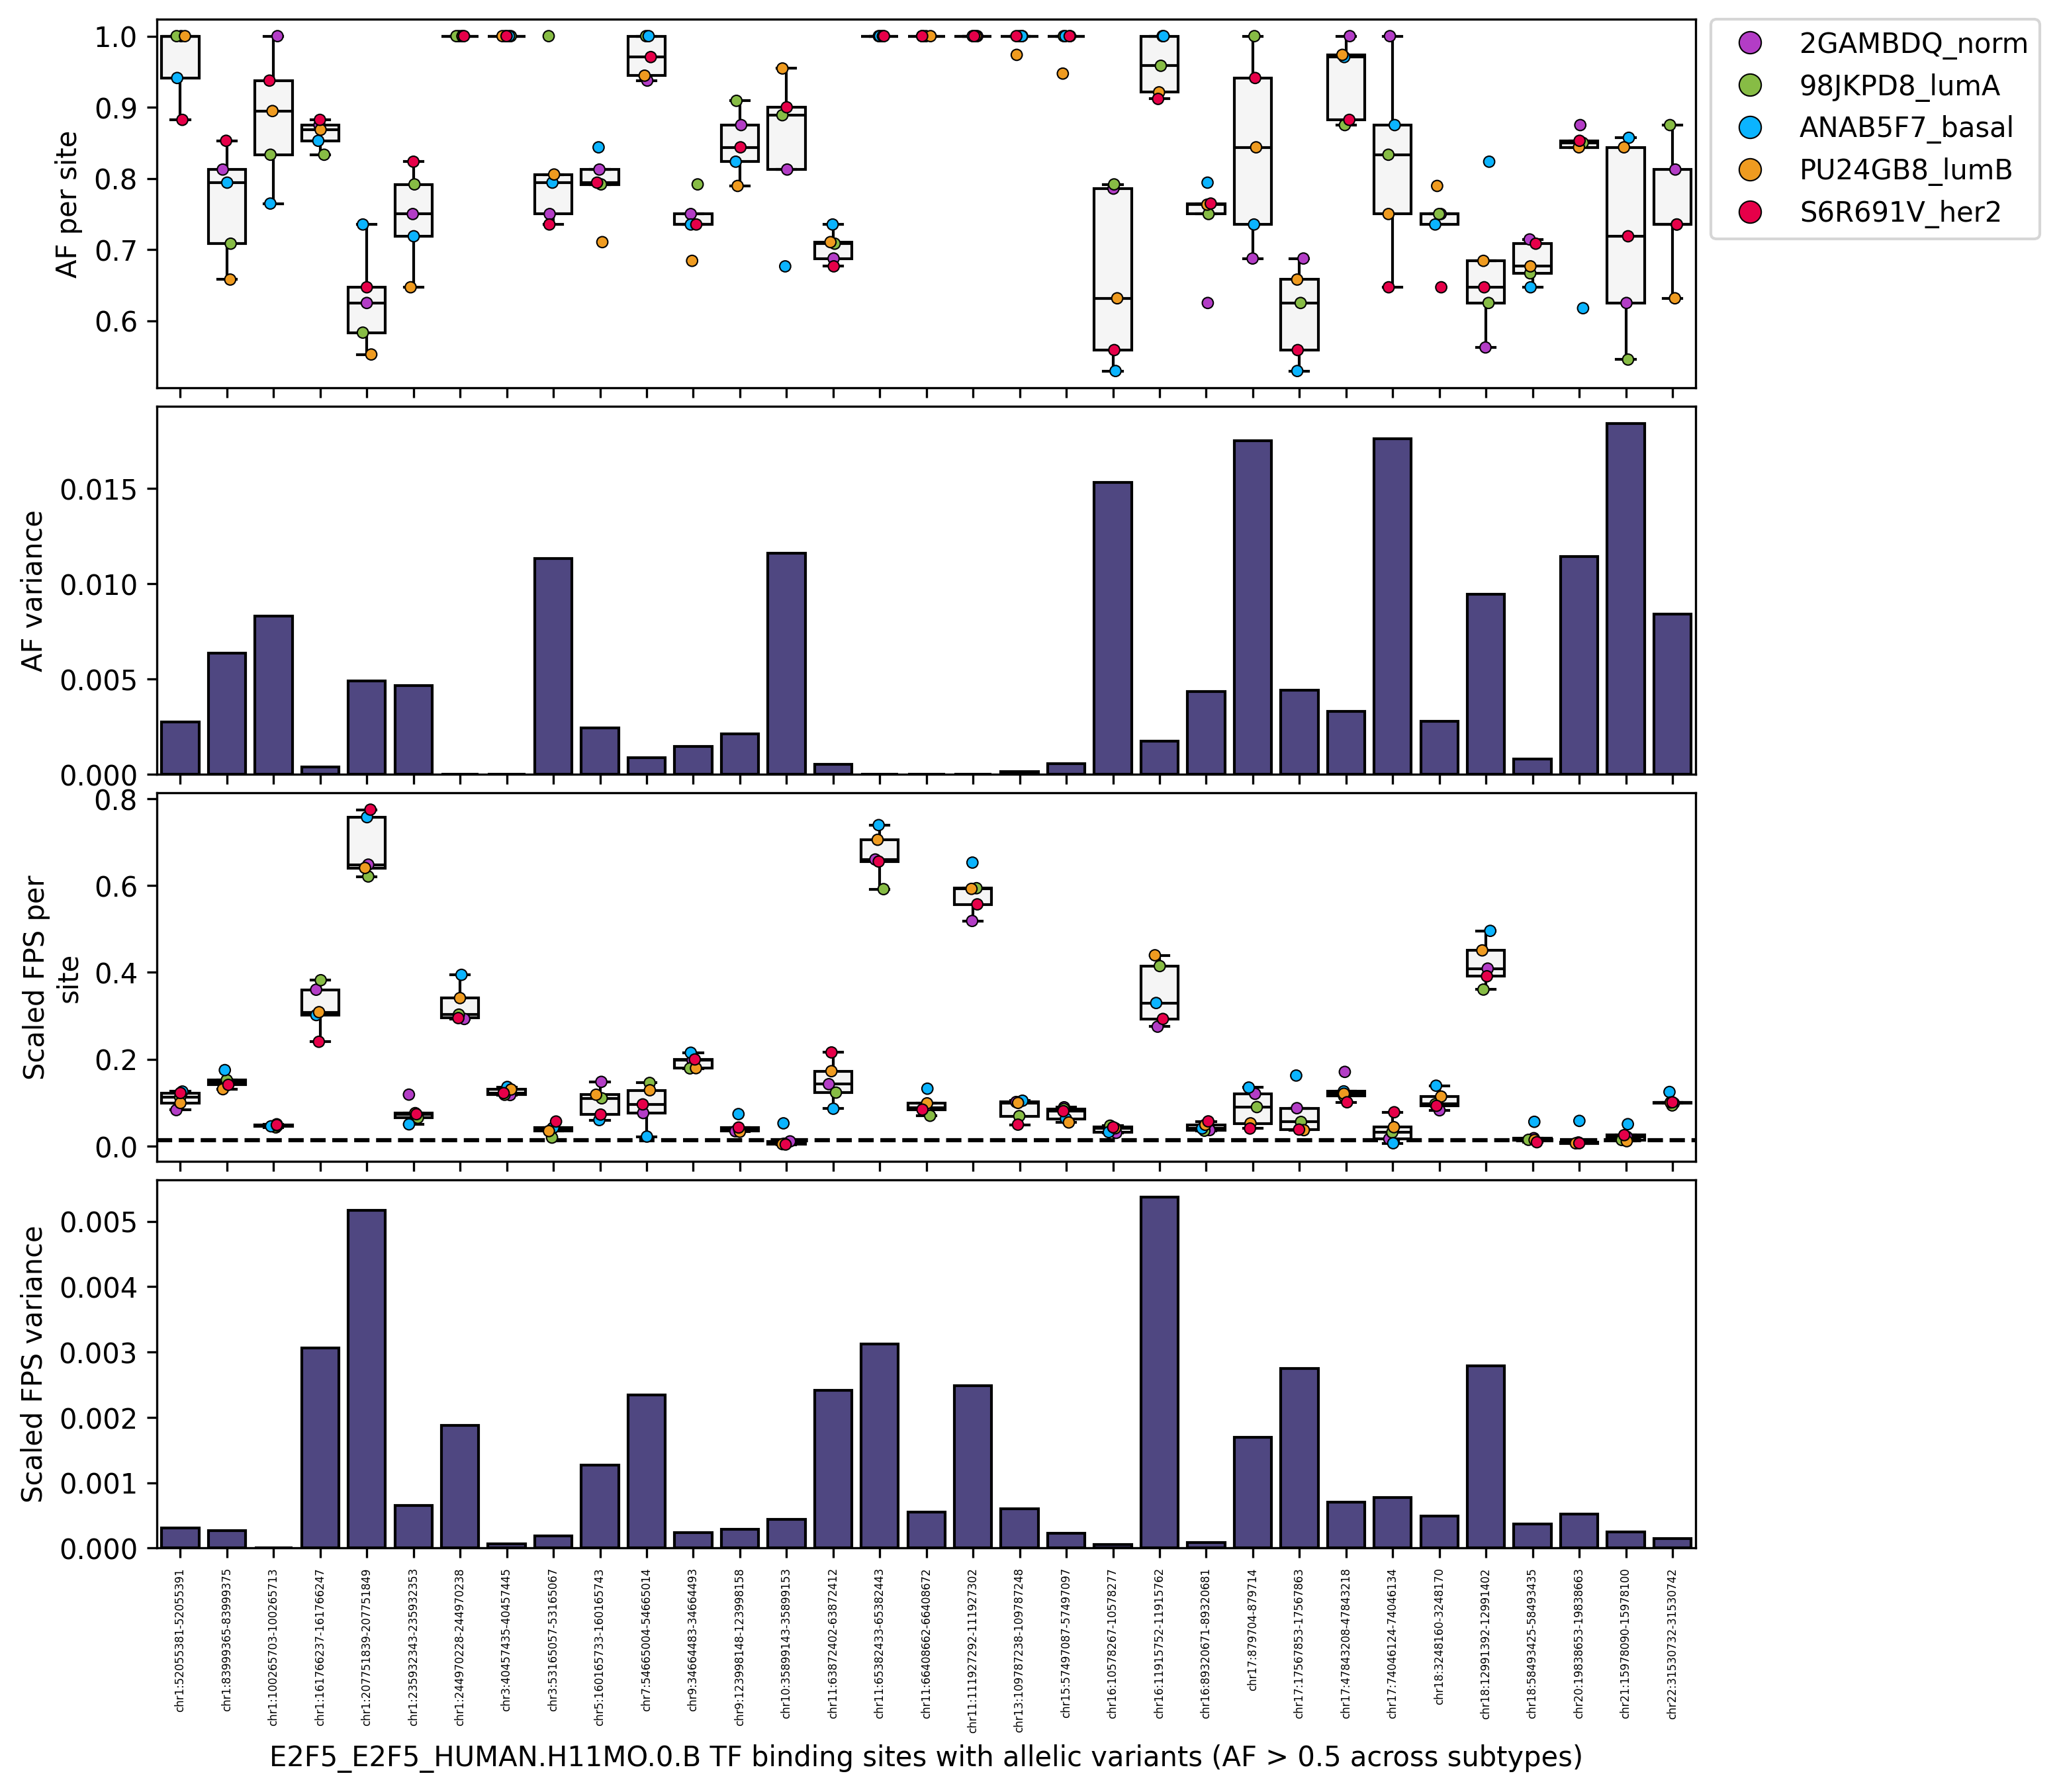

In [55]:
# create color dictionary
dutchfield_colordict = {'S6R691V_her2': "#e60049", 'ANAB5F7_basal': "#0bb4ff", '98JKPD8_lumA': "#87bc45", 'PU24GB8_lumB': "#ef9b20", '2GAMBDQ_norm': "#b33dc6"}
plt.figure(figsize=(10, 10), dpi=300)
# specify subplot
plt.subplot(4, 1, 1)
sns.boxplot(x='region_id', y='AF', data=high_af_fpsgtmean_any, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='AF', data=high_af_fpsgtmean_any, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, linewidth=0.5, edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('AF per site', width=15)
plt.ylabel(ylabel, fontsize=10)
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, markerscale=2, fontsize=10)

plt.subplot(4, 1, 2)
sns.barplot(x='region_id', y='AF_var', data=high_af_fpsgtmean_any, color='darkslateblue', edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('AF variance', width=15)
plt.ylabel(ylabel, fontsize=10)
  
plt.subplot(4, 1, 3)
sns.boxplot(x='region_id', y='FPS_scaled', data=high_af_fpsgtmean_any, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='FPS_scaled', data=high_af_fpsgtmean_any, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, legend=False, linewidth=0.5, edgecolor='black')
# plot horizontal line at fps_scaled_global_median
plt.axhline(y=fps_scaled_global_mean, color='black', linestyle='--')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('Scaled FPS per site', width=15)
plt.ylabel(ylabel, fontsize=10)

plt.subplot(4, 1, 4)
sns.barplot(x='region_id', y='FPS_scaled_var', data=high_af_fpsgtmean_any, color='darkslateblue', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel(f'{motif_id} TF binding sites with allelic variants (AF > 0.5 across subtypes)', fontsize=10)
plt.ylabel('Scaled FPS variance', fontsize=10)
plt.subplots_adjust(hspace=0.05)
plt.show()

'any' FPS scaled value does not seem to really retain any highly variable sites across subtypes (that spans across the mean value in the plot) so let's retain only sites that have `all` FPS scaled values above the mean.

In [56]:
# subset region_id with FPS_scaled > mean
# subset per region_id and then filter for those with FPS_scaled > mean for all subtype
high_af_fpsgtmean_all = high_af.groupby('region_id').filter(lambda x: (x['FPS_scaled'] > fps_scaled_global_mean).all())
high_af_fpsgtmean_all

region_id      sample_id        AF      FPS  FPS_scaled  \
110    chr1:52055381-52055391   2GAMBDQ_norm  1.000000  0.17739    0.083121   
111    chr1:52055381-52055391   98JKPD8_lumA  1.000000  0.25634    0.112887   
112    chr1:52055381-52055391  ANAB5F7_basal  0.941176  0.24529    0.125796   
113    chr1:52055381-52055391   PU24GB8_lumB  1.000000  0.21208    0.099315   
114    chr1:52055381-52055391   S6R691V_her2  0.882353  0.24599    0.122464   
...                       ...            ...       ...      ...         ...   
3145  chr22:31530732-31530742   2GAMBDQ_norm  0.812500  0.21078    0.098767   
3146  chr22:31530732-31530742   98JKPD8_lumA  0.875000  0.21306    0.093828   
3147  chr22:31530732-31530742  ANAB5F7_basal  0.735294  0.24335    0.124801   
3148  chr22:31530732-31530742   PU24GB8_lumB  0.631579  0.21487    0.100621   
3149  chr22:31530732-31530742   S6R691V_her2  0.735294  0.20292    0.101022   

       FPS_var  FPS_scaled_var    AF_var  
110   0.001060        0.000310  0.002768  
111   0.001060        0.000310  0.002768  
112   0.001060        0.000310  0.002768  
113   0.001060        0.000310  0.002768  
114   0.001060        0.000310  0.002768  
...        ...             ...       ...  
3145  0.000238        0.000146  0.008418  
3146  0.000238        0.000146  0.008418  
3147  0.000238        0.000146  0.008418  
3148  0.000238        0.000146  0.008418  
3149  0.000238        0.000146  0.008418  

[100 rows x 8 columns]

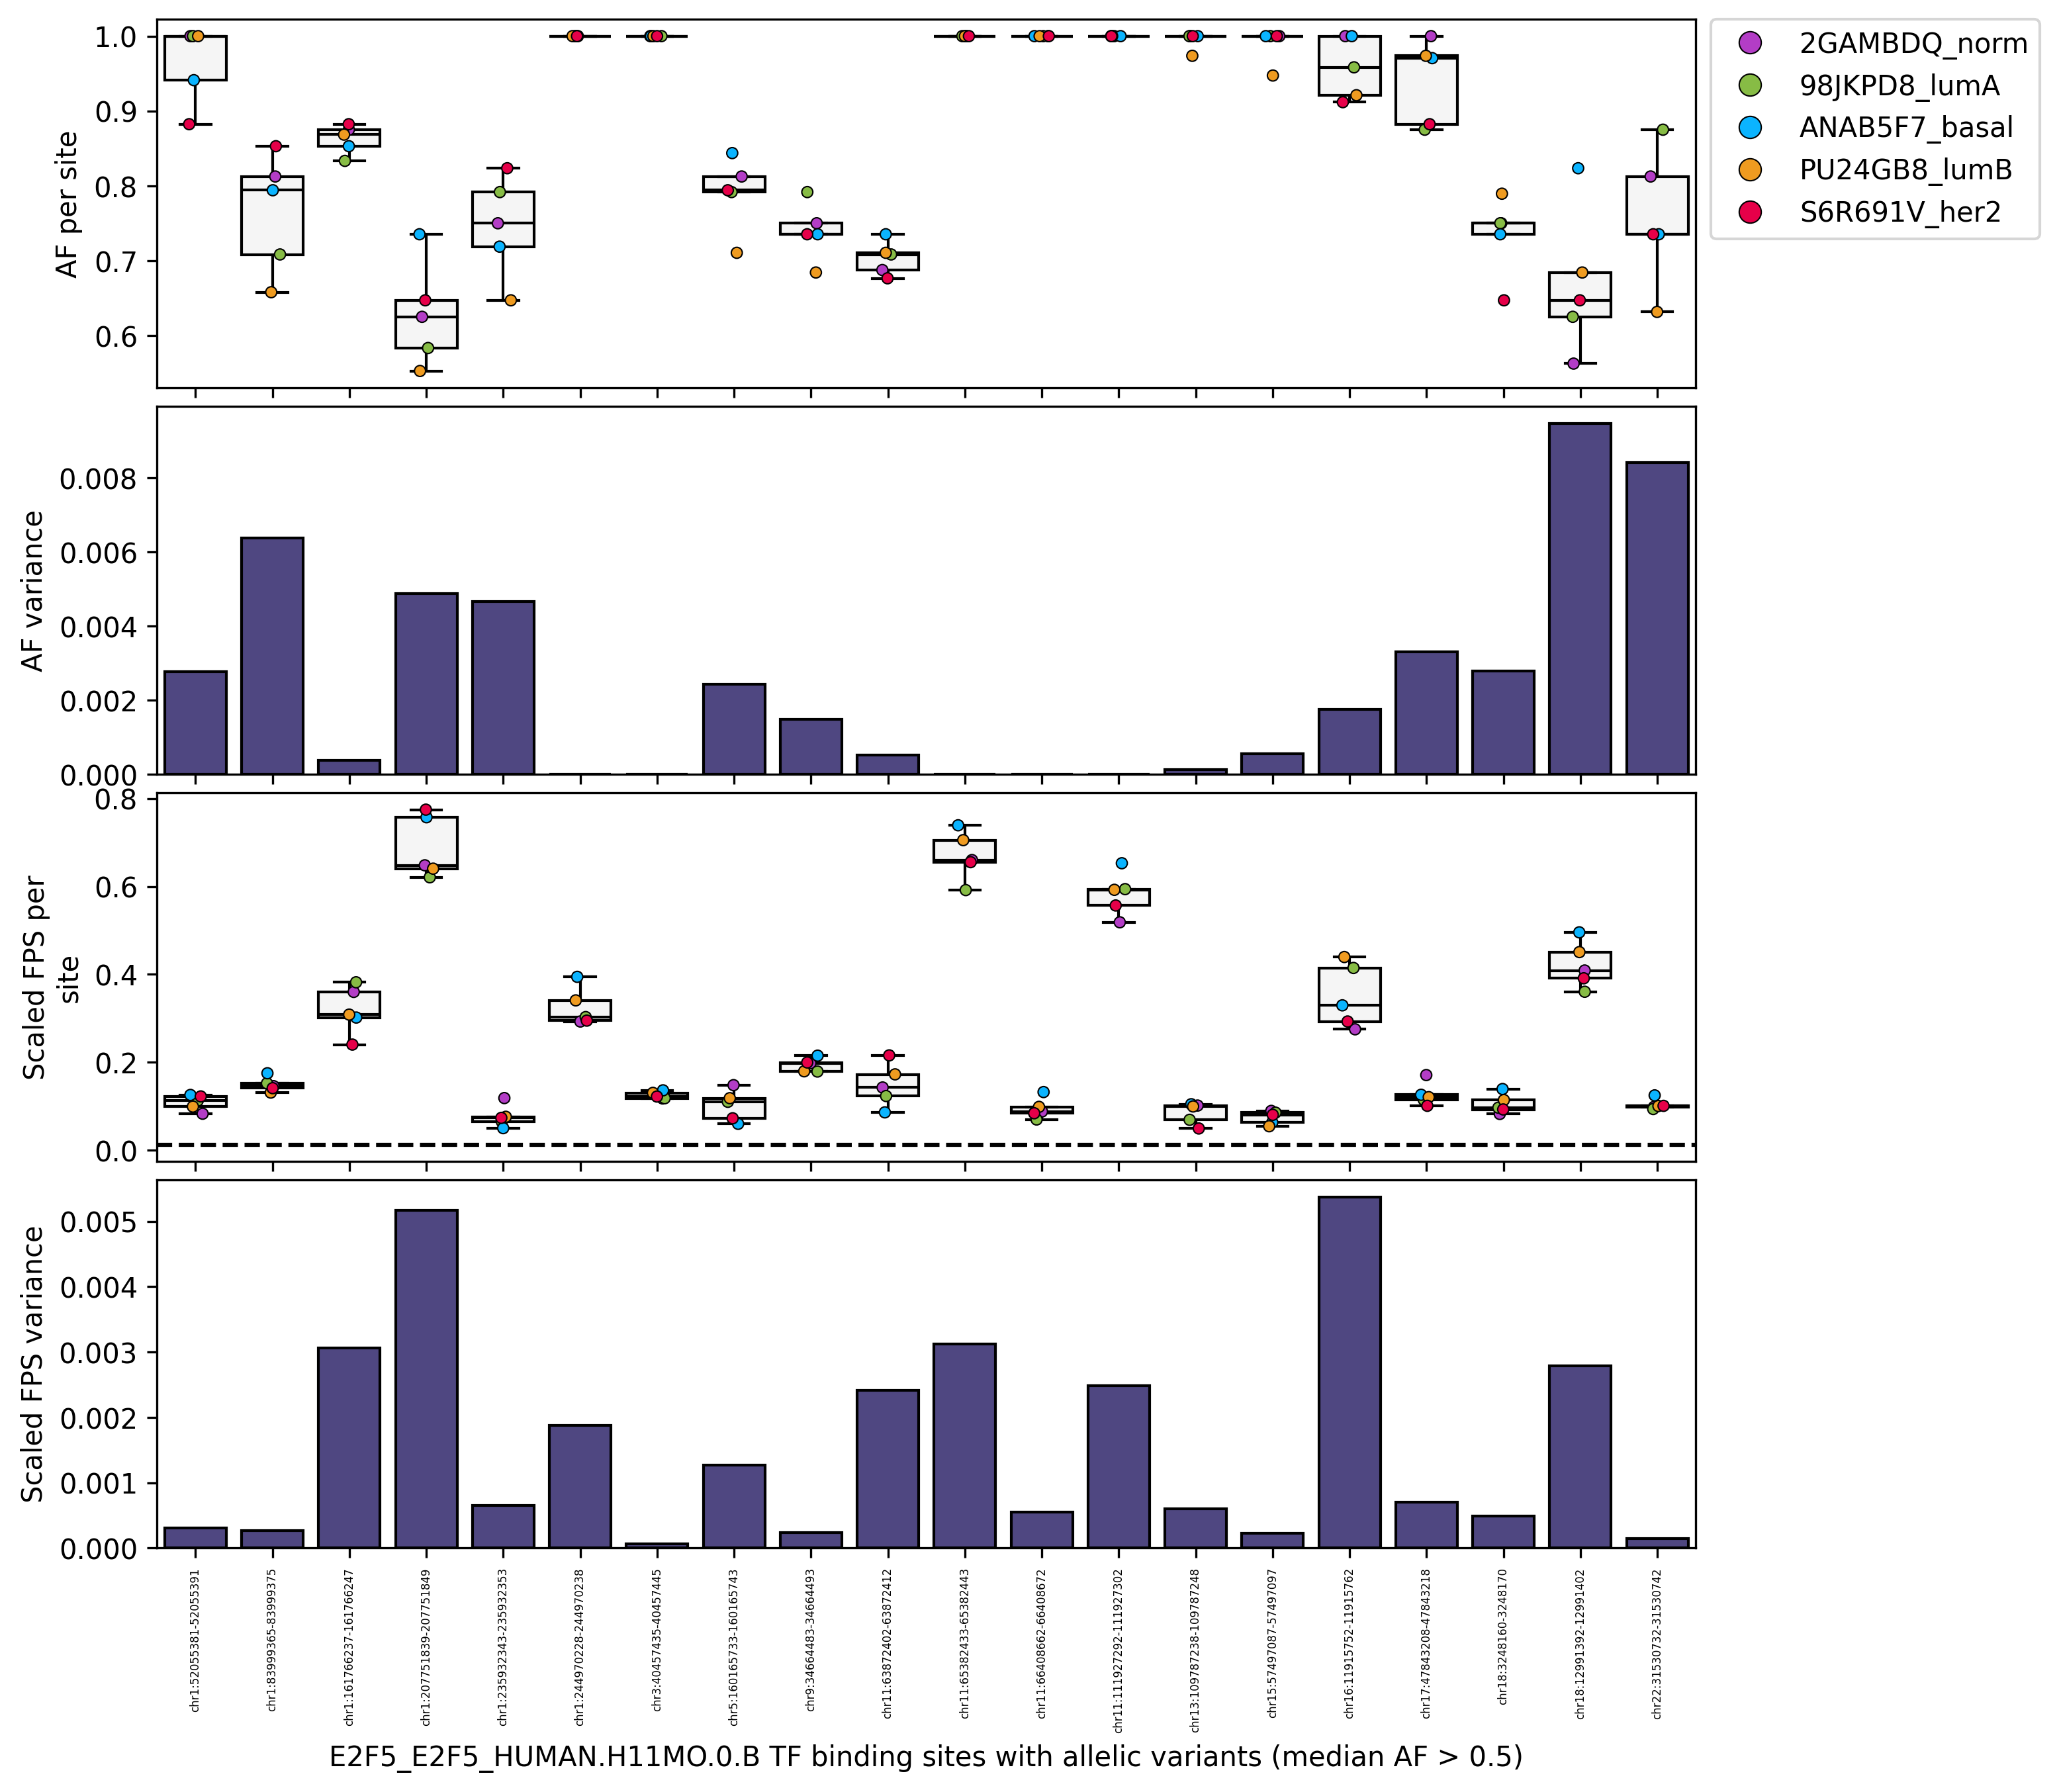

In [57]:
dutchfield_colordict = {'S6R691V_her2': "#e60049", 'ANAB5F7_basal': "#0bb4ff", '98JKPD8_lumA': "#87bc45", 'PU24GB8_lumB': "#ef9b20", '2GAMBDQ_norm': "#b33dc6"}
plt.figure(figsize=(10, 10), dpi=300)
# specify subplot
plt.subplot(4, 1, 1)
sns.boxplot(x='region_id', y='AF', data=high_af_fpsgtmean_all, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='AF', data=high_af_fpsgtmean_all, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, linewidth=0.5, edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('AF per site', width=15)
plt.ylabel(ylabel, fontsize=10)
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, markerscale=2, fontsize=10)

plt.subplot(4, 1, 2)
sns.barplot(x='region_id', y='AF_var', data=high_af_fpsgtmean_all, color='darkslateblue', edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('AF variance', width=15)
plt.ylabel(ylabel, fontsize=10)
  
plt.subplot(4, 1, 3)
sns.boxplot(x='region_id', y='FPS_scaled', data=high_af_fpsgtmean_all, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='FPS_scaled', data=high_af_fpsgtmean_all, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, legend=False, linewidth=0.5, edgecolor='black')
# plot horizontal line at fps_scaled_global_mean
plt.axhline(y=fps_scaled_global_mean, color='black', linestyle='--')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('Scaled FPS per site', width=15)
plt.ylabel(ylabel, fontsize=10)

plt.subplot(4, 1, 4)
sns.barplot(x='region_id', y='FPS_scaled_var', data=high_af_fpsgtmean_all, color='darkslateblue', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel(f'{motif_id} TF binding sites with allelic variants (median AF > 0.5)', fontsize=10)
plt.ylabel('Scaled FPS variance', fontsize=10)
plt.subplots_adjust(hspace=0.05)
plt.show()

Now that it looks pretty valid, we would also like to subset the unsplit dataframe for FPS values that are below the mean across all subtypes with high AF values as well as FPS values that are above and below the mean across all subtypes with low AF values.

In [58]:
# subset per region_id and then filter for those with FPS_scaled < mean for all subtype
high_af_fpsltmean_all = high_af.groupby('region_id').filter(lambda x: (x['FPS_scaled'] <= fps_scaled_global_mean).all())
high_af_fpsltmean_all

region_id      sample_id        AF      FPS  FPS_scaled  \
0         chr1:925405-925415   2GAMBDQ_norm  1.000000  0.05586    0.026175   
1         chr1:925405-925415   98JKPD8_lumA  1.000000  0.09540    0.042012   
2         chr1:925405-925415  ANAB5F7_basal  0.730769  0.03670    0.018821   
3         chr1:925405-925415   PU24GB8_lumB  0.769231  0.05082    0.023798   
4         chr1:925405-925415   S6R691V_her2  0.730769  0.09011    0.044860   
...                      ...            ...       ...      ...         ...   
3200  chrX:34275969-34275979   2GAMBDQ_norm  0.857143  0.02658    0.012455   
3201  chrX:34275969-34275979   98JKPD8_lumA  0.611111  0.03378    0.014876   
3202  chrX:34275969-34275979  ANAB5F7_basal  0.888889  0.01175    0.006026   
3203  chrX:34275969-34275979   PU24GB8_lumB  1.000000  0.02894    0.013552   
3204  chrX:34275969-34275979   S6R691V_her2  0.750000  0.03548    0.017663   

       FPS_var  FPS_scaled_var    AF_var  
0     0.000659        0.000134  0.019970  
1     0.000659        0.000134  0.019970  
2     0.000659        0.000134  0.019970  
3     0.000659        0.000134  0.019970  
4     0.000659        0.000134  0.019970  
...        ...             ...       ...  
3200  0.000088        0.000019  0.021762  
3201  0.000088        0.000019  0.021762  
3202  0.000088        0.000019  0.021762  
3203  0.000088        0.000019  0.021762  
3204  0.000088        0.000019  0.021762  

[470 rows x 8 columns]

In [59]:
# subset per region_id and then filter for those with FPS_scaled < mean for all subtype
low_af_fpsltmean_all = low_af.groupby('region_id').filter(lambda x: (x['FPS_scaled'] <= fps_scaled_global_mean).all())
low_af_fpsltmean_all

region_id      sample_id        AF      FPS  FPS_scaled  \
10        chr1:1225277-1225287   2GAMBDQ_norm  0.071429  0.02657    0.012450   
11        chr1:1225277-1225287   98JKPD8_lumA  0.090909  0.01792    0.007892   
12        chr1:1225277-1225287  ANAB5F7_basal  0.062500  0.04624    0.023714   
13        chr1:1225277-1225287   PU24GB8_lumB  0.078947  0.01957    0.009164   
14        chr1:1225277-1225287   S6R691V_her2  0.088235  0.02729    0.013586   
...                        ...            ...       ...      ...         ...   
3225  chrX:116240865-116240875   2GAMBDQ_norm  0.250000  0.03826    0.017928   
3226  chrX:116240865-116240875   98JKPD8_lumA  0.250000  0.02826    0.012445   
3227  chrX:116240865-116240875  ANAB5F7_basal  0.500000  0.04863    0.024940   
3228  chrX:116240865-116240875   PU24GB8_lumB  0.552632  0.02045    0.009577   
3229  chrX:116240865-116240875   S6R691V_her2  0.333333  0.03239    0.016125   

       FPS_var  FPS_scaled_var    AF_var  
10    0.000127        0.000039  0.000139  
11    0.000127        0.000039  0.000139  
12    0.000127        0.000039  0.000139  
13    0.000127        0.000039  0.000139  
14    0.000127        0.000039  0.000139  
...        ...             ...       ...  
3225  0.000113        0.000034  0.020035  
3226  0.000113        0.000034  0.020035  
3227  0.000113        0.000034  0.020035  
3228  0.000113        0.000034  0.020035  
3229  0.000113        0.000034  0.020035  

[1890 rows x 8 columns]

In [60]:
# subset per region_id and then filter for those with FPS_scaled < mean for all subtype
low_af_fpsgtmean_all = low_af.groupby('region_id').filter(lambda x: (x['FPS_scaled'] > fps_scaled_global_mean).all())
low_af_fpsgtmean_all

region_id      sample_id        AF      FPS  FPS_scaled  \
15       chr1:3900825-3900835   2GAMBDQ_norm  0.125000  1.76533    0.827197   
16       chr1:3900825-3900835   98JKPD8_lumA  0.041667  1.95879    0.862614   
17       chr1:3900825-3900835  ANAB5F7_basal  0.147059  1.73899    0.891835   
18       chr1:3900825-3900835   PU24GB8_lumB  0.052632  1.97913    0.926806   
19       chr1:3900825-3900835   S6R691V_her2  0.117647  1.61461    0.803816   
...                       ...            ...       ...      ...         ...   
3170  chr22:41946757-41946767   2GAMBDQ_norm  0.062500  0.49960    0.234102   
3171  chr22:41946757-41946767   98JKPD8_lumA  0.166667  0.44847    0.197498   
3172  chr22:41946757-41946767  ANAB5F7_basal  0.147059  0.60331    0.309406   
3173  chr22:41946757-41946767   PU24GB8_lumB  0.131579  0.51443    0.240902   
3174  chr22:41946757-41946767   S6R691V_her2  0.058824  0.45316    0.225601   

       FPS_var  FPS_scaled_var    AF_var  
15    0.023987        0.002421  0.002187  
16    0.023987        0.002421  0.002187  
17    0.023987        0.002421  0.002187  
18    0.023987        0.002421  0.002187  
19    0.023987        0.002421  0.002187  
...        ...             ...       ...  
3170  0.003915        0.001714  0.002468  
3171  0.003915        0.001714  0.002468  
3172  0.003915        0.001714  0.002468  
3173  0.003915        0.001714  0.002468  
3174  0.003915        0.001714  0.002468  

[410 rows x 8 columns]

Now we can sort the dataframe by `region_id` based on the descending order of `FPS_scaled_var` values.

In [61]:
### strat 1 dataframe
high_af_uniq_reg = high_nzaf_outliers[['region_id', 'AF_var', 'FPS_scaled_var']].drop_duplicates()
# sort the region_id in the filtered high_af dataframe based on descending order of FPS_scaled_var
fpsvar_uniqsort = high_af_uniq_reg.sort_values(by='FPS_scaled_var', ascending=False)
# extract the region_id from the high_af_fps_var_df_uniqsort dataframe
sorted_region_ids = fpsvar_uniqsort['region_id']
# Change 'region_id' to a categorical variable with the categories ordered by 'sorted_region_ids'
df_copy = high_nzaf_outliers.copy()
df_copy['region_id'] = pd.Categorical(high_nzaf_outliers['region_id'], categories=sorted_region_ids, ordered=True)
# Filter the DataFrame
high_nzaf_filtered = df_copy[df_copy['region_id'].isin(sorted_region_ids)]

# Sort the DataFrame by 'region_id'
high_nzaf_filtered = high_nzaf_filtered.sort_values('region_id')
high_nzaf_filtered

region_id      sample_id        AF      FPS  FPS_scaled  \
2495  chr16:11915752-11915762   2GAMBDQ_norm  1.000000  0.58711    0.275108   
2496  chr16:11915752-11915762   98JKPD8_lumA  0.958333  0.94151    0.414623   
2497  chr16:11915752-11915762  ANAB5F7_basal  1.000000  0.64275    0.329632   
2498  chr16:11915752-11915762   PU24GB8_lumB  0.921053  0.93861    0.439541   
2499  chr16:11915752-11915762   S6R691V_her2  0.911765  0.58832    0.292889   
...                       ...            ...       ...      ...         ...   
1758  chr10:35899143-35899153   PU24GB8_lumB  0.954545  0.01006    0.004711   
1757  chr10:35899143-35899153  ANAB5F7_basal  0.676471  0.10266    0.052649   
1756  chr10:35899143-35899153   98JKPD8_lumA  0.888889  0.01277    0.005624   
1755  chr10:35899143-35899153   2GAMBDQ_norm  0.812500  0.02357    0.011044   
1759  chr10:35899143-35899153   S6R691V_her2  0.900000  0.00773    0.003848   

       FPS_var  FPS_scaled_var    AF_var  
2495  0.033973        0.005370  0.001758  
2496  0.033973        0.005370  0.001758  
2497  0.033973        0.005370  0.001758  
2498  0.033973        0.005370  0.001758  
2499  0.033973        0.005370  0.001758  
...        ...             ...       ...  
1758  0.001626        0.000437  0.011600  
1757  0.001626        0.000437  0.011600  
1756  0.001626        0.000437  0.011600  
1755  0.001626        0.000437  0.011600  
1759  0.001626        0.000437  0.011600  

[80 rows x 8 columns]

In [ ]:
# strat 2
uniq_reg = high_af_fpsgtmean_all[['region_id', 'AF_var', 'FPS_scaled_var']].drop_duplicates()
# sort the region_id in the filtered high_af dataframe based on descending order of FPS_scaled_var
fpsvar_uniqsort = uniq_reg.sort_values(by='FPS_scaled_var', ascending=False)
# extract the region_id from the high_af_fps_var_df_uniqsort dataframe
sorted_region_ids = fpsvar_uniqsort['region_id']
# Change 'region_id' to a categorical variable with the categories ordered by 'sorted_region_ids'
df_copy = high_af_fpsgtmean_all.copy()
df_copy['region_id'] = pd.Categorical(high_af_fpsgtmean_all['region_id'], categories=sorted_region_ids, ordered=True)
# Filter the DataFrame
high_af_fpsgtmean_filt = df_copy[df_copy['region_id'].isin(sorted_region_ids)]
# Sort the DataFrame by 'region_id'
high_af_fpsgtmean_filtered = high_af_fpsgtmean_filt.sort_values('region_id')


uniq_reg = low_af_fpsgtmean_all[['region_id', 'AF_var', 'FPS_scaled_var']].drop_duplicates()
# sort the region_id in the filtered high_af dataframe based on descending order of FPS_scaled_var
fpsvar_uniqsort = uniq_reg.sort_values(by='FPS_scaled_var', ascending=False)
# extract the region_id from the high_af_fps_var_df_uniqsort dataframe
sorted_region_ids = fpsvar_uniqsort['region_id']
# Change 'region_id' to a categorical variable with the categories ordered by 'sorted_region_ids'
df_copy = low_af_fpsgtmean_all.copy()
df_copy['region_id'] = pd.Categorical(low_af_fpsgtmean_all['region_id'], categories=sorted_region_ids, ordered=True)
# Filter the DataFrame
low_af_fpsgtmean_filt = df_copy[df_copy['region_id'].isin(sorted_region_ids)]
# Sort the DataFrame by 'region_id'
low_af_fpsgtmean_filtered = low_af_fpsgtmean_filt.sort_values('region_id')


uniq_reg = high_af_fpsltmean_all[['region_id', 'AF_var', 'FPS_scaled_var']].drop_duplicates()
# sort the region_id in the filtered high_af dataframe based on descending order of FPS_scaled_var
fpsvar_uniqsort = uniq_reg.sort_values(by='FPS_scaled_var', ascending=False)
# extract the region_id from the high_af_fps_var_df_uniqsort dataframe
sorted_region_ids = fpsvar_uniqsort['region_id']
# Change 'region_id' to a categorical variable with the categories ordered by 'sorted_region_ids'
df_copy = high_af_fpsltmean_all.copy()
df_copy['region_id'] = pd.Categorical(high_af_fpsltmean_all['region_id'], categories=sorted_region_ids, ordered=True)
# Filter the DataFrame
high_af_fpsltmean_filt = df_copy[df_copy['region_id'].isin(sorted_region_ids)]
# Sort the DataFrame by 'region_id'
high_af_fpsltmean_filtered = high_af_fpsltmean_filt.sort_values('region_id')


uniq_reg = low_af_fpsltmean_all[['region_id', 'AF_var', 'FPS_scaled_var']].drop_duplicates()
# sort the region_id in the filtered high_af dataframe based on descending order of FPS_scaled_var
fpsvar_uniqsort = uniq_reg.sort_values(by='FPS_scaled_var', ascending=False)
# extract the region_id from the high_af_fps_var_df_uniqsort dataframe
sorted_region_ids = fpsvar_uniqsort['region_id']
# Change 'region_id' to a categorical variable with the categories ordered by 'sorted_region_ids'
df_copy = low_af_fpsltmean_all.copy()
df_copy['region_id'] = pd.Categorical(low_af_fpsltmean_all['region_id'], categories=sorted_region_ids, ordered=True)
# Filter the DataFrame
low_af_fpsltmean_filt = df_copy[df_copy['region_id'].isin(sorted_region_ids)]
# Sort the DataFrame by 'region_id'
low_af_fpsltmean_filtered = low_af_fpsltmean_filt.sort_values('region_id')


Next, sort the sample_id values per each unique region_id by a specific order. This order is based on the lexicographic order of the sample_id values in the original matrix.

In [62]:
# get unique sample_id values into a list to define a categorical order
datasets = high_nzaf_filtered['sample_id'].unique().tolist()
datasets = sorted(datasets)

# Create a categorical variable with ordered categories
dataset_copy = high_nzaf_filtered.copy()
dataset_copy['sample_id'] = pd.Categorical(dataset_copy['sample_id'], categories=datasets, ordered=True)

# Sort 'sample_id' within each 'region_id'
high_nzaf_filtsorted = dataset_copy.groupby('region_id', sort=False, observed=False).apply(lambda x: x.sort_values('sample_id')).reset_index(drop=True)

# do the same for high_af_fpsgtmean_all, low_af_fpsgtmean_all, high_af_fpsltmean_all, low_af_fpsltmean_all

dataset_copy = high_af_fpsgtmean_filtered.copy()
dataset_copy['sample_id'] = pd.Categorical(dataset_copy['sample_id'], categories=datasets, ordered=True)
high_af_fpsgtmean_filtsorted = dataset_copy.groupby('region_id', sort=False, observed=False).apply(lambda x: x.sort_values('sample_id')).reset_index(drop=True)

dataset_copy = low_af_fpsgtmean_filtered.copy()
dataset_copy['sample_id'] = pd.Categorical(dataset_copy['sample_id'], categories=datasets, ordered=True)
low_af_fpsgtmean_filtsorted = dataset_copy.groupby('region_id', sort=False, observed=False).apply(lambda x: x.sort_values('sample_id')).reset_index(drop=True)

dataset_copy = high_af_fpsltmean_filtered.copy()
dataset_copy['sample_id'] = pd.Categorical(dataset_copy['sample_id'], categories=datasets, ordered=True)
high_af_fpsltmean_filtsorted = dataset_copy.groupby('region_id', sort=False, observed=False).apply(lambda x: x.sort_values('sample_id')).reset_index(drop=True)

dataset_copy = low_af_fpsltmean_filtered.copy()
dataset_copy['sample_id'] = pd.Categorical(dataset_copy['sample_id'], categories=datasets, ordered=True)
low_af_fpsltmean_filtsorted = dataset_copy.groupby('region_id', sort=False, observed=False).apply(lambda x: x.sort_values('sample_id')).reset_index(drop=True)


In [63]:
high_nzaf_filtsorted.head()

region_id      sample_id        AF      FPS  FPS_scaled  \
0  chr16:11915752-11915762   2GAMBDQ_norm  1.000000  0.58711    0.275108   
1  chr16:11915752-11915762   98JKPD8_lumA  0.958333  0.94151    0.414623   
2  chr16:11915752-11915762  ANAB5F7_basal  1.000000  0.64275    0.329632   
3  chr16:11915752-11915762   PU24GB8_lumB  0.921053  0.93861    0.439541   
4  chr16:11915752-11915762   S6R691V_her2  0.911765  0.58832    0.292889   

    FPS_var  FPS_scaled_var    AF_var  
0  0.033973         0.00537  0.001758  
1  0.033973         0.00537  0.001758  
2  0.033973         0.00537  0.001758  
3  0.033973         0.00537  0.001758  
4  0.033973         0.00537  0.001758

In [64]:
high_af_fpsgtmean_filtsorted.head()

region_id      sample_id        AF      FPS  FPS_scaled  \
0  chr1:52055381-52055391   2GAMBDQ_norm  1.000000  0.17739    0.083121   
1  chr1:52055381-52055391   98JKPD8_lumA  1.000000  0.25634    0.112887   
2  chr1:52055381-52055391  ANAB5F7_basal  0.941176  0.24529    0.125796   
3  chr1:52055381-52055391   PU24GB8_lumB  1.000000  0.21208    0.099315   
4  chr1:52055381-52055391   S6R691V_her2  0.882353  0.24599    0.122464   

   FPS_var  FPS_scaled_var    AF_var  
0  0.00106         0.00031  0.002768  
1  0.00106         0.00031  0.002768  
2  0.00106         0.00031  0.002768  
3  0.00106         0.00031  0.002768  
4  0.00106         0.00031  0.002768

In [65]:
low_af_fpsgtmean_filtsorted.head()

region_id      sample_id        AF      FPS  FPS_scaled  \
0  chr1:3900825-3900835   2GAMBDQ_norm  0.125000  1.76533    0.827197   
1  chr1:3900825-3900835   98JKPD8_lumA  0.041667  1.95879    0.862614   
2  chr1:3900825-3900835  ANAB5F7_basal  0.147059  1.73899    0.891835   
3  chr1:3900825-3900835   PU24GB8_lumB  0.052632  1.97913    0.926806   
4  chr1:3900825-3900835   S6R691V_her2  0.117647  1.61461    0.803816   

    FPS_var  FPS_scaled_var    AF_var  
0  0.023987        0.002421  0.002187  
1  0.023987        0.002421  0.002187  
2  0.023987        0.002421  0.002187  
3  0.023987        0.002421  0.002187  
4  0.023987        0.002421  0.002187

In [66]:
high_af_fpsltmean_filtsorted.head()

region_id      sample_id        AF      FPS  FPS_scaled   FPS_var  \
0  chr1:925405-925415   2GAMBDQ_norm  1.000000  0.05586    0.026175  0.000659   
1  chr1:925405-925415   98JKPD8_lumA  1.000000  0.09540    0.042012  0.000659   
2  chr1:925405-925415  ANAB5F7_basal  0.730769  0.03670    0.018821  0.000659   
3  chr1:925405-925415   PU24GB8_lumB  0.769231  0.05082    0.023798  0.000659   
4  chr1:925405-925415   S6R691V_her2  0.730769  0.09011    0.044860  0.000659   

   FPS_scaled_var   AF_var  
0        0.000134  0.01997  
1        0.000134  0.01997  
2        0.000134  0.01997  
3        0.000134  0.01997  
4        0.000134  0.01997

In [67]:
low_af_fpsltmean_filtsorted.head()

region_id      sample_id        AF      FPS  FPS_scaled  \
0  chr1:1225277-1225287   2GAMBDQ_norm  0.071429  0.02657    0.012450   
1  chr1:1225277-1225287   98JKPD8_lumA  0.090909  0.01792    0.007892   
2  chr1:1225277-1225287  ANAB5F7_basal  0.062500  0.04624    0.023714   
3  chr1:1225277-1225287   PU24GB8_lumB  0.078947  0.01957    0.009164   
4  chr1:1225277-1225287   S6R691V_her2  0.088235  0.02729    0.013586   

    FPS_var  FPS_scaled_var    AF_var  
0  0.000127        0.000039  0.000139  
1  0.000127        0.000039  0.000139  
2  0.000127        0.000039  0.000139  
3  0.000127        0.000039  0.000139  
4  0.000127        0.000039  0.000139

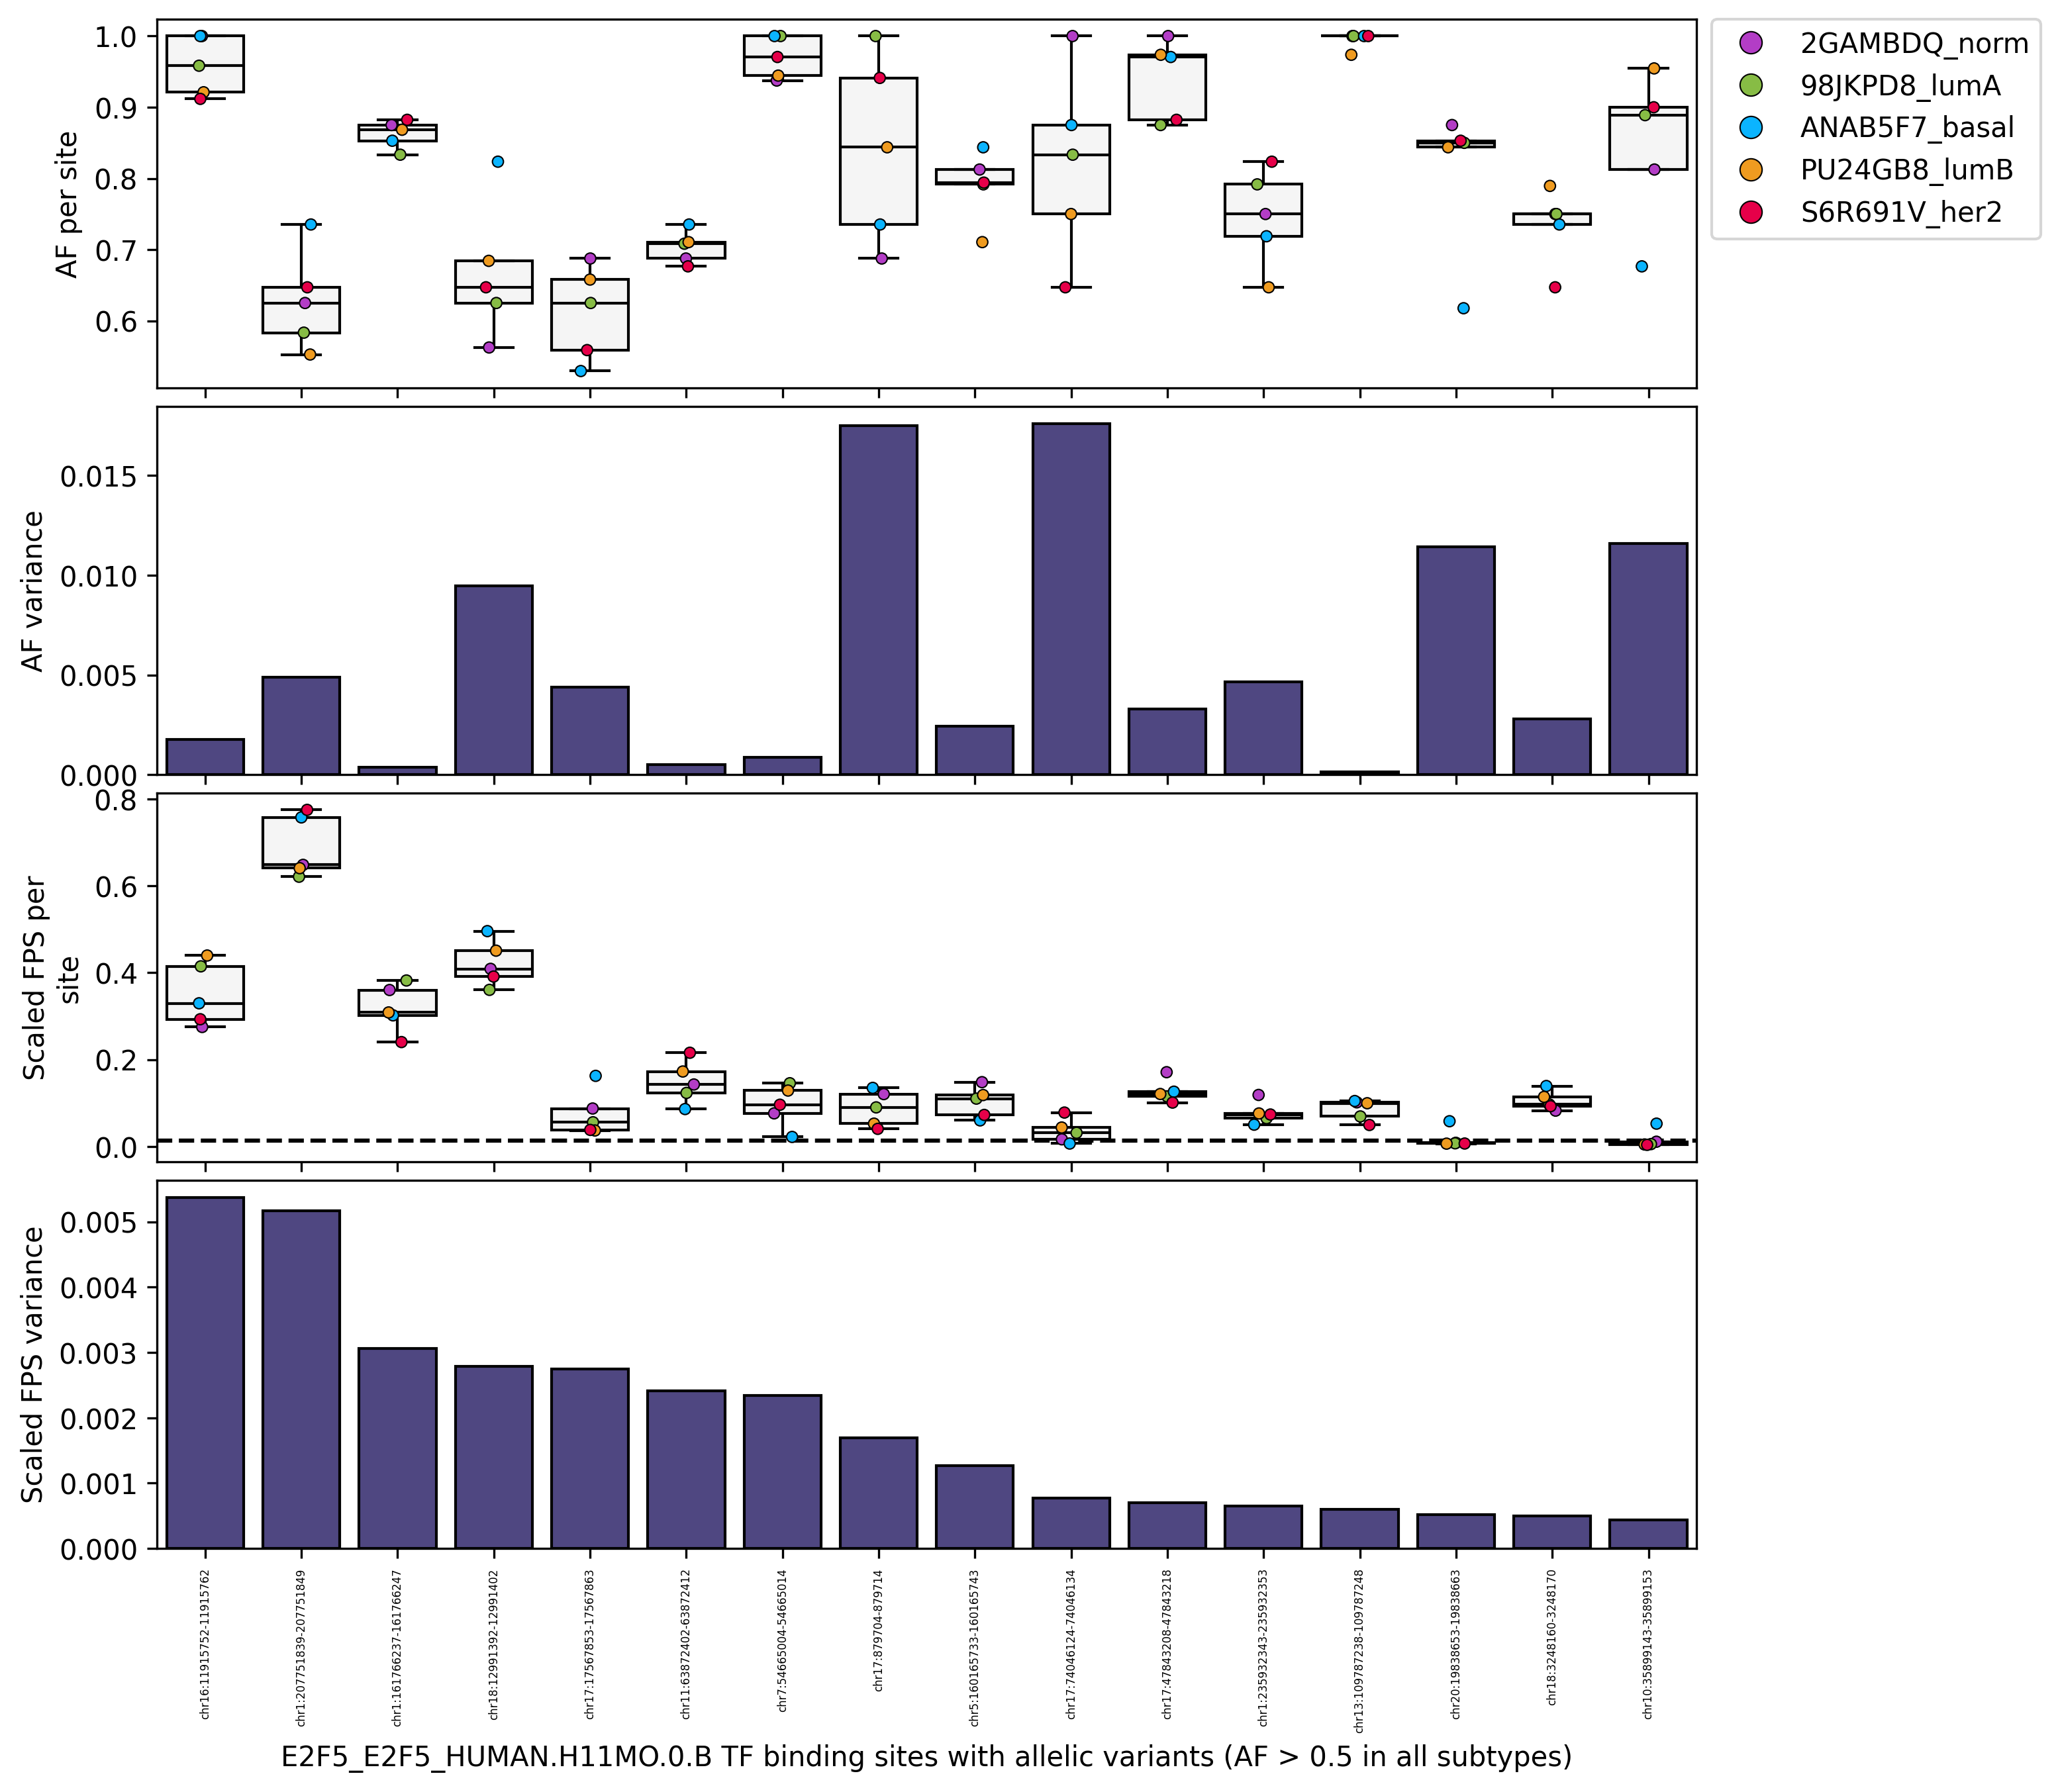

In [68]:
dutchfield_colordict = {'S6R691V_her2': "#e60049", 'ANAB5F7_basal': "#0bb4ff", '98JKPD8_lumA': "#87bc45", 'PU24GB8_lumB': "#ef9b20", '2GAMBDQ_norm': "#b33dc6"}
plt.figure(figsize=(10, 10), dpi=300)
# specify subplot
plt.subplot(4, 1, 1)
sns.boxplot(x='region_id', y='AF', data=high_nzaf_filtsorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='AF', data=high_nzaf_filtsorted, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, linewidth=0.5, edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('AF per site', width=15)
plt.ylabel(ylabel, fontsize=10)
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, markerscale=2, fontsize=10)

plt.subplot(4, 1, 2)
sns.barplot(x='region_id', y='AF_var', data=high_nzaf_filtsorted, color='darkslateblue', edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('AF variance', width=15)
plt.ylabel(ylabel, fontsize=10)
  
plt.subplot(4, 1, 3)
sns.boxplot(x='region_id', y='FPS_scaled', data=high_nzaf_filtsorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='FPS_scaled', data=high_nzaf_filtsorted, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, legend=False, linewidth=0.5, edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('Scaled FPS per site', width=15)
plt.ylabel(ylabel, fontsize=10)

plt.subplot(4, 1, 4)
sns.barplot(x='region_id', y='FPS_scaled_var', data=high_nzaf_filtsorted, color='darkslateblue', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel(f'{motif_id} TF binding sites with allelic variants (AF > 0.5 in all subtypes)', fontsize=10)
plt.ylabel('Scaled FPS variance', fontsize=10)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

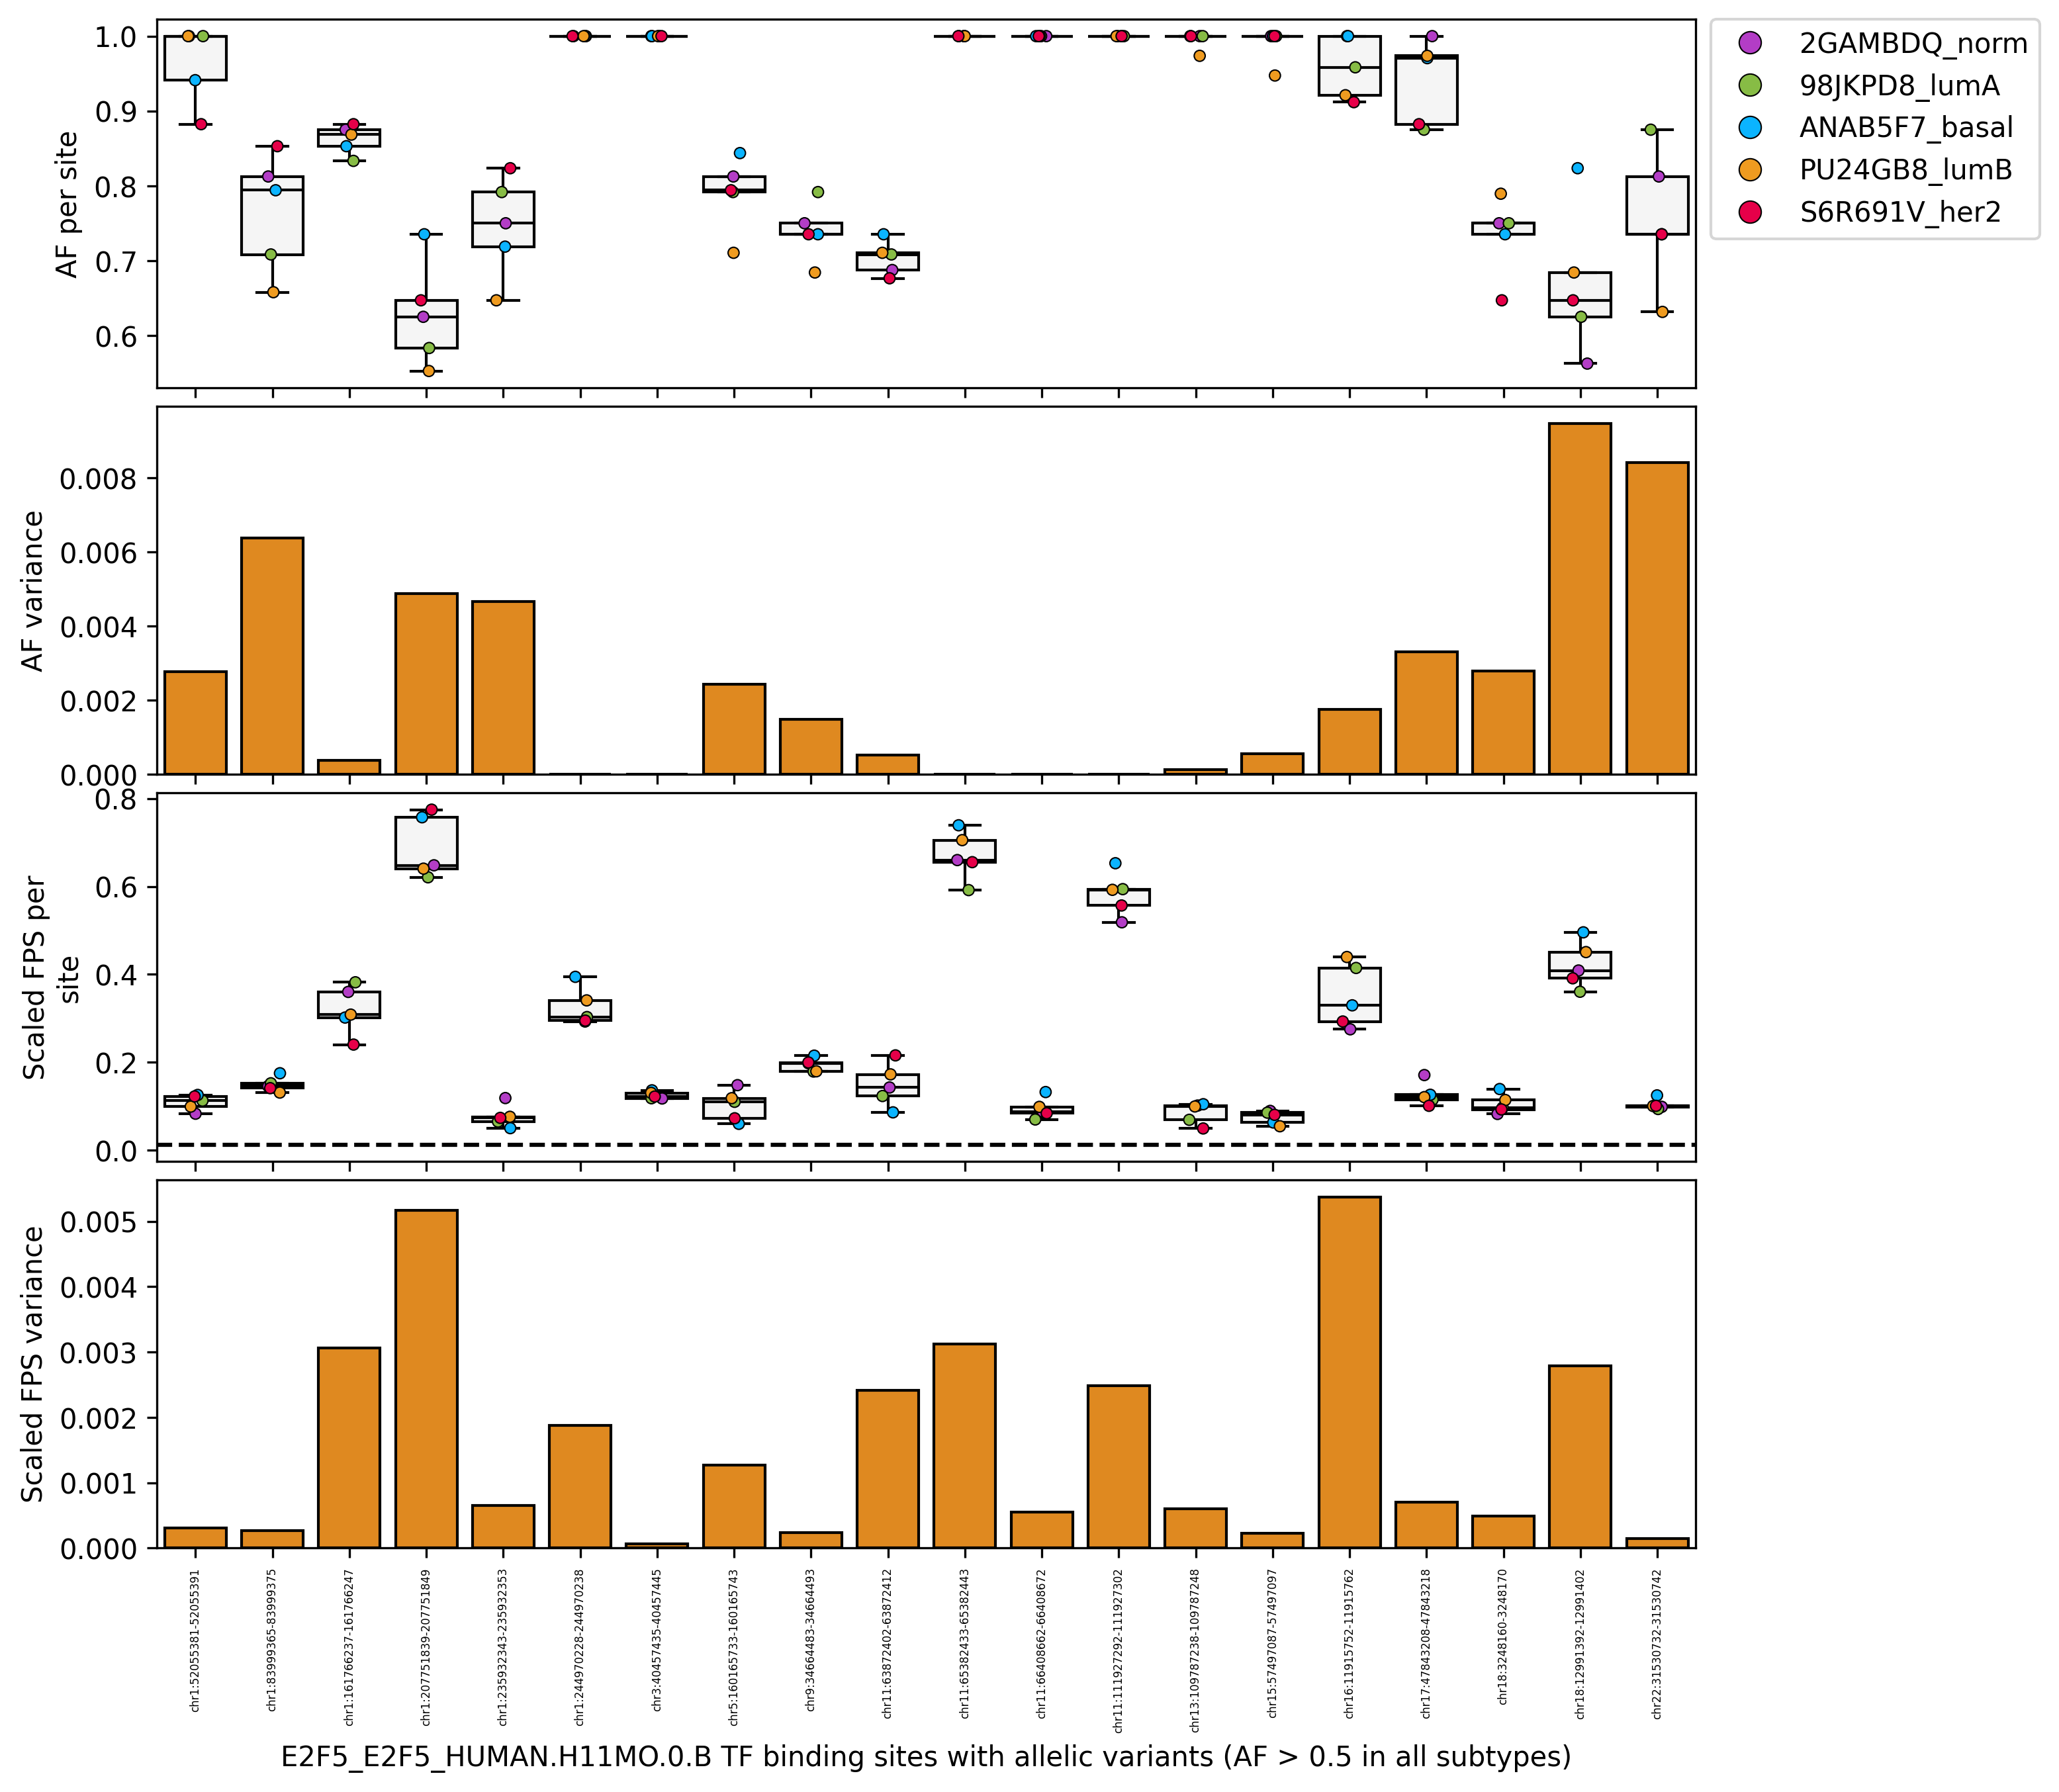

In [78]:
dutchfield_colordict = {'S6R691V_her2': "#e60049", 'ANAB5F7_basal': "#0bb4ff", '98JKPD8_lumA': "#87bc45", 'PU24GB8_lumB': "#ef9b20", '2GAMBDQ_norm': "#b33dc6"}
plt.figure(figsize=(10, 10), dpi=300)
# specify subplot
plt.subplot(4, 1, 1)
sns.boxplot(x='region_id', y='AF', data=high_af_fpsgtmean_filtsorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='AF', data=high_af_fpsgtmean_filtsorted, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, linewidth=0.5, edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('AF per site', width=15)
plt.ylabel(ylabel, fontsize=10)
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, markerscale=2, fontsize=10)

plt.subplot(4, 1, 2)
sns.barplot(x='region_id', y='AF_var', data=high_af_fpsgtmean_filtsorted, color='steelblue', edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('AF variance', width=15)
plt.ylabel(ylabel, fontsize=10)
  
plt.subplot(4, 1, 3)
sns.boxplot(x='region_id', y='FPS_scaled', data=high_af_fpsgtmean_filtsorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='FPS_scaled', data=high_af_fpsgtmean_filtsorted, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, legend=False, linewidth=0.5, edgecolor='black')
# plot horizontal line at fps_scaled_global_mean
plt.axhline(y=fps_scaled_global_mean, color='black', linestyle='--')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('Scaled FPS per site', width=15)
plt.ylabel(ylabel, fontsize=10)

plt.subplot(4, 1, 4)
sns.barplot(x='region_id', y='FPS_scaled_var', data=high_af_fpsgtmean_filtsorted, color='steelblue', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel(f'{motif_id} TF binding sites with allelic variants (AF > 0.5 in all subtypes)', fontsize=10)
plt.ylabel('Scaled FPS variance', fontsize=10)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

In [ ]:
dutchfield_colordict = {'S6R691V_her2': "#e60049", 'ANAB5F7_basal': "#0bb4ff", '98JKPD8_lumA': "#87bc45", 'PU24GB8_lumB': "#ef9b20", '2GAMBDQ_norm': "#b33dc6"}
plt.figure(figsize=(10, 10), dpi=300)
# specify subplot
plt.subplot(4, 1, 1)
sns.boxplot(x='region_id', y='AF', data=low_af_fpsgtmean_filtsorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='AF', data=low_af_fpsgtmean_filtsorted, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, linewidth=0.5, edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('AF per site', width=15)
plt.ylabel(ylabel, fontsize=10)
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, markerscale=2, fontsize=10)

plt.subplot(4, 1, 2)
sns.barplot(x='region_id', y='AF_var', data=low_af_fpsgtmean_filtsorted, color='teal', edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('AF variance', width=15)
plt.ylabel(ylabel, fontsize=10)
  
plt.subplot(4, 1, 3)
sns.boxplot(x='region_id', y='FPS_scaled', data=low_af_fpsgtmean_filtsorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='FPS_scaled', data=low_af_fpsgtmean_filtsorted, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, legend=False, linewidth=0.5, edgecolor='black')
# plot horizontal line at fps_scaled_global_mean
plt.axhline(y=fps_scaled_global_mean, color='black', linestyle='--')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('Scaled FPS per site', width=15)
plt.ylabel(ylabel, fontsize=10)

plt.subplot(4, 1, 4)
sns.barplot(x='region_id', y='FPS_scaled_var', data=low_af_fpsgtmean_filtsorted, color='teal', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel(f'{motif_id} TF binding sites with allelic variants (AF > 0.5 in all subtypes)', fontsize=10)
plt.ylabel('Scaled FPS variance', fontsize=10)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

In [ ]:
dutchfield_colordict = {'S6R691V_her2': "#e60049", 'ANAB5F7_basal': "#0bb4ff", '98JKPD8_lumA': "#87bc45", 'PU24GB8_lumB': "#ef9b20", '2GAMBDQ_norm': "#b33dc6"}
import textwrap
plt.figure(figsize=(10, 10), dpi=300)
# specify subplot
plt.subplot(4, 1, 1)
sns.boxplot(x='region_id', y='AF', data=high_af_fpsltmean_filtsorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='AF', data=high_af_fpsltmean_filtsorted, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, linewidth=0.5, edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('AF per site', width=15)
plt.ylabel(ylabel, fontsize=10)
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, markerscale=2, fontsize=10)

plt.subplot(4, 1, 2)
sns.barplot(x='region_id', y='AF_var', data=high_af_fpsltmean_filtsorted, color='mediumvioletred', edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('AF variance', width=15)
plt.ylabel(ylabel, fontsize=10)
  
plt.subplot(4, 1, 3)
sns.boxplot(x='region_id', y='FPS_scaled', data=high_af_fpsltmean_filtsorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='FPS_scaled', data=high_af_fpsltmean_filtsorted, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, legend=False, linewidth=0.5, edgecolor='black')
# plot horizontal line at fps_scaled_global_median
plt.axhline(y=fps_scaled_global_mean, color='black', linestyle='--')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('Scaled FPS per site', width=15)
plt.ylabel(ylabel, fontsize=10)

plt.subplot(4, 1, 4)
sns.barplot(x='region_id', y='FPS_scaled_var', data=high_af_fpsltmean_filtsorted, color='mediumvioletred', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel(f'{motif_id} TF binding sites with allelic variants (AF > 0.5 in all subtypes)', fontsize=10)
plt.ylabel('Scaled FPS variance', fontsize=10)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

In [ ]:
dutchfield_colordict = {'S6R691V_her2': "#e60049", 'ANAB5F7_basal': "#0bb4ff", '98JKPD8_lumA': "#87bc45", 'PU24GB8_lumB': "#ef9b20", '2GAMBDQ_norm': "#b33dc6"}
plt.figure(figsize=(10, 10), dpi=300)
# specify subplot
plt.subplot(4, 1, 1)
sns.boxplot(x='region_id', y='AF', data=low_af_fpsltmean_filtsorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='AF', data=low_af_fpsltmean_filtsorted, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, linewidth=0.5, edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('AF per site', width=15)
plt.ylabel(ylabel, fontsize=10)
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, markerscale=2, fontsize=10)

plt.subplot(4, 1, 2)
sns.barplot(x='region_id', y='AF_var', data=low_af_fpsltmean_filtsorted, color='darkolivegreen', edgecolor='black')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('AF variance', width=15)
plt.ylabel(ylabel, fontsize=10)
  
plt.subplot(4, 1, 3)
sns.boxplot(x='region_id', y='FPS_scaled', data=low_af_fpsltmean_filtsorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='FPS_scaled', data=low_af_fpsltmean_filtsorted, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, legend=False, linewidth=0.5, edgecolor='black')
# plot horizontal line at fps_scaled_global_mean
plt.axhline(y=fps_scaled_global_mean, color='black', linestyle='--')
plt.xticks(ticks=plt.xticks()[0], labels=[])
plt.xlabel('')
ylabel = textwrap.fill('Scaled FPS per site', width=15)
plt.ylabel(ylabel, fontsize=10)

plt.subplot(4, 1, 4)
sns.barplot(x='region_id', y='FPS_scaled_var', data=low_af_fpsltmean_filtsorted, color='darkolivegreen', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel(f'{motif_id} TF binding sites with allelic variants (AF > 0.5 in all subtypes)', fontsize=10)
plt.ylabel('Scaled FPS variance', fontsize=10)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

#### Strategy 1: Subtype highlighting

For FPS distribution there are subtypes that are more represented that others. Let's try to selectively highlight subtypes which are the maxima per site. 

In [69]:
# Find the index of the max FPS_scaled value for each region_id
idx_max = high_nzaf_filtsorted.groupby('region_id', observed=True)['FPS_scaled'].idxmax()
idx_min = high_nzaf_filtsorted.groupby('region_id', observed=True)['FPS_scaled'].idxmin()
# Select the corresponding rows
max_fps_scaled = high_nzaf_filtsorted.loc[idx_max]
min_fps_scaled = high_nzaf_filtsorted.loc[idx_min]

# do the same for AF
idx_max_af = high_nzaf_filtsorted.groupby('region_id', observed=True)['AF'].idxmax()
idx_min_af = high_nzaf_filtsorted.groupby('region_id', observed=True)['AF'].idxmin()
# Select the corresponding rows
max_af_raw = high_nzaf_filtsorted.loc[idx_max_af]
min_af_raw = high_nzaf_filtsorted.loc[idx_min_af]

In [70]:
# create masks for the inverse of max and min values
mask = ~high_nzaf_filtsorted.index.isin(idx_max)
max_fps_scaled_inv = high_nzaf_filtsorted[mask]

mask = ~high_nzaf_filtsorted.index.isin(idx_min)
min_fps_scaled_inv = high_nzaf_filtsorted[mask]

# do the same for AF
mask = ~high_nzaf_filtsorted.index.isin(idx_max_af)
max_af_raw_inv = high_nzaf_filtsorted[mask]

mask = ~high_nzaf_filtsorted.index.isin(idx_min_af)
min_af_raw_inv = high_nzaf_filtsorted[mask]

In [71]:
# create color dictionary
color_dict = {'S6R691V_her2': "#e60049", 'ANAB5F7_basal': "#0bb4ff", '98JKPD8_lumA': "#87bc45", 'PU24GB8_lumB': "#ef9b20", '2GAMBDQ_norm': "#b33dc6"}
gray = 'lightgray'
color_gray_dict = {'S6R691V_her2': gray, 'ANAB5F7_basal': gray, '98JKPD8_lumA': gray, 'PU24GB8_lumB': gray, '2GAMBDQ_norm': gray}

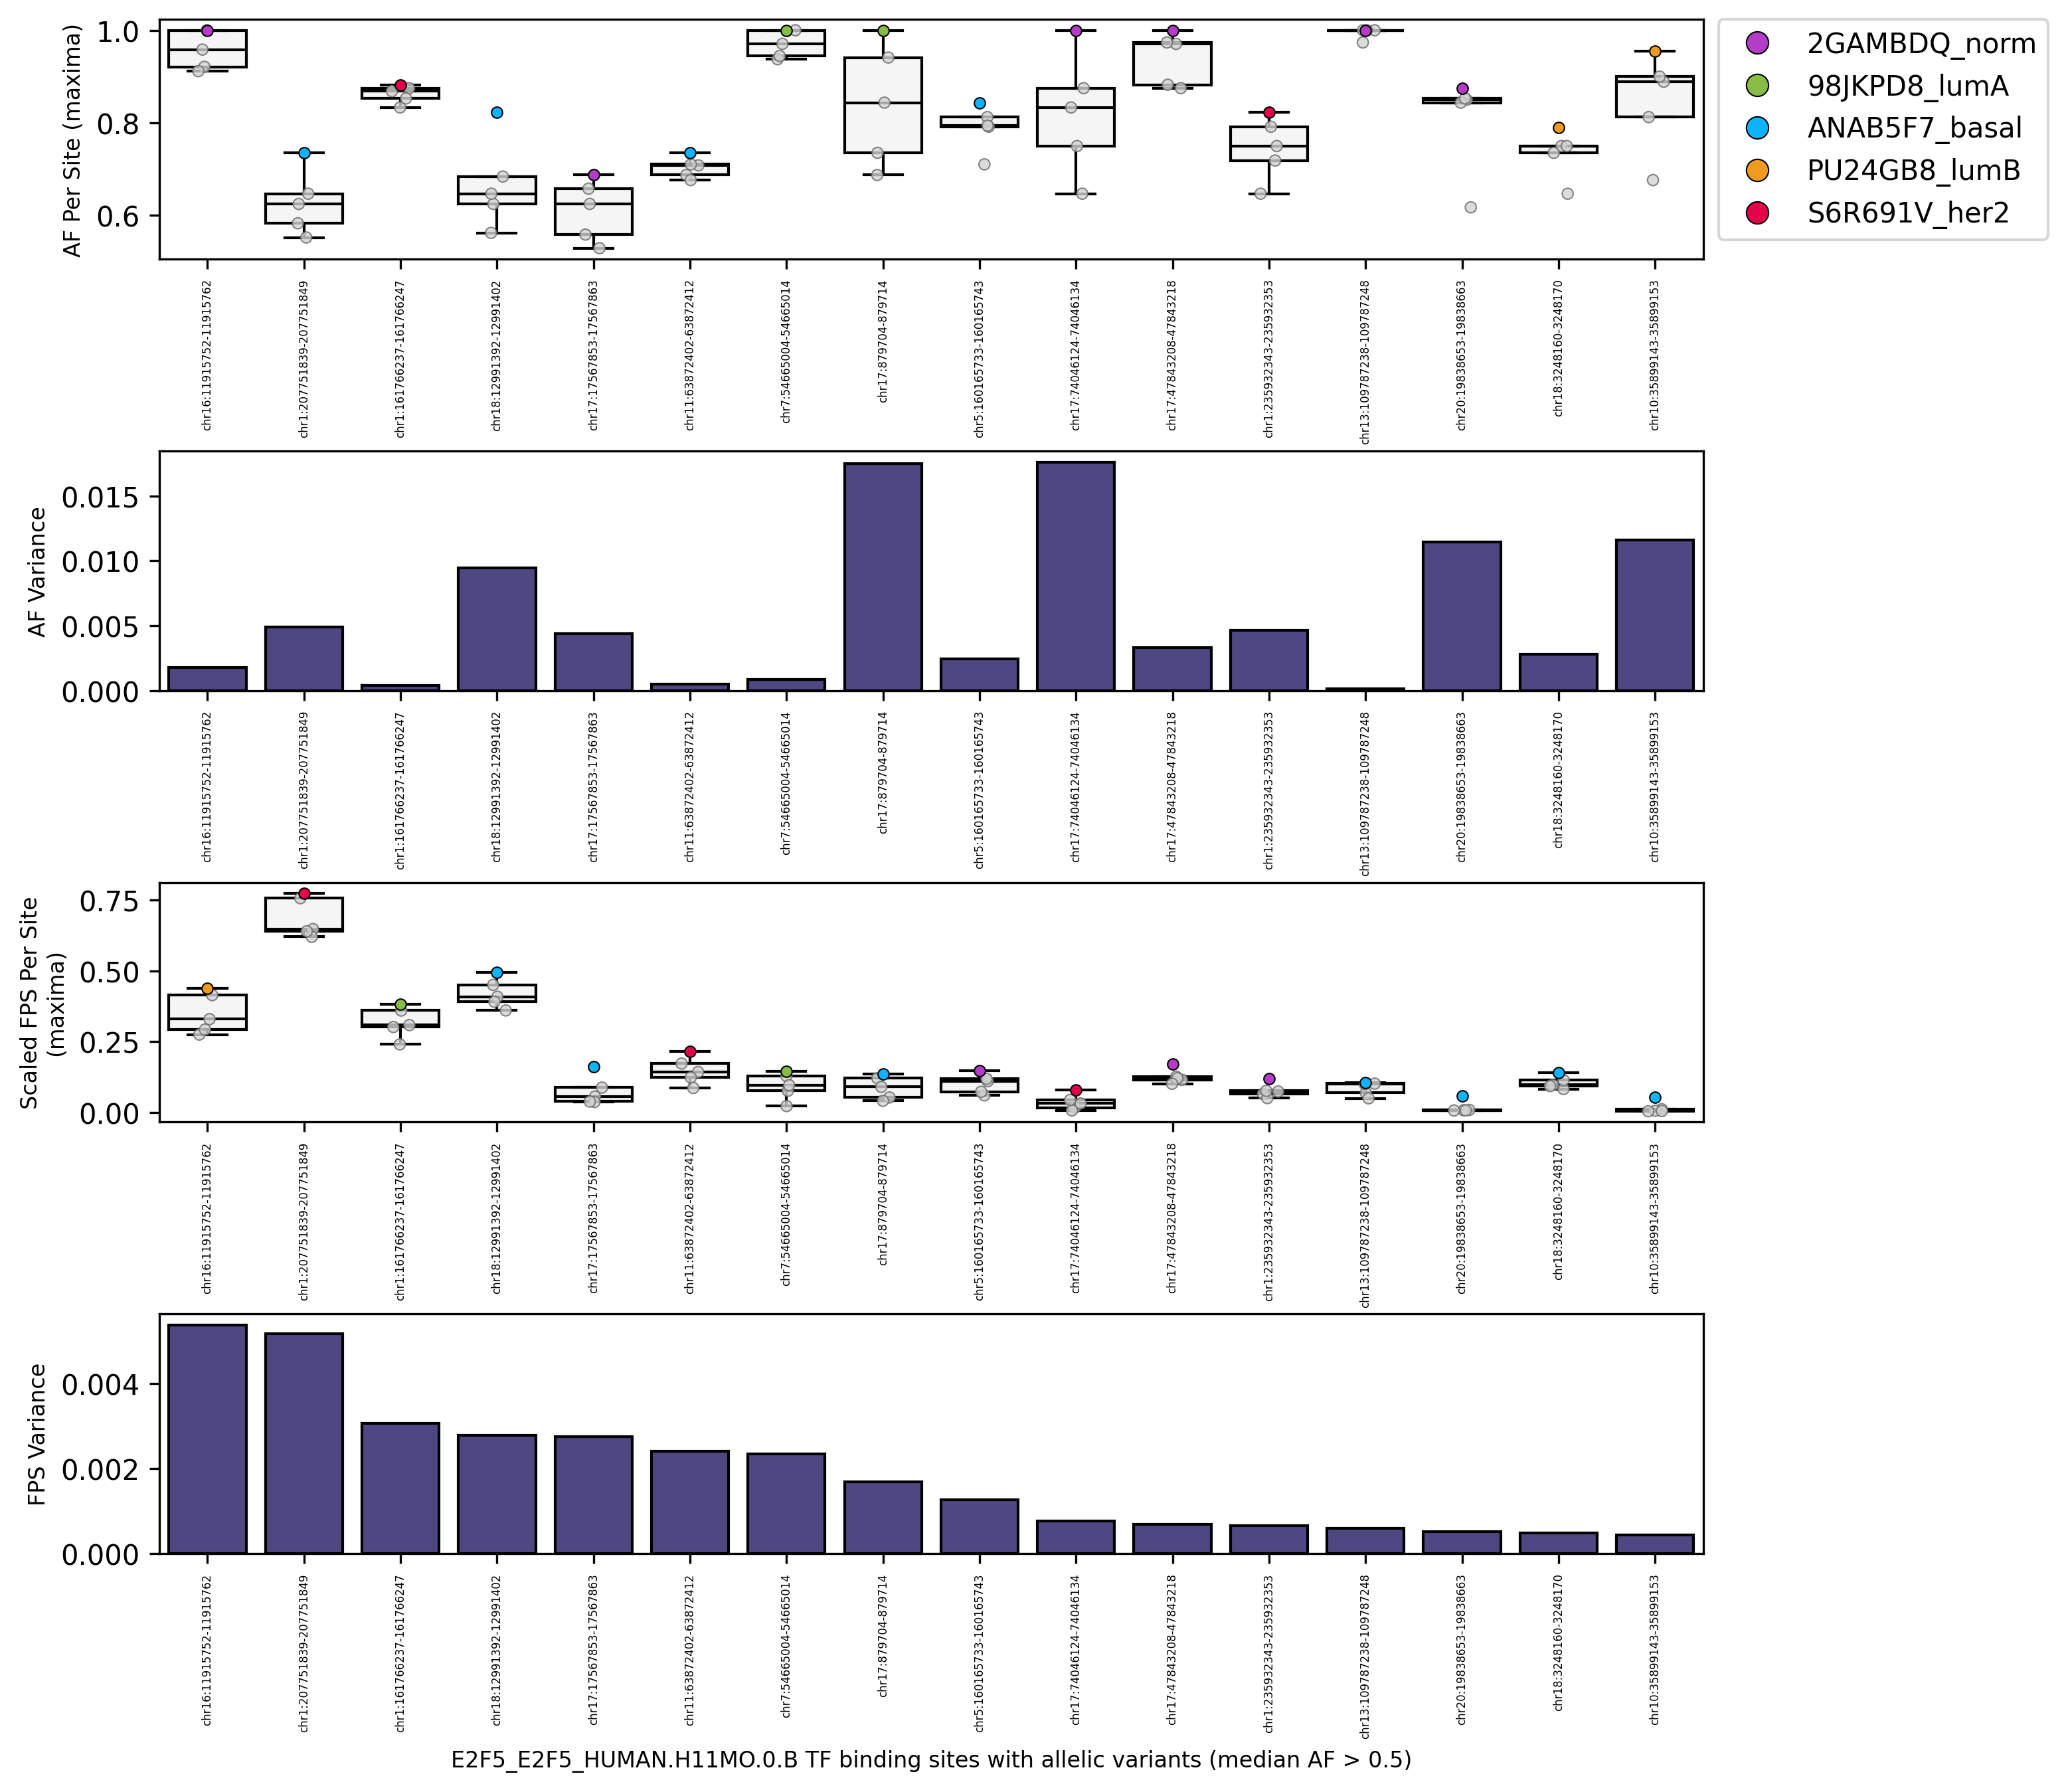

In [72]:
plt.figure(figsize=(10, 10), dpi=300)
# specify subplot
plt.subplot(4, 1, 1)
sns.boxplot(x='region_id', y='AF', data=high_nzaf_filtsorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='AF', data=max_af_raw_inv, hue='sample_id', palette=color_gray_dict, size=4, jitter=True, legend=False, linewidth=0.5, edgecolor='dimgray', alpha=0.8)
sns.stripplot(x='region_id', y='AF', data=max_af_raw, hue='sample_id', palette=color_dict, size=4, jitter=True, linewidth=0.5, edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('')
ylabel = textwrap.fill('AF Per Site (maxima)', width=20)
plt.ylabel(ylabel, fontsize=8)
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, markerscale=2, fontsize=10)
plt.subplot(4, 1, 2)
sns.barplot(x='region_id', y='AF_var', data=high_nzaf_filtsorted, color='darkslateblue', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('')
plt.ylabel('AF Variance', fontsize=8)
  
plt.subplot(4, 1, 3)
sns.boxplot(x='region_id', y='FPS_scaled', data=high_nzaf_filtsorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='FPS_scaled', data=max_fps_scaled_inv, hue='sample_id', palette=color_gray_dict, size=4, jitter=True, legend=False, linewidth=0.5, edgecolor='dimgray', alpha=0.8)
sns.stripplot(x='region_id', y='FPS_scaled', data=max_fps_scaled, hue='sample_id', palette=color_dict, size=4, jitter=True, legend=False, linewidth=0.5, edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('')
ylabel = textwrap.fill('Scaled FPS Per Site (maxima)', width=20)
plt.ylabel(ylabel, fontsize=8)

plt.subplot(4, 1, 4)
sns.barplot(x='region_id', y='FPS_scaled_var', data=high_nzaf_filtsorted, color='darkslateblue', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel(f'{motif_id} TF binding sites with allelic variants (median AF > 0.5)', fontsize=8)
plt.ylabel('FPS Variance', fontsize=8)
plt.subplots_adjust(hspace=0.8)

plt.show()

In [73]:
# quantify the number of filtered sites per sample_id
max_af_raw_subset = max_af_raw[['region_id', 'sample_id']]
max_af_raw_df = max_af_raw_subset.groupby('sample_id', observed=False)['region_id'].count().to_frame()

In [74]:
max_af_raw_df

region_id
sample_id               
2GAMBDQ_norm           6
98JKPD8_lumA           2
ANAB5F7_basal          4
PU24GB8_lumB           2
S6R691V_her2           2

In [75]:
max_fps_scaled_subset = max_fps_scaled[['region_id', 'sample_id']]
max_fps_scaled_df = max_fps_scaled_subset.groupby('sample_id', observed=False)['region_id'].count().to_frame()

In [76]:
max_fps_scaled_df

region_id
sample_id               
2GAMBDQ_norm           3
98JKPD8_lumA           2
ANAB5F7_basal          7
PU24GB8_lumB           1
S6R691V_her2           3